In [1]:
import numpy as np
from itertools import compress
import random
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (10, 10)
from mpl_toolkits.mplot3d import Axes3D 
import tikzplotlib
from itertools import chain, combinations
import pickle
import sys
#matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
float_formatter = "{:.3e}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
plt.rcParams.update({'font.size': 22})

In [2]:
!pip install matplotlib2tikz

In [3]:
def get_alives(x,a,b,basis,previous=None,thresh=1e-12,debug=False):
    if debug:
        print(f'Computing the list of elements that are alive with threshold {thresh}')
        print(f'x: {x}')
        print(f'a: {a}')
        print(f'b: {b}')
    x_=change_basis(x.copy(),orthonormal_basis(len(x)),basis)
    #print('get_alives')
    #print(x_)
    if sum((x_-a)>-thresh)<len(x_) or sum((b-x_)>-thresh)<len(x_):
        print('Issue: x is out of bound!')
    alive=(np.abs(x_-a)>thresh) & (np.abs(x_-b)>thresh)
    #print(alive)
    return alive,None if previous is None else [i for i in range(len(alive)) if ((previous[i]) and not alive[i])]

def choose_pivot(x,alive,mode='random',debug=False):
    if debug:
        print(f'Choosing pivot through mode {mode}.')
        print(f'x: {x}')
        print(f'Alive: {alive}')
    if mode=='max':
        for i in range(len(x),0,-1):
            if alive[i]:
                return i
        return -1
    if mode=='random':
        try:
            return random.choice(np.arange(len(x))[alive])
        except IndexError:
            #print('Every element is fixed')
            return -1
    
def next_direction(p,v,x,a,b,alive,debug=False):
    u=np.zeros(len(v))
    u[p]=1
    B=np.transpose(np.vstack(tuple([e for e in v])))#is v already a list ? If so we can simplify syntax here
    alive_and_not_pivot=alive.copy()
    #print(alive_and_not_pivot)
    #print(p)
    alive_and_not_pivot[p]=False
    if debug:
        print(f'Alive and not pivot: {alive_and_not_pivot}')
    alive_and_not_pivot=np.asarray(alive_and_not_pivot)
    B_t=B[:,alive_and_not_pivot]
    #print(f'B_t: {B_t}')
    #print(f'B_t^T*B_t: {np.matmul(np.transpose(B_t),B_t)}')
    #print(f'det: {np.linalg.det(np.matmul(np.transpose(B_t),B_t))}')
    u1=-np.matmul(np.matmul(inv(np.matmul(np.transpose(B_t),B_t)),np.transpose(B_t)),v[p])
    #print(f'u:{u}')
    #print(f'u1:{u1}')
    u[alive_and_not_pivot]=u1
    if debug:
        print(f'Calculated update direction u:{u}')
    return u

def next_direction2(p,v,x,a,b,alive,basis,debug=False):
    u=np.zeros(len(v))
    u[p]=1#u should have its proj on the pivot basis vector be 1
    #print(np.vstack(tuple([e for e in basis])))
    #print(np.transpose(np.vstack(tuple([e for e in v]))))
    B=np.matmul(np.transpose(np.vstack(tuple([e for e in v]))),np.vstack(tuple([e for e in basis])).T)#is v already a list ? If so we can simplify syntax here
    #print(np.vstack(tuple([e for e in v])))
    #print(np.transpose(np.vstack(tuple([e for e in basis]))))
    #print(B)
    alive_and_not_pivot=alive.copy()
    #print(alive_and_not_pivot)
    #print(p)
    alive_and_not_pivot[p]=False
    if debug:
        print(f'Alive and not pivot: {alive_and_not_pivot}')
    alive_and_not_pivot=np.asarray(alive_and_not_pivot)
    B_t=B[:,alive_and_not_pivot]
    #print(f'B_t: {B_t}')
    #print(f'B_t^T*B_t: {np.matmul(np.transpose(B_t),B_t)}')
    #print(f'det: {np.linalg.det(np.matmul(np.transpose(B_t),B_t))}')
    u1=-np.matmul(np.matmul(inv(np.matmul(np.transpose(B_t),B_t)),np.transpose(B_t)),B[:,p])#np.matmul(B,basis[p]) instead of v[p]?
    #print(u1)
    u1_=np.linalg.lstsq(B_t,-B[:,p])[0]
    if False and len(u1)>0 and max(np.abs(u1_-u1))>1e-10:
        print(u1)
        print(u1_)
    u1=u1_
    #print(u1)
    #B_t2=B.copy()
    #B_t2[:,~alive_and_not_pivot]=0
    #mid=inv(np.matmul(np.transpose(B_t2),B_t2))
    #mid[~alive_and_not_pivot,:][:,~alive_and_not_pivot]=0
    #u2=-np.matmul(np.matmul(mid,np.transpose(B_t2)),v[p])#np.matmul(B,basis[p]) instead of v[p]?
    #print(f'u:{u}')
    #print(f'u1:{u1}')
    u[alive_and_not_pivot]=u1
    #u2[p]=1
    #u[~alive_and_not_pivot]=0
    #u2[np.abs(u2)<1e-14]=0
    #B_t3=B.copy()
    #v2_p=v[p]
    #for b in range(len(basis)):
    #    if not alive_and_not_pivot[b]:
    #        #print(basis[b])
    #        #print(B_t3)
    #        B_t3=np.vstack([B_t3,basis[b]])
    #        if p==b:
    #            v2_p=np.append(v2_p,1)
    #        else:
    #            v2_p=np.append(v2_p,0)
    #print(B)
    #print(B_t3)
    #print(v2_p)
    #B_t3=B_t3[:,alive_and_not_pivot]
    #u3=-np.matmul(np.matmul(inv(np.matmul(np.transpose(B_t3),B_t3)),np.transpose(B_t3)),v2_p)
    #print(np.abs(u3-u2)<1e-10)
    #u3[p]=1
    if alive_and_not_pivot.any():
        q,r=np.linalg.qr(B[:,alive_and_not_pivot])
        rs=np.array([(r[i,:]==np.zeros(r.shape[1])).all() for i in range(r.shape[0])])
        if len(rs)!=0:
            q=q[:,~rs]
            v_perp=B[:,p]-q.dot(np.linalg.inv(q.T.dot(q))).dot(q.T).dot(B[:,p])
        else:
            v_perp=B[:,p]
    else:
        v_perp=B[:,p]
    y=v_perp-B[:,p]
    if debug or max(np.abs(v_perp-B.dot(u)))>1e-12:
        print(f'v_perp:{v_perp}')
        print(f'v_perp-sum u_i*v_i:{v_perp-B.dot(u)}')
    basis_constraints=[]
    basis_transformation=inv(np.transpose(np.vstack(tuple([e for e in basis]))))
    factor=1e20
    for i in range(len(alive_and_not_pivot)):
        if not alive_and_not_pivot[i]:
            if i==p:
                y=np.append(y,factor)
            else:
                y=np.append(y,0)
            basis_constraints.append(factor*basis_transformation[i,:])
    A=np.vstack([np.transpose(np.vstack(tuple([e for e in v]))),np.vstack(tuple([e for e in basis_constraints]))])
    #print(y)
    #print(A)
    #u=np.linalg.lstsq(A,y)[0]
    #print(u)
    #u[(~alive_and_not_pivot)&(np.abs(u)<1e-14)]=0
    if debug:
        print(f'v_perp:{v_perp}')
        print(f'v_perp-sum u_i*v_i:{v_perp-B.dot(u)}')
    if False and len(u3)>0 and max(np.abs(u3-u))>1e-10 and False:#and (basis == orthonormal_basis(len(x))).all():
        print('ALERT')
        print(u3)
        print(u)
        print(u3-u)
    #u[alive_and_not_pivot]=u3
    if False and max(np.abs(u-u2))>1e-9 and False:
        print(B_t2)
        print(alive)
        print(p)
        print(u)
        print(u2)
        print(np.abs(u-u2))
        print('Details')
        print(np.matmul(np.transpose(B_t2),B_t2)[alive_and_not_pivot,:][:,alive_and_not_pivot]-np.matmul(np.transpose(B_t),B_t))
        print(inv(np.matmul(np.transpose(B_t),B_t)))
        print(mid)
        print(mid[alive_and_not_pivot,:][:,alive_and_not_pivot]-inv(np.matmul(np.transpose(B_t),B_t)))
    if debug:
        print(f'Calculated update direction u:{u}')
    return change_basis(u,basis,orthonormal_basis(len(u)))

def next_factor(x,u_,a,b,basis,debug=False,smallest_delta=False):
    u=change_basis(u_,orthonormal_basis(len(x)),basis)
    #print(u)
    non_zero=np.abs(u)>1e-10
    #print('next factor')
    #print(non_zero)
    x_=change_basis(x,orthonormal_basis(len(x)),basis)[non_zero]
    #print(x)
    #print(x_)
    deltas=np.concatenate(((a[non_zero]-x_)/u[non_zero],(b[non_zero]-x_)/u[non_zero]),axis=0)
    if debug:
        print(f'All deltas considered:{deltas}')
    try:
        d_p=min(deltas[deltas>=0])
        if debug:
            print(f'delta_+:{d_p}')
    except:
        print(f'No delta>=0: {deltas}')#could set d_p=0 maybe
    try:
        d_m=max(deltas[deltas<=0])
        if debug:
            print(f'delta_-:{d_m}')
    except:
        print(f'No delta<=0: {deltas}')#could set d_m=0 maybe
    r=random.random()
    if r>d_p/(d_p-d_m) or (smallest_delta and d_p<abs(d_m)):
        if debug:
            print('delta=delta_+')
        return d_p,d_m
    if debug:
        print('delta=delta_-')
    return d_m,d_p

def change_basis(v,basis1,basis2):#from basis1 to basis2
    #print(v)
    #print(basis1)
    #print(basis2)
    return np.matmul(np.linalg.inv(np.transpose(np.array(basis2))),np.matmul(np.transpose(np.array(basis1)),v))

def orthonormal_basis(n):
    basis=[]
    for i in range(n):
        v_i=np.zeros(n)
        v_i[i]=1
        basis.append(v_i)
    return basis

def gram_schmidt_walk(v,x,a=None,b=None,plot=False,debug=False,smallest_delta=False,basis=None,order=False):
    if a is None:
        if debug:
            print('Initializing a with -1s')
        a=-np.ones(len(x))
    if b is None:
        if debug:
            print('Initializing b with 1s')
        b=np.ones(len(x))
    if basis is not None and len(basis)<len(x):
        print('Basis is lacking vectors to be full-dimensional: replacing it by a canonical orthonormal basis')#could complete it with Gram-Schmidt maybe
        basis=None
    if basis is not None and np.linalg.cond(np.array(basis)) > 1/sys.float_info.epsilon:
        print('Basis matrix is singular: replacing it by a canonical orthonormal basis')#could complete it with Gram-Schmidt maybe too
        basis=None
    if basis is None:
        basis=orthonormal_basis(len(v))
    if sum(a<b)<len(x):
        print('Issue with hyper parallelepipeds: a>b for some dimension')
    alive,_=get_alives(x,a,b,basis,debug=debug)
    p=choose_pivot(x,alive,debug=debug)
    i=1
    colored=[]
    while p!=-1:
        if debug:
            print(f'\n Iteration {i}')
        u=next_direction2(p,v,x,a,b,alive,basis,debug=debug)
        d1,d2=next_factor(x,u,a,b,basis,debug=debug,smallest_delta=smallest_delta)
        if plot:
            plot_situation_v2(v,p,x,u,[d1,d2],i)
        x+=d1*u
        if debug:
            print(f'Incurred discrepancy:{norm(np.matmul(np.transpose(np.vstack(tuple([e for e in v]))),x))}')
        alive,newly_colored=get_alives(x,a,b,basis,alive,debug=debug)
        #print(colored)
        #print(newly_colored)
        colored.extend(newly_colored)
        if not alive[p]:
            p=choose_pivot(x,alive,debug=debug)
        i+=1
        if i-2>len(x):
            print('Issue, the algorithm took more steps than expected')
            #print(f'x:{x}')
            #print(f'u:{u}')
        if debug:
            print('in basis')
            print(f'x:{change_basis(x,orthonormal_basis(len(x)),basis)}')
            print(f'u:{change_basis(u,orthonormal_basis(len(x)),basis)}')
    if order:
        return x,colored#change_basis(x,basis,orthonormal_basis(len(x))),colored
    else:
        return x#change_basis(x,basis,orthonormal_basis(len(x)))

def gram_schmidt_columns(X):
    Q, R = np.linalg.qr(X)
    return Q

def sample_from_sphere(n):
    thetas=np.random.uniform(0,2*np.pi,n)
    return [np.array([np.sin(t),np.cos(t)]) for t in thetas]

def sample_from_ball(n,d=2):
    p=[]
    for i in range(n):
        u = np.random.normal(0,1,d)  # an array of d normally distributed random variables
        norm=np.sum(u**2) **(0.5)
        r = random.random()**(1.0/d)
        p.append(r*u/norm)
    return p
    #r = np.random.uniform(0,1,n)**0.5
    #theta = np.random.uniform(0,2*np.pi,n)
    #x = r*np.cos(theta)
    #y = r*np.sin(theta)
    #return [np.array([x[i],y[i]]) for i in range(n)]
    
def sample_binary(n,d,p=0.5):
    return [np.random.binomial(size=d, n=1, p=p) for i in range(n)]

def inv(m):
    a,_ = m.shape
    i = np.eye(a, a)
    sol=np.linalg.lstsq(m, i)
    #print(sol[3])
    return sol[0]

def latex_vector(x):
    return str(list(x)).replace('[','').replace(']','').replace(',','\\ \n')

def plot_situation(v,p,x,u,deltas,i):
    #plot vectors, combination where it is now, two potential updates,show x and deltas and u
    plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
    B=np.transpose(np.vstack(tuple([e for e in v])))
    plt.plot(np.matmul(B,x)[0],np.matmul(B,x)[1],'X',label='Current relaxation',markersize=15)
    x_1=x+deltas[0]*u
    x_2=x+deltas[1]*u
    xs=[x_1,x_2]
    print(f'xs: {xs}')
    print(f'sum:{[np.matmul(B,x) for x in xs]}')
    plt.plot([np.matmul(B,x)[0] for x in xs],[np.matmul(B,x)[1] for x in xs],'H',label='Potential updated relaxation')
    #plt.figtext(0.63,0.05, f"$x_t=\begin%{latex_vector(np.round(x,3))}\end%$\\ \n $u_t=\begin%{latex_vector(np.round(u,3))}\end%$\\ \n $\delta^+_t,\delta^-_t ={str(list(np.round(np.array(deltas),3))).replace('[','').replace(']','')}$".replace('%','{pmatrix}'))
    plt.figtext(0.63,0.05, f"$\delta^+_t,\delta^-_t ={str(list(np.round(np.array(deltas),3))).replace('[','').replace(']','')}$")
    plt.legend(bbox_to_anchor=(1.8, 1))
    tikzplotlib.save(f"gswalk{i}2d.tex")
    plt.show()
    if x.shape[0]==3:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.gca(projection='3d')

        sn = 1   #limits in x,y,z
        x1, x2 = -sn, sn
        y1, y2 = -sn, sn    
        z1, z2 = -sn, sn
        ax.scatter(x[0],x[1],x[2],label='Current coloring')
        ax.scatter([x_1[0],x_2[0]], [x_1[1],x_2[1]],zs=[x_1[2],x_2[2]])

        # Data for plotting plane x|y|z=0 within the domain
        tmp = np.linspace(-1, sn, 8)
        x,y = np.meshgrid(tmp,tmp)
        z = 0*x

        ax.plot_surface(z+1,x,y, alpha=0.15, color='red')    # plot the plane x=1
        ax.plot_surface(z-1,x,y, alpha=0.15, color='red')    # plot the plane x=-1
        ax.plot_surface(x,z+1,y, alpha=0.15, color='green')  # plot the plane y=1
        ax.plot_surface(x,z-1,y, alpha=0.15, color='green')  # plot the plane y=-1
        ax.plot_surface(x,y,z+1, alpha=0.15, color='blue')   # plot the plane z=1
        ax.plot_surface(x,y,z-1, alpha=0.15, color='blue')   # plot the plane z=-1
        ax.plot([x_1[0],x_2[0]], [x_1[1],x_2[1]],zs=[x_1[2],x_2[2]],label='Update direction')

        # Set limits of the 3D display
        ax.set_xlim3d([-sn, sn])
        ax.set_ylim3d([-sn, sn])
        ax.set_zlim3d([-sn, sn])

        # Set labels at the 3d box/frame
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.savefig(f"gswalk{i}3d.png")
        plt.legend()
        tikzplotlib.save(f"gswalk{i}3d.tex")
        plt.show()
        
def plot_situation_v2(v,p,x,u,deltas,i):
    #fig, (ax1, ax2) = plt.subplots(1, 2)
    fig = plt.figure(figsize=plt.figaspect(0.5))
    fig.subplots_adjust(wspace=0.1, hspace=0)
    ax1 = fig.add_subplot(1, 2, 2)
    #plot vectors, combination where it is now, two potential updates,show x and deltas and u
    ax1.plot([v[e][0] for e in range(len(v)) if np.abs(x[e])<1],[v[e][1] for e in range(len(v)) if np.abs(x[e])<1],'o',label='Colorless vector')
    ax1.plot([v[e][0] for e in range(len(v)) if np.abs(x[e])==1],[v[e][1] for e in range(len(v)) if np.abs(x[e])==1],'o',label='Colored vector')
    ax1.plot(v[p][0],v[p][1],'*',label='Pivot vector',markersize=12)
    B=np.transpose(np.vstack(tuple([e for e in v])))
    ax1.plot(np.matmul(B,x)[0],np.matmul(B,x)[1],'X',label='Current balance',markersize=15)
    x_1=x+deltas[0]*u
    x_2=x+deltas[1]*u
    xs=[x_1,x_2]
    print(f'xs: {xs}')
    print(f'sum:{[np.matmul(B,x) for x in xs]}')
    ax1.plot([np.matmul(B,x)[0] for x in xs],[np.matmul(B,x)[1] for x in xs],'<',label='Potential update')
    #plt.figtext(0.63,0.05, f"$x_t=\begin%{latex_vector(np.round(x,3))}\end%$\\ \n $u_t=\begin%{latex_vector(np.round(u,3))}\end%$\\ \n $\delta^+_t,\delta^-_t ={str(list(np.round(np.array(deltas),3))).replace('[','').replace(']','')}$".replace('%','{pmatrix}'))
    plt.figtext(0.45,0.04, f"$\delta^+_t,\delta^-_t ={str(list(np.round(np.array(deltas),3))).replace('[','').replace(']','')}$")
    #ax1.legend(bbox_to_anchor=(0,0),loc='lower center')

    #tikzplotlib.save(f"gswalk{i}2d.tex")
    #plt.show()
    if x.shape[0]==3:
        #fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 2, 1, projection='3d')

        sn = 1   #limits in x,y,z
        x1, x2 = -sn, sn
        y1, y2 = -sn, sn    
        z1, z2 = -sn, sn

        # Data for plotting plane x|y|z=0 within the domain
        tmp = np.linspace(-1, sn, 8)
        x_,y = np.meshgrid(tmp,tmp)
        z = 0*x_

        ax.plot_surface(z+1,x_,y, alpha=0.15, color='red')    # plot the plane x=1
        ax.plot_surface(z-1,x_,y, alpha=0.15, color='red')    # plot the plane x=-1
        ax.plot_surface(x_,z+1,y, alpha=0.15, color='green')  # plot the plane y=1
        ax.plot_surface(x_,z-1,y, alpha=0.15, color='green')  # plot the plane y=-1
        ax.plot_surface(x_,y,z+1, alpha=0.15, color='blue')   # plot the plane z=1
        ax.plot_surface(x_,y,z-1, alpha=0.15, color='blue')   # plot the plane z=-1
        ax.scatter(x[0],x[1],x[2],label='Current coloring')
        ax.scatter([x_1[0],x_2[0]], [x_1[1],x_2[1]],zs=[x_1[2],x_2[2]],label='Potential update')
        ax.plot([x_1[0],x_2[0]], [x_1[1],x_2[1]],zs=[x_1[2],x_2[2]],label='Update direction')

        # Set limits of the 3D display
        ax.set_xlim3d([-sn, sn])
        ax.set_ylim3d([-sn, sn])
        ax.set_zlim3d([-sn, sn])

        # Set labels at the 3d box/frame
        #ax.set_xlabel('X')
        #ax.set_ylabel('Y')
        #ax.set_zlabel('Z')
        ax.legend(bbox_to_anchor=(0.8, -0.07))
    ax1.legend(bbox_to_anchor=(1.1, -0.07),ncol=2)
    plt.savefig(f"gswalkboth{i}.pdf", bbox_inches='tight')
    tikzplotlib.save(f"gswalk{i}both.tex")
    plt.show()
    
def naive_walk(vs_):
    vs=vs_.copy()
    indices=list(range(len(vs)))
    random.shuffle(indices)
    x=np.zeros(len(vs))
    output=np.zeros(len(vs[0]))
    for i in indices:
        v=vs[i]
        if norm(output+v)<norm(output-v):
            x[i]=1
            output+=v
        else:
            x[i]=-1
            output-=v
    return x

def norm(v):
    return np.sqrt(sum(v**2))

def normalize(v):
    return v/norm(v)

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def best_coloring(v):
    indices_subset=powerset(range(len(v)))
    v_mat=np.transpose(np.array(v))
    best_assignment=[]
    best_disc=None
    for i_s in indices_subset:
        assignment=np.array([1 if i in i_s else -1 for i in range(len(v))])
        disc=norm(np.matmul(v_mat,assignment))
        if best_disc is None or disc<best_disc:
            best_disc=disc
            best_assignment=assignment
    return np.sqrt(best_disc),best_assignment

def open_dic_file(file_name):
    try:
        file = open(file_name, "rb")
        dic = pickle.load(file)
        file.close()
        return dic
    except FileNotFoundError:
        return {}

def save_dic_to_file(dic,file_name):
    file = open(file_name,'wb')
    pickle.dump(dic,file)
    file.close()
    
def average(list_):
    return sum(list_)/len(list_)

C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:296: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


xs: [array([-3.005e-01, -2.443e-01, 5.135e-02, -2.394e-01, 2.774e-01,
       -1.017e-01, -2.915e-01, -8.090e-02, 1.000e+00, 7.084e-02]), array([3.005e-01, 2.443e-01, -5.135e-02, 2.394e-01, -2.774e-01, 1.017e-01,
       2.915e-01, 8.090e-02, -1.000e+00, -7.084e-02])]
sum:[array([5.898e-17, 1.180e-16]), array([-5.898e-17, -1.180e-16])]


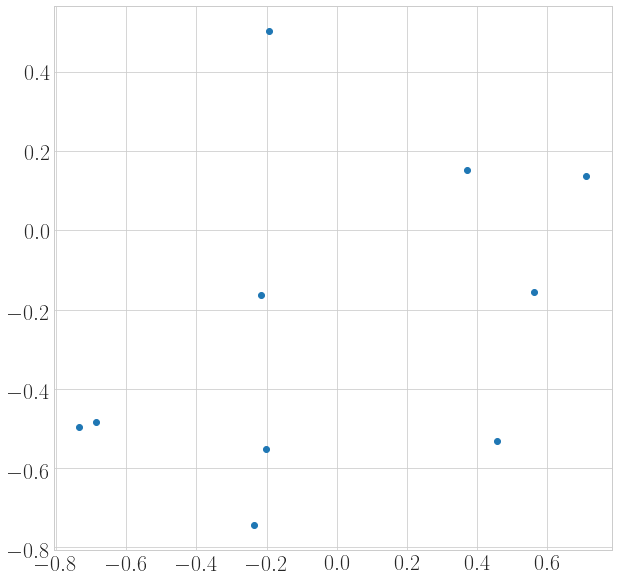

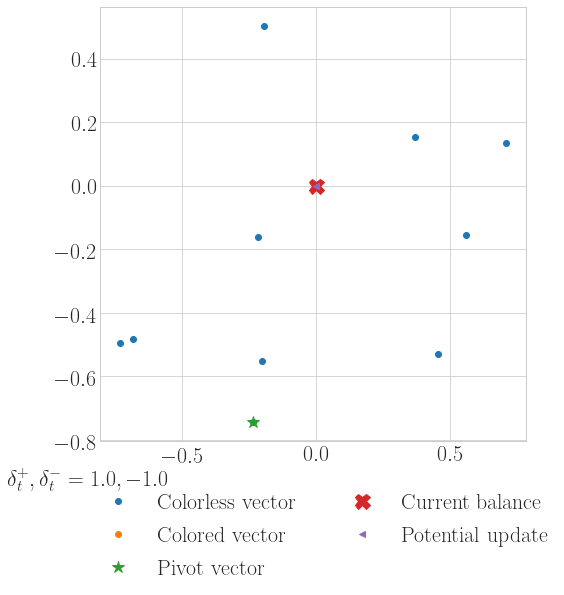

xs: [array([-3.428e-01, -1.119e-01, -6.060e-02, -1.148e-01, 2.822e-01,
       -1.775e-01, -2.353e-01, -4.104e-02, 1.000e+00, 1.000e+00]), array([-2.519e-01, -3.969e-01, 1.804e-01, -3.830e-01, 2.718e-01,
       -1.449e-02, -3.563e-01, -1.268e-01, 1.000e+00, -1.000e+00])]
sum:[array([-1.110e-16, 0.000e+00]), array([1.665e-16, 2.498e-16])]


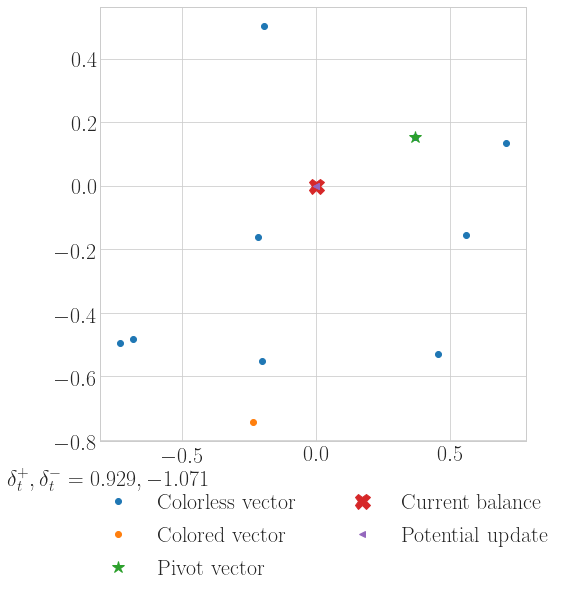

xs: [array([-3.553e-01, 1.000e+00, 3.273e-01, -6.370e-01, 4.043e-01, 1.714e-02,
       -5.619e-01, -2.102e-01, 1.000e+00, 1.000e+00]), array([-3.328e-01, -1.000e+00, -3.704e-01, 3.023e-01, 1.847e-01,
       -3.329e-01, 2.556e-02, 9.408e-02, 1.000e+00, 1.000e+00])]
sum:[array([-2.220e-16, 0.000e+00]), array([-1.110e-16, 0.000e+00])]


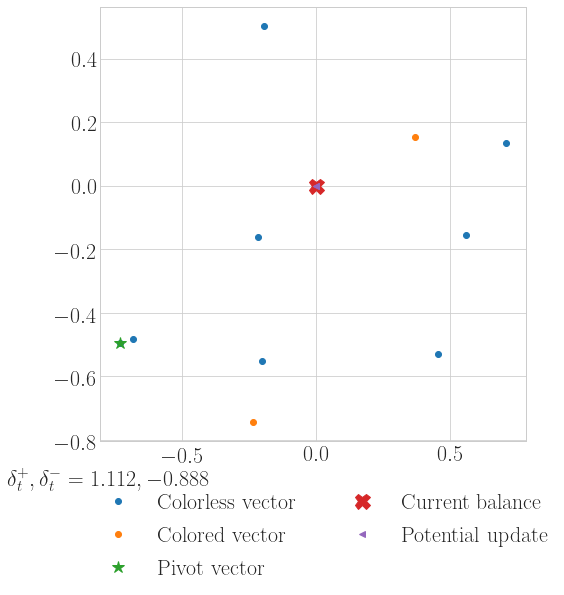

xs: [array([-3.414e-01, 1.000e+00, 1.129e-01, -1.000e+00, 3.307e-01,
       -8.746e-02, -3.756e-01, -1.153e-01, 1.000e+00, 1.000e+00]), array([-3.878e-01, 1.000e+00, 8.314e-01, 2.167e-01, 5.772e-01, 2.631e-01,
       -1.000e+00, -4.333e-01, 1.000e+00, 1.000e+00])]
sum:[array([-3.331e-16, -1.110e-16]), array([1.110e-16, 1.110e-16])]


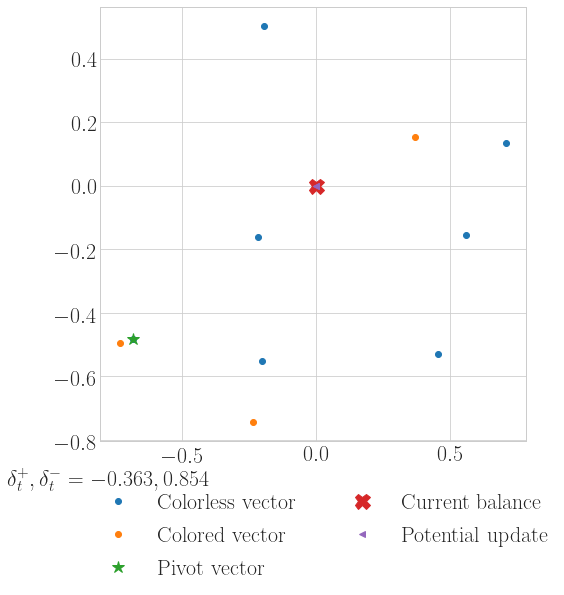

xs: [array([-6.143e-01, 1.000e+00, 1.000e+00, -1.000e+00, 3.051e-01,
       -6.788e-01, 1.489e-01, 2.273e-01, 1.000e+00, 1.000e+00]), array([-1.658e-02, 1.000e+00, -9.430e-01, -1.000e+00, 3.612e-01,
       6.164e-01, -1.000e+00, -5.232e-01, 1.000e+00, 1.000e+00])]
sum:[array([1.110e-16, -2.220e-16]), array([-5.551e-16, -1.110e-16])]


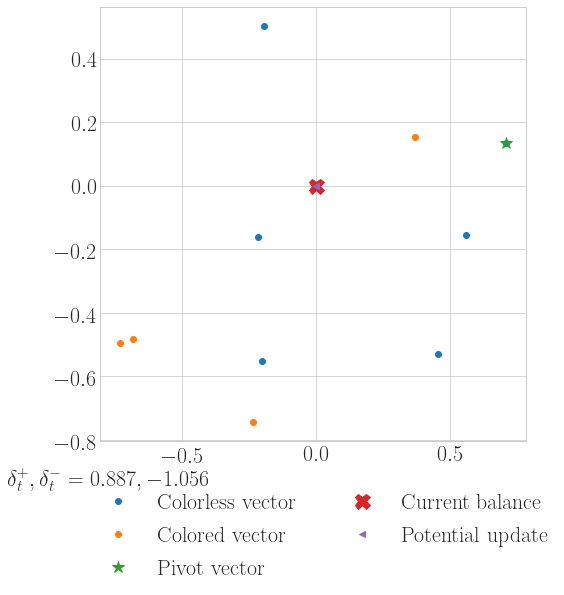

xs: [array([-3.869e-01, 1.000e+00, 1.000e+00, -1.000e+00, 2.281e-01,
       -1.000e+00, -8.405e-03, 8.928e-02, 1.000e+00, 1.000e+00]), array([-1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00, 4.357e-01,
       -1.342e-01, 4.158e-01, 4.614e-01, 1.000e+00, 1.000e+00])]
sum:[array([1.110e-16, -1.110e-16]), array([2.220e-16, -1.110e-16])]


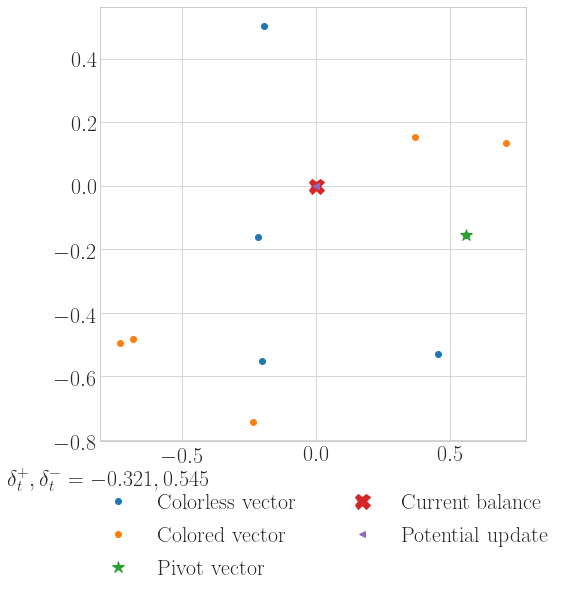

xs: [array([6.847e-02, 1.000e+00, 1.000e+00, -1.000e+00, 1.000e+00, -1.000e+00,
       2.494e-01, 1.149e-01, 1.000e+00, 1.000e+00]), array([-1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00, -8.111e-01,
       -1.000e+00, -3.556e-01, 5.474e-02, 1.000e+00, 1.000e+00])]
sum:[array([0.000e+00, -2.220e-16]), array([1.665e-16, -2.220e-16])]


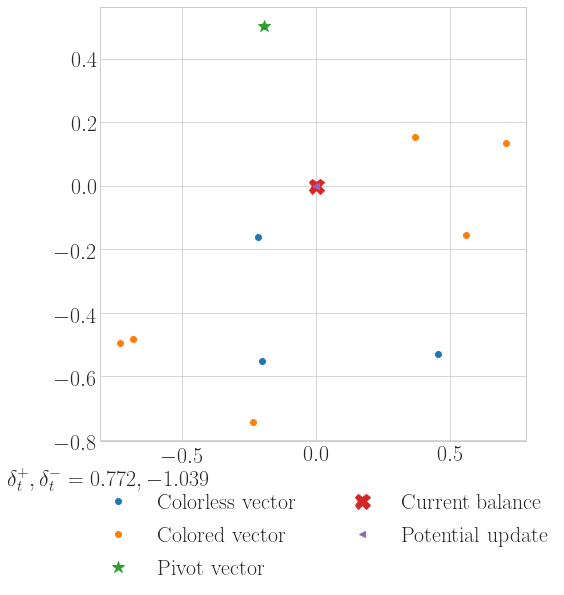

xs: [array([2.828e-01, 1.000e+00, 1.000e+00, -1.000e+00, 1.000e+00, -1.000e+00,
       -2.172e-01, 1.000e+00, 1.000e+00, 1.000e+00]), array([-2.016e-01, 1.000e+00, 1.000e+00, -1.000e+00, 1.000e+00,
       -1.000e+00, 8.373e-01, -1.000e+00, 1.000e+00, 1.000e+00])]
sum:[array([0.000e+00, -2.220e-16]), array([-1.110e-16, -1.110e-16])]


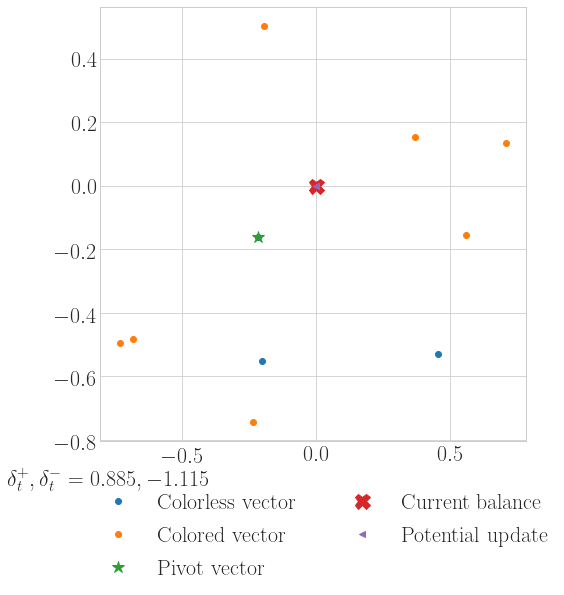

xs: [array([6.047e-01, 1.000e+00, 1.000e+00, -1.000e+00, 1.000e+00, -1.000e+00,
       -1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]), array([-2.177e-01, 1.000e+00, 1.000e+00, -1.000e+00, 1.000e+00,
       -1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00])]
sum:[array([3.044e-01, 2.614e-01]), array([-4.734e-01, -4.065e-01])]


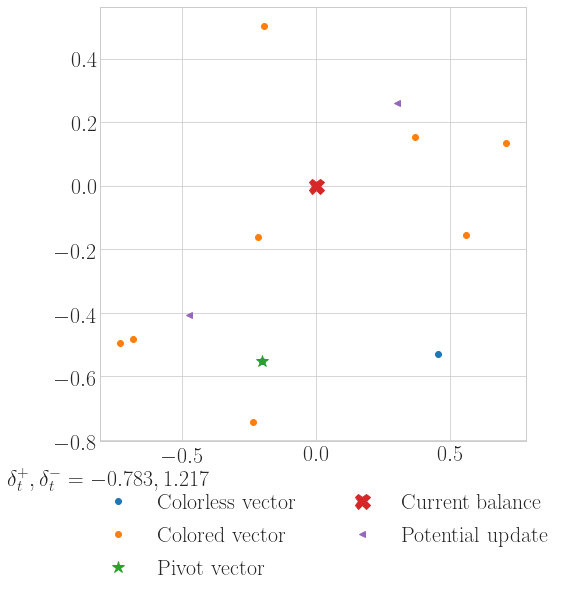

xs: [array([1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00, 1.000e+00, -1.000e+00,
       -1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]), array([-1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00, 1.000e+00,
       -1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00])]
sum:[array([4.845e-01, 5.166e-02]), array([-4.268e-01, 1.113e+00])]


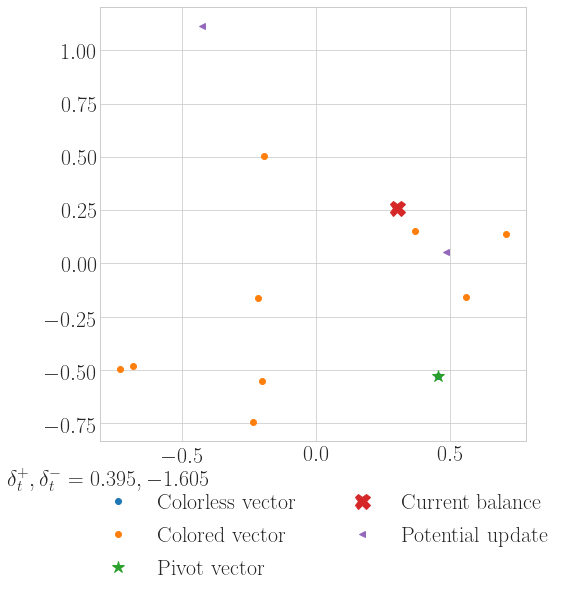

xs: [array([2.203e-01, -2.669e-01, -1.000e+00, -2.478e-01, -1.119e-01,
       2.389e-01, -4.623e-02, -7.772e-02, -4.720e-02, 1.413e-01]), array([-2.203e-01, 2.669e-01, 1.000e+00, 2.478e-01, 1.119e-01, -2.389e-01,
       4.623e-02, 7.772e-02, 4.720e-02, -1.413e-01])]
sum:[array([3.816e-16, 2.220e-16]), array([-3.816e-16, -2.220e-16])]


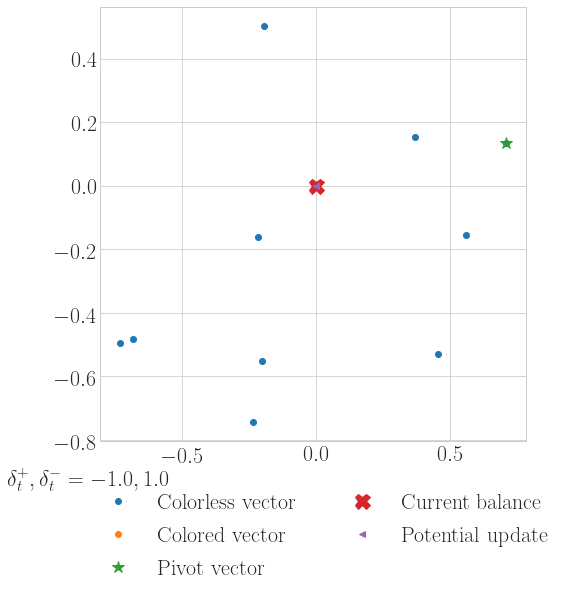

xs: [array([3.797e-01, 1.000e+00, -1.000e+00, -8.218e-01, -1.077e-01,
       5.649e-01, -3.220e-01, -2.617e-01, -3.945e-01, 4.237e-01]), array([1.280e-01, -1.000e+00, -1.000e+00, 8.434e-02, -1.143e-01,
       5.019e-02, 1.133e-01, 2.875e-02, 1.537e-01, -2.212e-02])]
sum:[array([1.388e-16, 8.327e-17]), array([6.523e-16, 2.498e-16])]


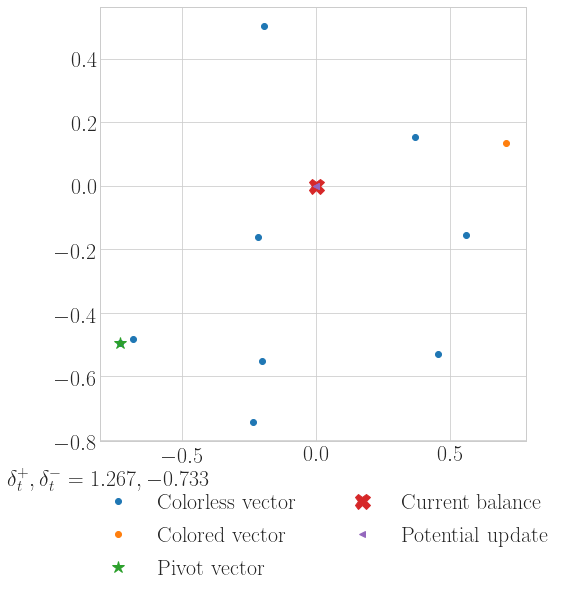

xs: [array([3.456e-01, 1.000e+00, -1.000e+00, -1.000e+00, -1.109e-01,
       4.912e-01, -2.567e-01, -2.191e-01, -3.121e-01, 3.587e-01]), array([5.808e-01, 1.000e+00, -1.000e+00, 2.307e-01, -8.928e-02, 1.000e+00,
       -7.074e-01, -5.136e-01, -8.811e-01, 8.080e-01])]
sum:[array([8.327e-17, 6.245e-17]), array([5.551e-17, 3.469e-16])]


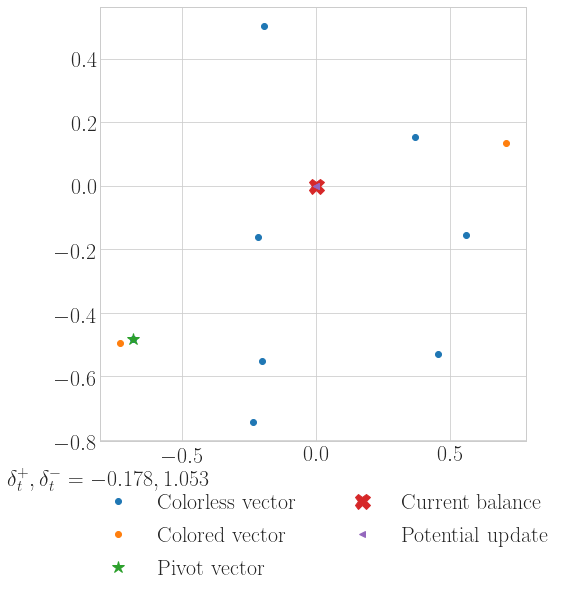

xs: [array([5.150e-01, 1.000e+00, -1.000e+00, -1.000e+00, -3.646e-01,
       3.734e-01, 1.846e-01, -2.739e-02, -1.000e+00, 1.128e-01]), array([6.030e-02, 1.000e+00, -1.000e+00, -1.000e+00, 3.165e-01, 6.896e-01,
       -1.000e+00, -5.418e-01, 8.464e-01, 7.728e-01])]
sum:[array([4.163e-17, 1.596e-16]), array([0.000e+00, 2.359e-16])]


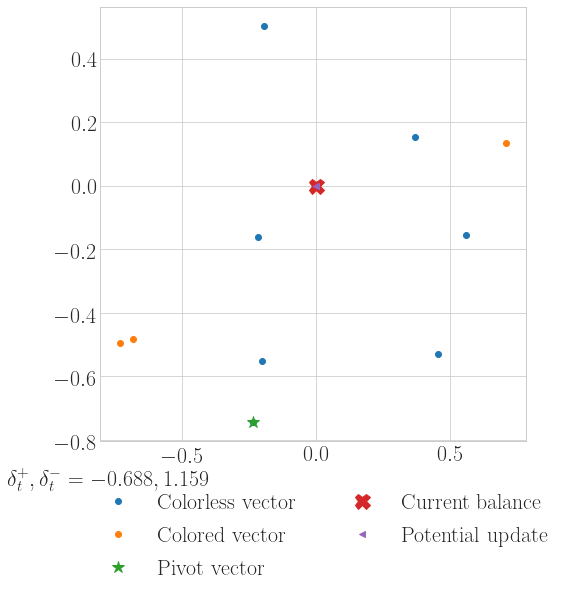

xs: [array([1.766e-01, 1.000e+00, -1.000e+00, -1.000e+00, -2.216e-01,
       1.000e+00, 3.381e-01, 1.355e-01, -1.000e+00, -1.657e-01]), array([1.000e+00, 1.000e+00, -1.000e+00, -1.000e+00, -5.695e-01,
       -5.243e-01, -3.526e-02, -2.608e-01, -1.000e+00, 5.117e-01])]
sum:[array([2.151e-16, -1.631e-16]), array([-8.327e-17, 1.527e-16])]


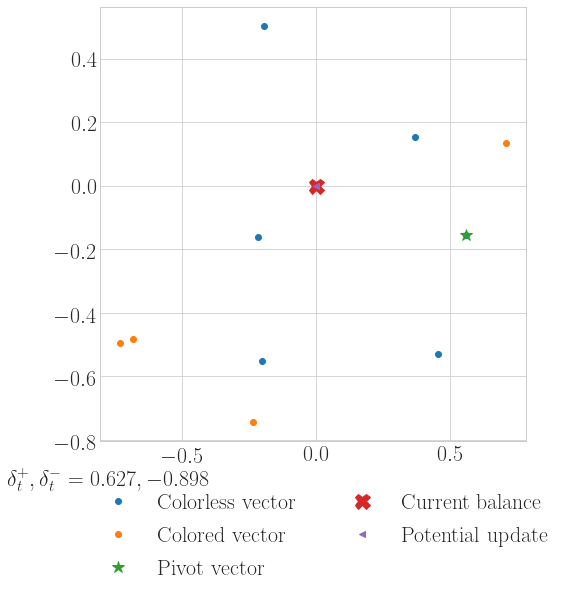

xs: [array([1.000e+00, 1.000e+00, -1.000e+00, -1.000e+00, 6.593e-01, 1.000e+00,
       1.358e-01, 3.659e-01, -1.000e+00, -6.909e-01]), array([-5.510e-01, 1.000e+00, -1.000e+00, -1.000e+00, -1.000e+00,
       1.000e+00, 5.169e-01, -6.808e-02, -1.000e+00, 2.984e-01])]
sum:[array([-1.665e-16, -6.106e-16]), array([7.910e-16, 2.082e-16])]


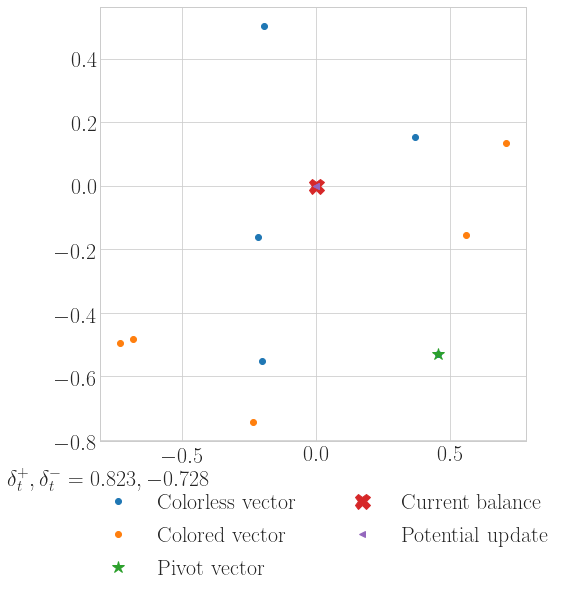

xs: [array([1.000e+00, 1.000e+00, -1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00,
       4.988e-01, 7.522e-01, -1.000e+00, -8.990e-02]), array([1.000e+00, 1.000e+00, -1.000e+00, -1.000e+00, 4.841e-01, 1.000e+00,
       -5.088e-02, 1.672e-01, -1.000e+00, -1.000e+00])]
sum:[array([-2.498e-16, -4.354e-16]), array([-1.665e-16, -5.551e-16])]


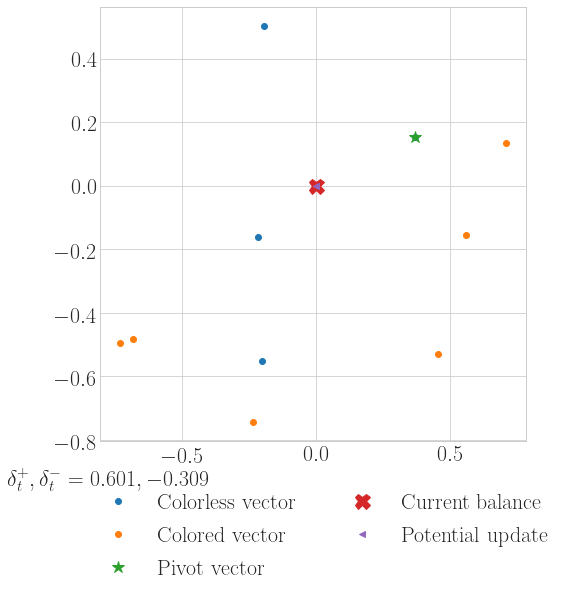

xs: [array([1.000e+00, 1.000e+00, -1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00,
       4.601e-01, 1.000e+00, -1.000e+00, 3.372e-02]), array([1.000e+00, 1.000e+00, -1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00,
       7.727e-01, -1.000e+00, -1.000e+00, -9.640e-01])]
sum:[array([-2.394e-16, -4.970e-16]), array([-5.551e-17, -2.776e-16])]


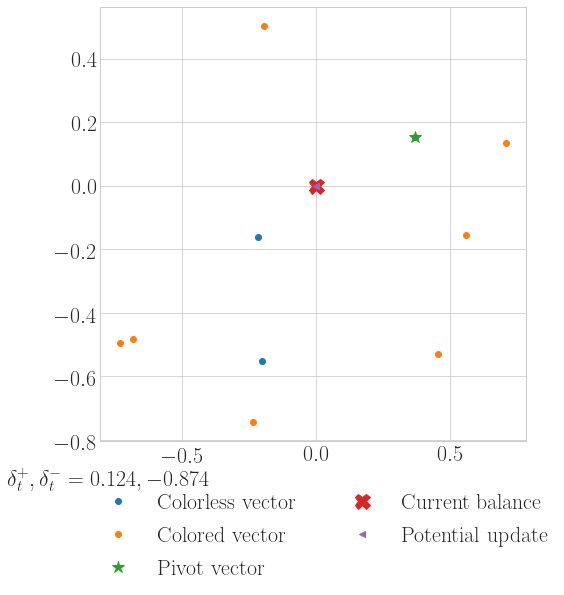

xs: [array([1.000e+00, 1.000e+00, -1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00,
       9.053e-01, 1.000e+00, -1.000e+00, 1.000e+00]), array([1.000e+00, 1.000e+00, -1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00,
       -1.631e-02, 1.000e+00, -1.000e+00, -1.000e+00])]
sum:[array([2.688e-01, -9.811e-02]), array([-2.876e-01, 1.050e-01])]


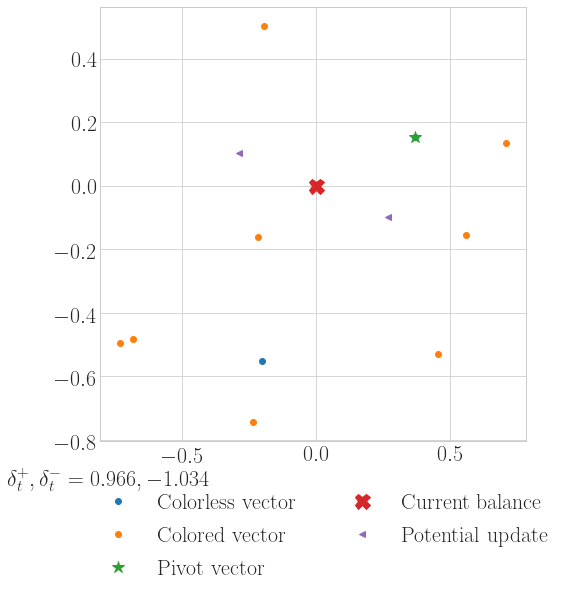

xs: [array([1.000e+00, 1.000e+00, -1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, -1.000e+00, 1.000e+00]), array([1.000e+00, 1.000e+00, -1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00,
       -1.000e+00, 1.000e+00, -1.000e+00, 1.000e+00])]
sum:[array([2.498e-01, -1.504e-01]), array([6.528e-01, 9.540e-01])]


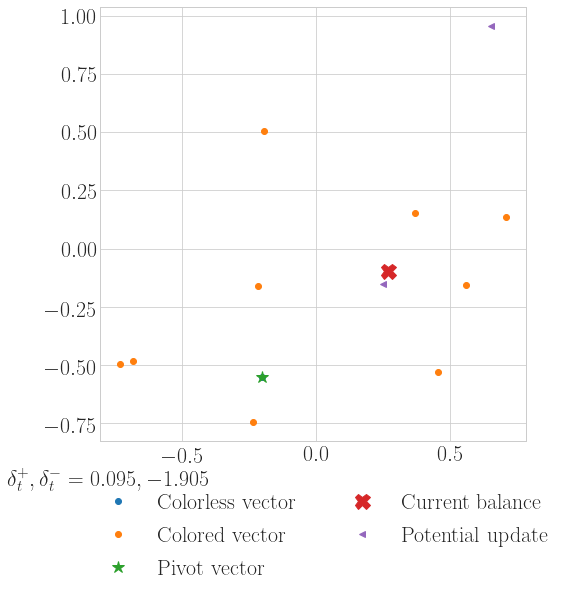

xs: [array([-3.732e-02, 3.350e-01, -2.548e-01, -1.000e+00, -4.041e-02,
       -1.472e-01, 1.767e-01, 1.022e-01, 2.262e-01, -1.495e-01]), array([3.732e-02, -3.350e-01, 2.548e-01, 1.000e+00, 4.041e-02, 1.472e-01,
       -1.767e-01, -1.022e-01, -2.262e-01, 1.495e-01])]
sum:[array([2.776e-17, 6.592e-17]), array([-2.776e-17, -6.592e-17])]


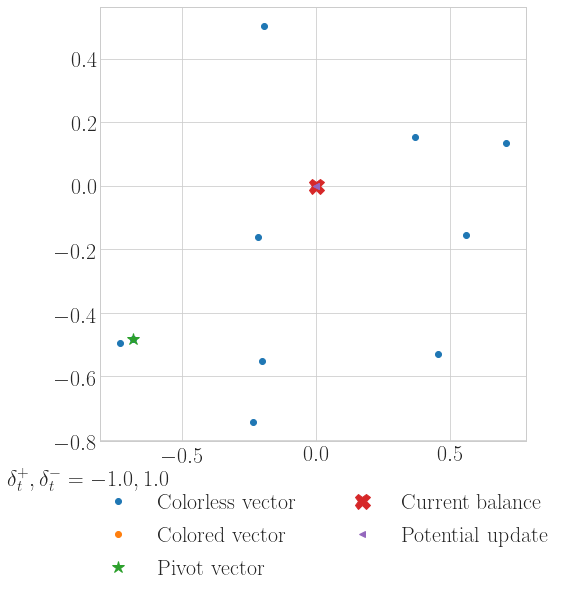

xs: [array([-2.759e-01, 6.953e-02, -1.629e-01, -1.000e+00, 1.944e-01,
       -2.016e-01, -9.638e-02, 1.601e-02, 1.000e+00, -6.228e-02]), array([3.407e-01, 7.557e-01, -4.004e-01, -1.000e+00, -4.125e-01,
       -6.104e-02, 6.095e-01, 2.388e-01, -1.000e+00, -2.878e-01])]
sum:[array([-6.939e-17, -3.868e-16]), array([2.637e-16, 6.314e-16])]


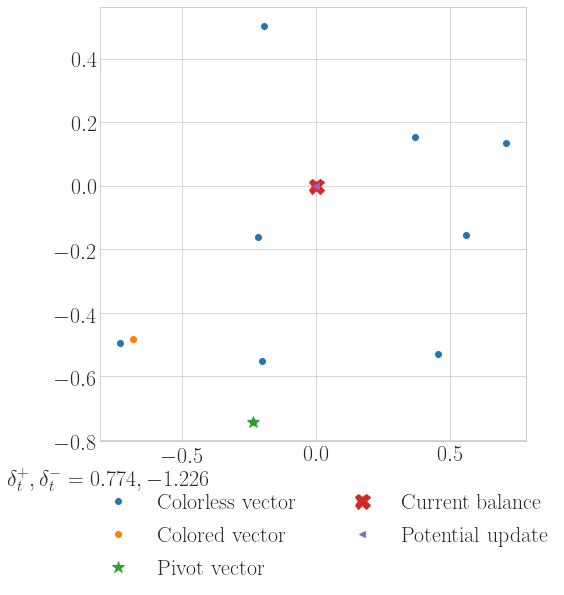

xs: [array([-6.037e-01, -3.242e-01, -1.593e-02, -1.000e+00, 5.230e-01,
       -2.657e-01, 1.000e+00, -1.113e-01, 1.000e+00, 7.010e-02]), array([-5.692e-03, 3.940e-01, -2.840e-01, -1.000e+00, -7.642e-02,
       -1.488e-01, -1.000e+00, 1.209e-01, 1.000e+00, -1.714e-01])]
sum:[array([-4.267e-16, -1.318e-16]), array([4.163e-17, -4.025e-16])]


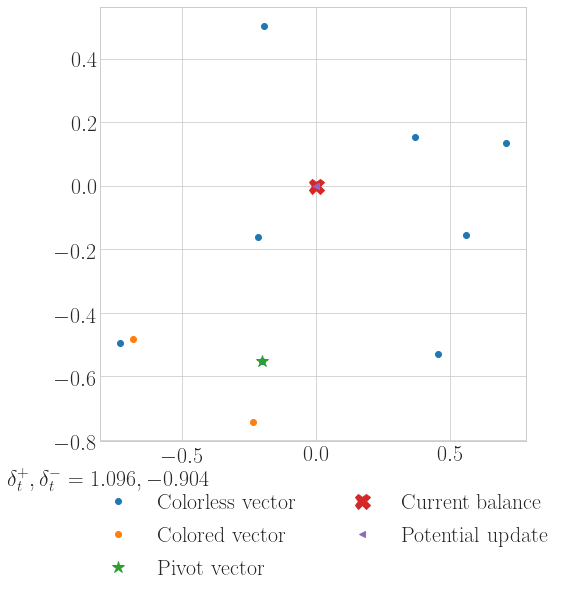

xs: [array([-3.291e-01, -1.919e-01, 2.219e-03, -1.000e+00, 1.000e+00,
       -1.392e-01, 1.000e+00, -6.536e-02, 1.000e+00, 4.482e-02]), array([-1.000e+00, -5.150e-01, -4.211e-02, -1.000e+00, -1.652e-01,
       -4.483e-01, 1.000e+00, -1.776e-01, 1.000e+00, 1.066e-01])]
sum:[array([-5.551e-16, -5.551e-17]), array([-2.012e-16, -4.372e-16])]


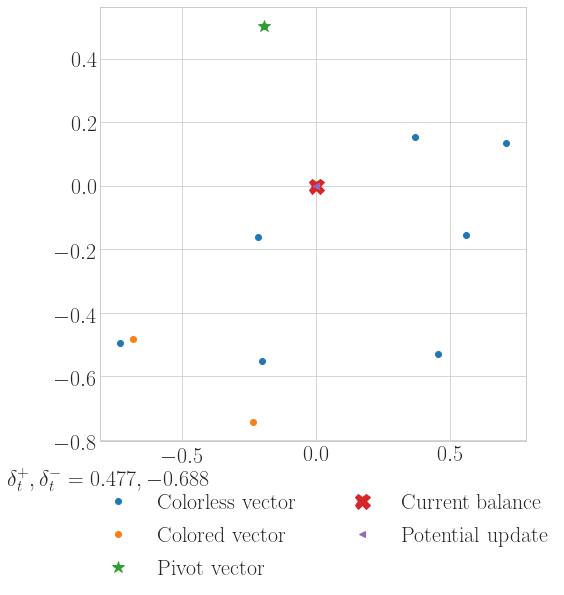

xs: [array([-9.237e-01, 1.000e+00, 9.377e-01, -1.000e+00, 1.000e+00, 8.927e-02,
       1.000e+00, -5.839e-01, 1.000e+00, 6.905e-01]), array([7.411e-02, -1.000e+00, -6.320e-01, -1.000e+00, 1.000e+00,
       -2.941e-01, 1.000e+00, 2.862e-01, 1.000e+00, -3.929e-01])]
sum:[array([-5.551e-17, 9.714e-17]), array([-7.772e-16, -3.608e-16])]


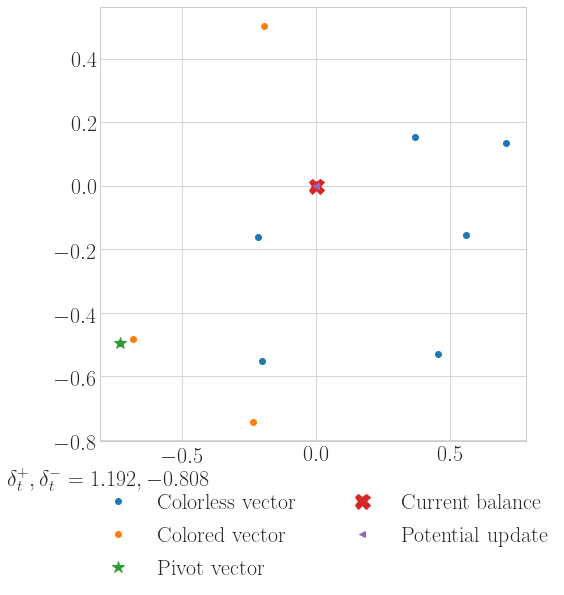

xs: [array([-1.000e+00, 1.000e+00, 8.750e-01, -1.000e+00, 1.000e+00, 2.538e-01,
       1.000e+00, -5.719e-01, 1.000e+00, 6.626e-01]), array([-8.480e-01, 1.000e+00, 1.000e+00, -1.000e+00, 1.000e+00,
       -7.419e-02, 1.000e+00, -5.958e-01, 1.000e+00, 7.183e-01])]
sum:[array([-1.943e-16, 1.527e-16]), array([-5.551e-17, 1.110e-16])]


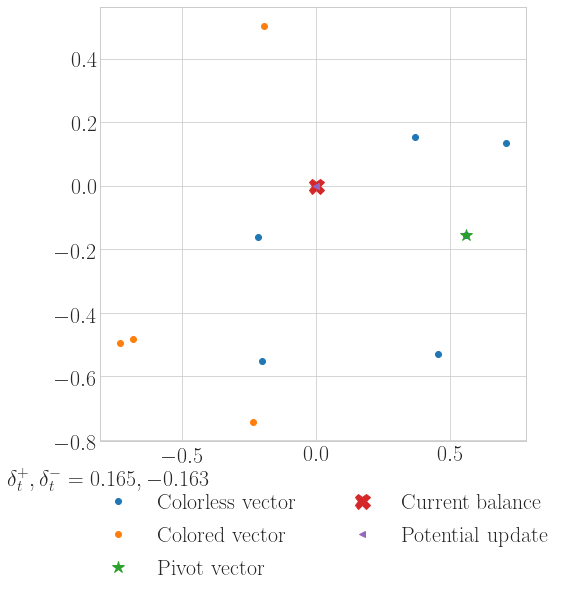

xs: [array([-1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00, 1.000e+00, 1.784e-01,
       1.000e+00, -4.406e-01, 1.000e+00, 6.135e-01]), array([-1.000e+00, 1.000e+00, 4.671e-01, -1.000e+00, 1.000e+00, 4.999e-01,
       1.000e+00, -1.000e+00, 1.000e+00, 8.226e-01])]
sum:[array([-2.776e-17, 4.163e-17]), array([-2.220e-16, 2.776e-16])]


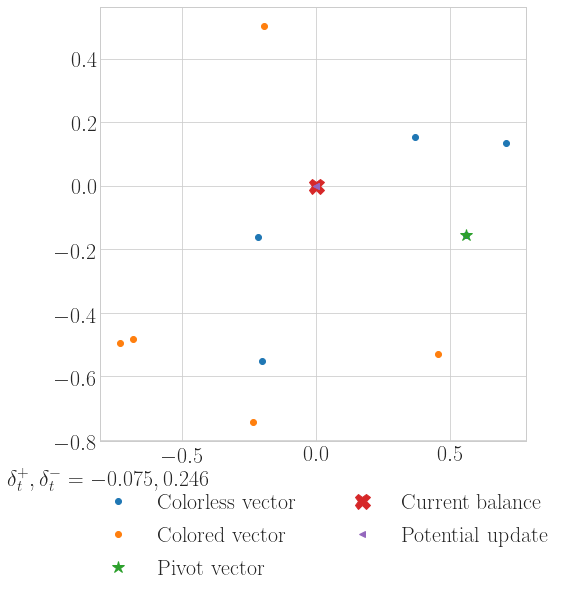

xs: [array([-1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00, 1.000e+00, 9.432e-02,
       1.000e+00, 3.557e-03, 1.000e+00, 1.000e+00]), array([-1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00, 1.000e+00, 2.844e-01,
       1.000e+00, -1.000e+00, 1.000e+00, 1.268e-01])]
sum:[array([0.000e+00, 1.110e-16]), array([-6.939e-17, 0.000e+00])]


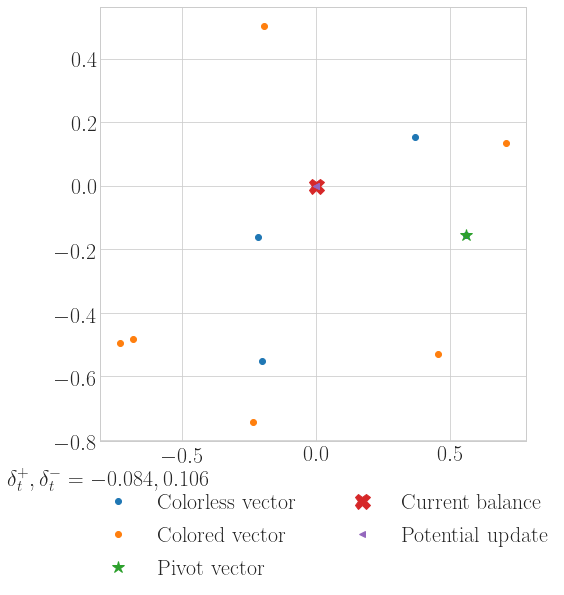

xs: [array([-1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00, 1.000e+00,
       -6.711e-01, 1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00]), array([-1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00, 1.000e+00, 8.543e-01,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00])]
sum:[array([-2.121e-01, 2.826e-01]), array([2.106e-01, -2.805e-01])]


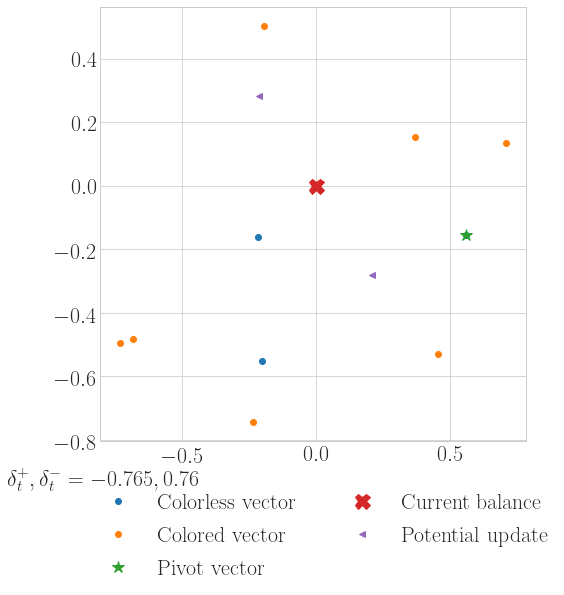

xs: [array([-1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00, 1.000e+00,
       -1.000e+00, 1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00]), array([-1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00])]
sum:[array([-3.966e-01, 3.339e-01]), array([7.256e-01, 2.190e-02])]


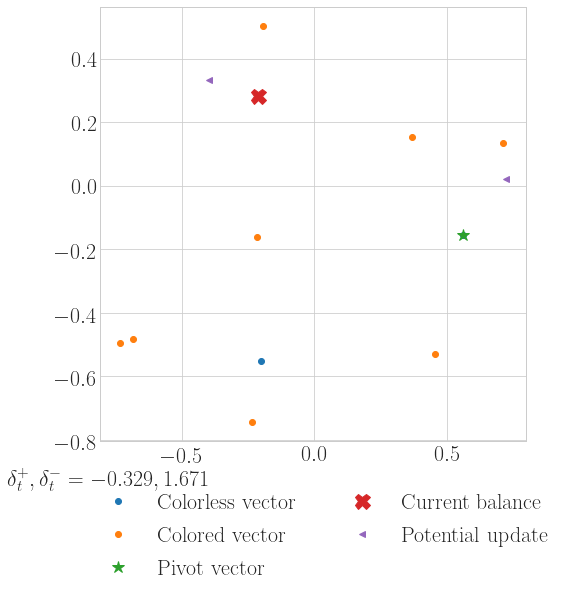

xs: [array([-5.348e-02, -1.000e+00, -2.850e-01, 3.480e-01, -3.495e-02,
       -1.697e-01, 1.879e-01, 1.120e-01, 2.398e-01, -1.657e-01]), array([5.348e-02, 1.000e+00, 2.850e-01, -3.480e-01, 3.495e-02, 1.697e-01,
       -1.879e-01, -1.120e-01, -2.398e-01, 1.657e-01])]
sum:[array([-1.735e-16, 9.021e-17]), array([1.735e-16, -9.021e-17])]


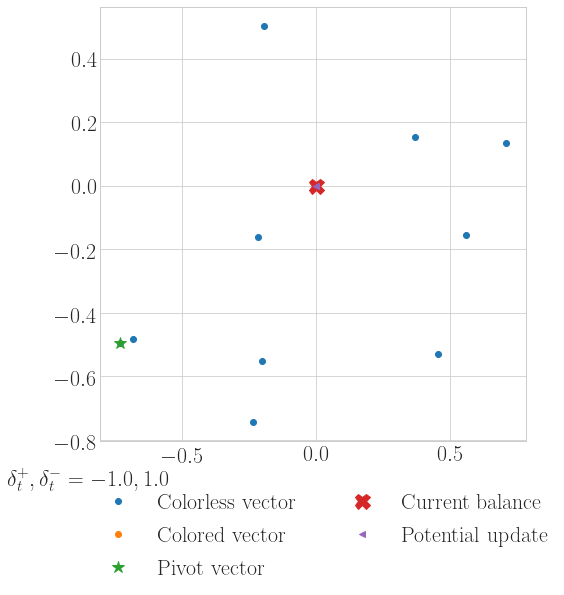

xs: [array([1.280e-01, -1.000e+00, -1.000e+00, 8.434e-02, -1.143e-01,
       5.019e-02, 1.133e-01, 2.875e-02, 1.537e-01, -2.212e-02]), array([-3.797e-01, -1.000e+00, 1.000e+00, 8.218e-01, 1.077e-01,
       -5.649e-01, 3.220e-01, 2.617e-01, 3.945e-01, -4.237e-01])]
sum:[array([-2.533e-16, 1.366e-16]), array([-3.608e-16, 2.776e-17])]


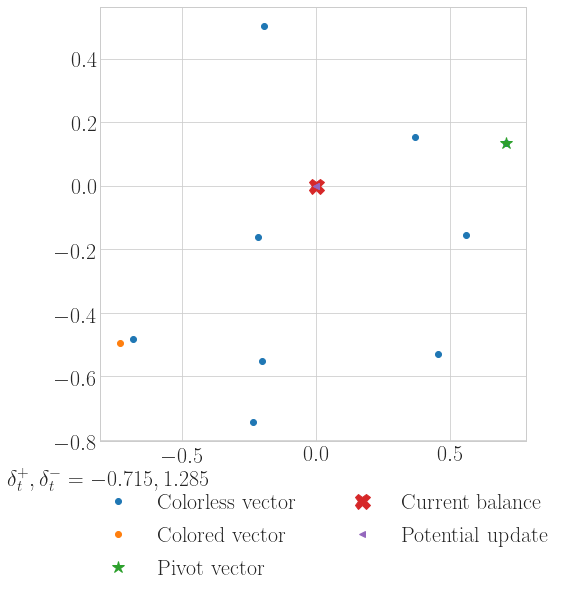

xs: [array([-8.576e-03, -1.000e+00, -1.000e+00, -1.449e-01, 3.772e-02,
       5.069e-02, 1.000e+00, -4.700e-02, -1.208e-01, 6.505e-02]), array([2.995e-01, -1.000e+00, -1.000e+00, 3.722e-01, -3.053e-01,
       4.955e-02, -1.000e+00, 1.239e-01, 4.985e-01, -1.316e-01])]
sum:[array([-1.700e-16, 3.313e-16]), array([-2.706e-16, -1.700e-16])]


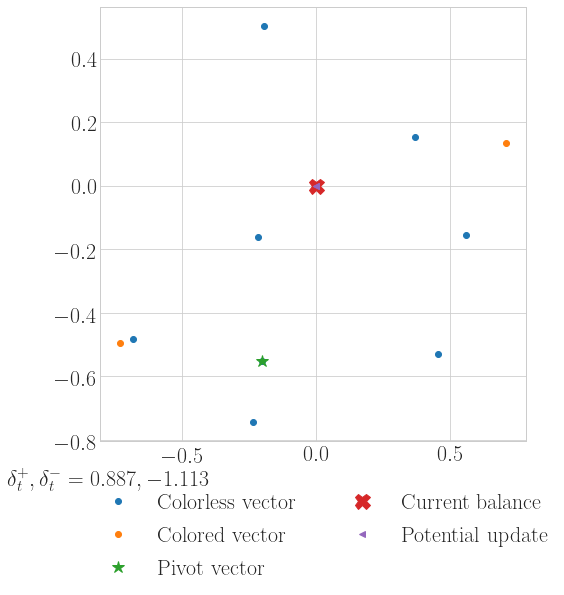

xs: [array([3.252e-01, -1.000e+00, -1.000e+00, 3.487e-01, -3.195e-01,
       7.526e-02, 1.000e+00, 1.166e-01, -1.000e+00, -1.176e-01]), array([-4.340e-01, -1.000e+00, -1.000e+00, -7.742e-01, 4.930e-01,
       1.937e-02, 1.000e+00, -2.555e-01, 1.000e+00, 2.979e-01])]
sum:[array([-9.021e-17, 2.706e-16]), array([-2.914e-16, 4.302e-16])]


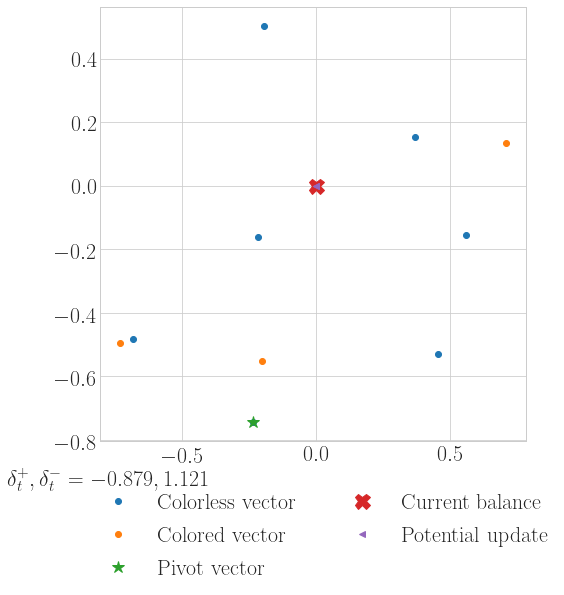

xs: [array([3.050e-01, -1.000e+00, -1.000e+00, 1.432e-01, -2.599e-01,
       1.420e-01, 1.000e+00, 1.000e+00, -1.000e+00, -2.634e-02]), array([3.507e-01, -1.000e+00, -1.000e+00, 6.085e-01, -3.947e-01,
       -9.055e-03, 1.000e+00, -1.000e+00, -1.000e+00, -2.329e-01])]
sum:[array([-2.966e-16, 4.328e-16]), array([9.714e-17, 3.192e-16])]


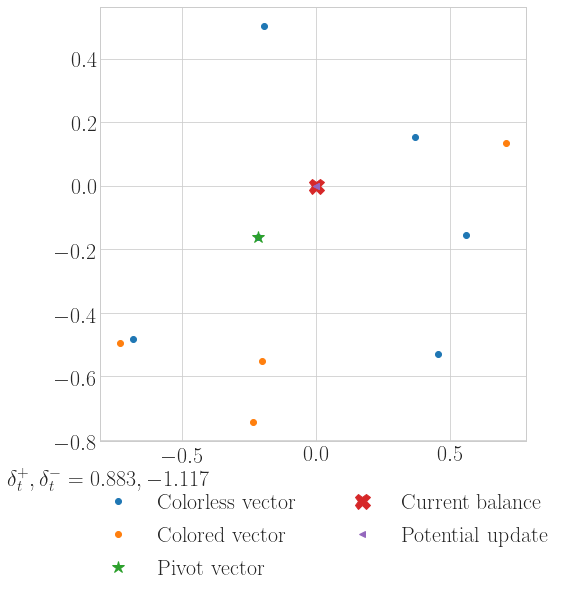

xs: [array([-6.366e-01, -1.000e+00, -1.000e+00, 2.437e-01, -1.000e+00,
       7.225e-01, 1.000e+00, 1.000e+00, -1.000e+00, 5.016e-02]), array([1.000e+00, -1.000e+00, -1.000e+00, 6.898e-02, 2.863e-01,
       -2.866e-01, 1.000e+00, 1.000e+00, -1.000e+00, -8.281e-02])]
sum:[array([-3.608e-16, 2.871e-16]), array([-1.388e-16, 4.372e-16])]


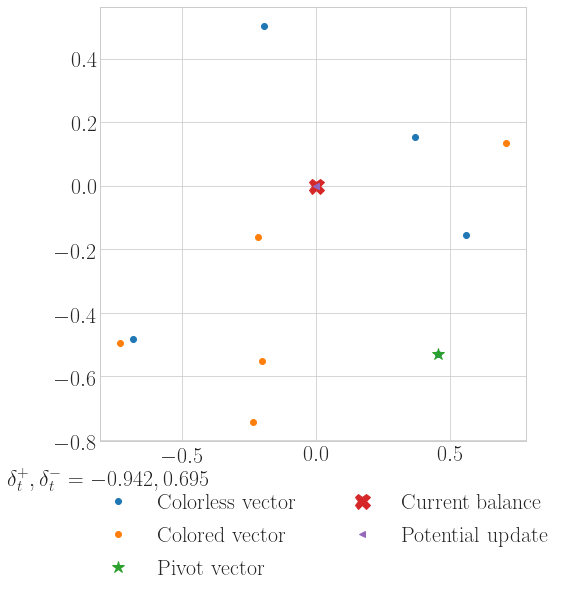

xs: [array([-8.178e-01, -1.000e+00, -1.000e+00, 3.568e-01, -1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00, 6.201e-02]), array([4.885e-01, -1.000e+00, -1.000e+00, -4.585e-01, -1.000e+00,
       -1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00, -2.340e-02])]
sum:[array([-3.816e-16, 2.741e-16]), array([-3.816e-16, 1.362e-16])]


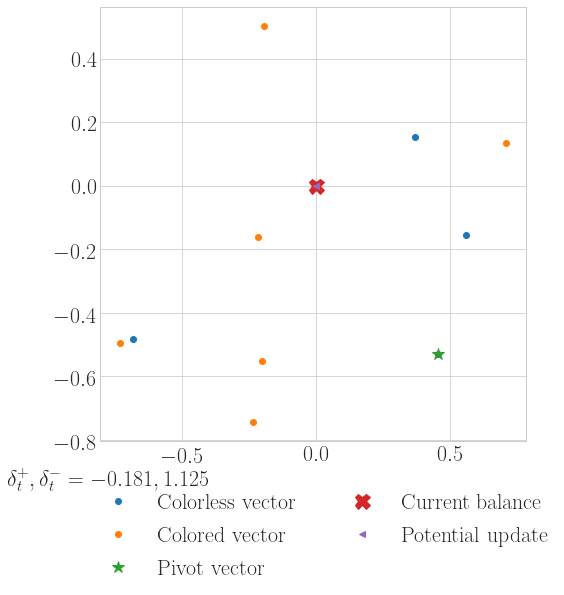

xs: [array([-6.820e-01, -1.000e+00, -1.000e+00, -1.280e-01, -1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00, -1.000e+00]), array([-9.379e-01, -1.000e+00, -1.000e+00, 7.850e-01, -1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00, 1.000e+00])]
sum:[array([-3.886e-16, 4.441e-16]), array([-5.551e-16, 3.331e-16])]


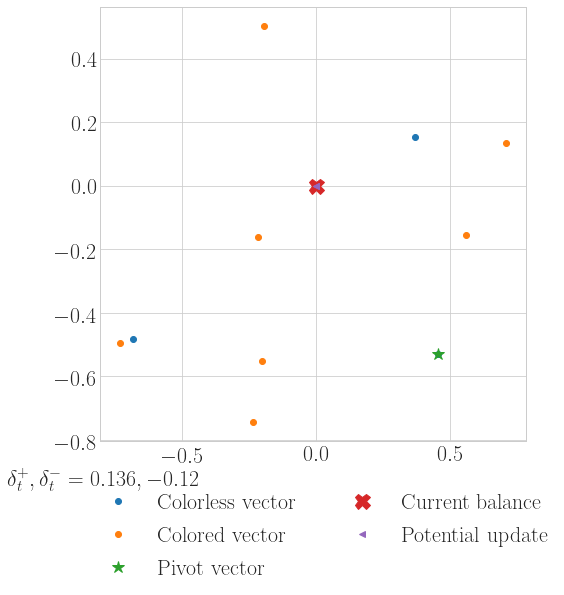

xs: [array([1.000e+00, -1.000e+00, -1.000e+00, 4.771e-03, -1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00, -1.000e+00]), array([-1.000e+00, -1.000e+00, -1.000e+00, -1.531e-01, -1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00, -1.000e+00])]
sum:[array([6.755e-01, -9.568e-01]), array([-1.277e-01, 1.809e-01])]


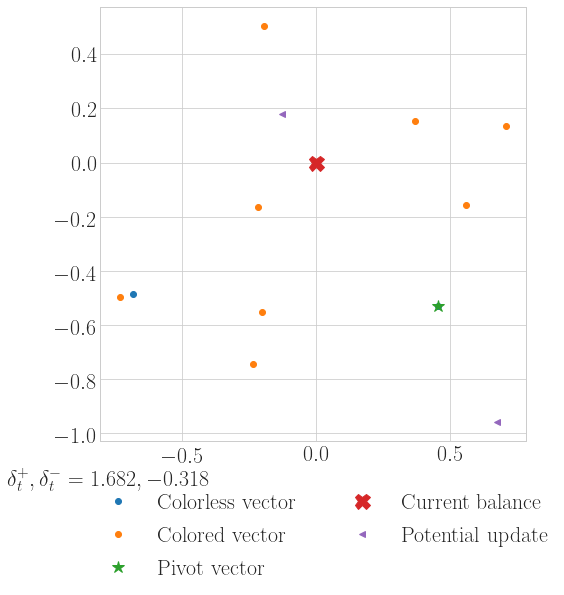

xs: [array([1.000e+00, -1.000e+00, -1.000e+00, -1.000e+00, -1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00, -1.000e+00]), array([1.000e+00, -1.000e+00, -1.000e+00, 1.000e+00, -1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00, -1.000e+00])]
sum:[array([1.364e+00, -4.708e-01]), array([-6.405e-03, -1.438e+00])]


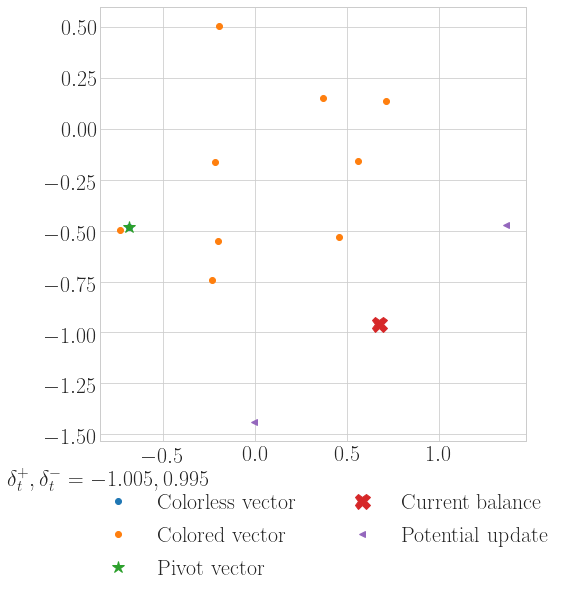

xs: [array([6.149e-02, -1.288e-01, 1.173e-01, -1.207e-01, -2.013e-02,
       8.667e-02, -4.452e-02, -3.836e-02, -5.402e-02, -1.000e+00]), array([-6.149e-02, 1.288e-01, -1.173e-01, 1.207e-01, 2.013e-02,
       -8.667e-02, 4.452e-02, 3.836e-02, 5.402e-02, 1.000e+00])]
sum:[array([3.886e-16, 2.776e-17]), array([-3.886e-16, -2.776e-17])]


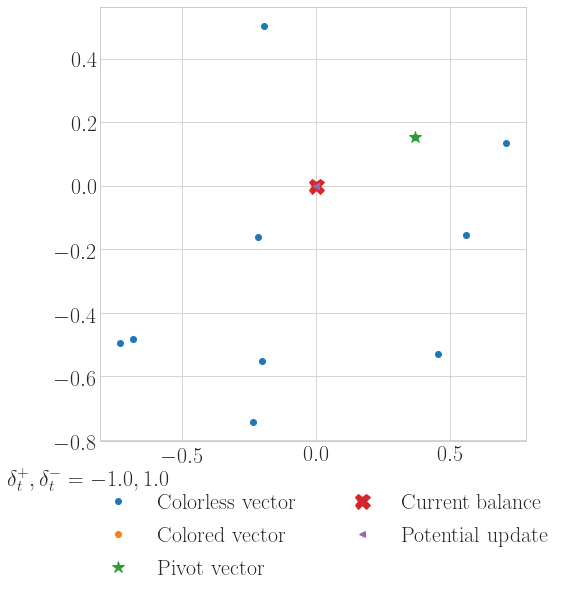

xs: [array([3.428e-01, 1.119e-01, 6.060e-02, 1.148e-01, -2.822e-01, 1.775e-01,
       2.353e-01, 4.104e-02, -1.000e+00, -1.000e+00]), array([-2.519e-01, -3.969e-01, 1.804e-01, -3.830e-01, 2.718e-01,
       -1.449e-02, -3.563e-01, -1.268e-01, 1.000e+00, -1.000e+00])]
sum:[array([2.220e-16, -2.220e-16]), array([5.551e-16, 3.331e-16])]


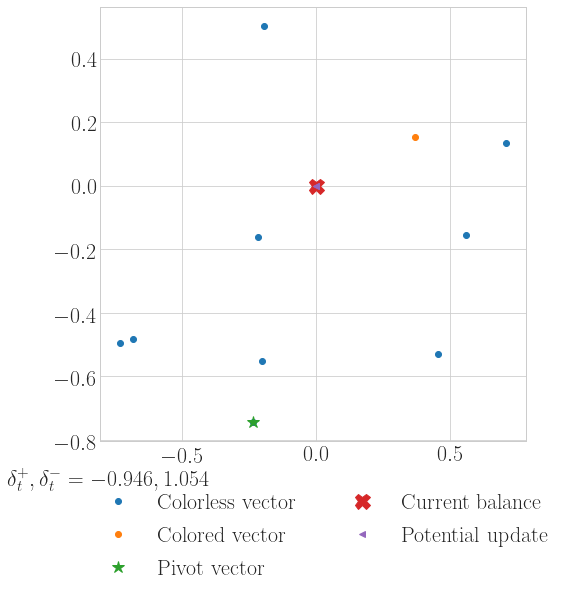

xs: [array([5.729e-01, -2.117e-01, -1.000e+00, -1.866e-01, -3.899e-01,
       4.435e-01, 1.609e-01, -5.390e-02, -1.000e+00, -1.000e+00]), array([1.389e-01, 3.985e-01, 1.000e+00, 3.817e-01, -1.867e-01, -5.817e-02,
       3.012e-01, 1.251e-01, -1.000e+00, -1.000e+00])]
sum:[array([7.216e-16, -2.220e-16]), array([-1.665e-16, -2.220e-16])]


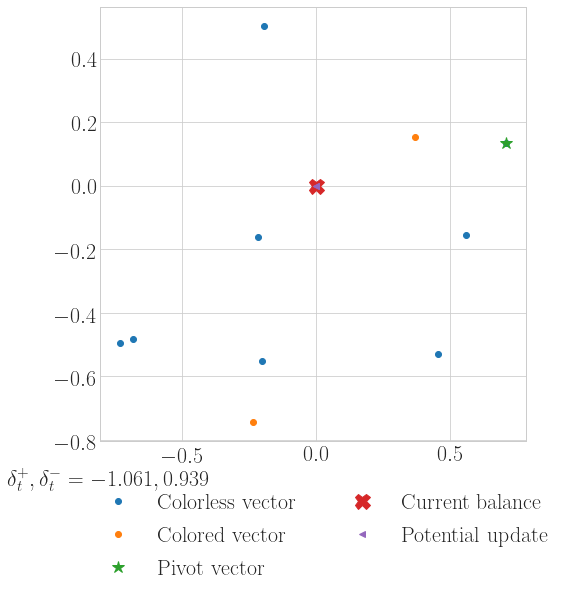

xs: [array([1.000e+00, -1.481e-01, -1.000e+00, -1.156e-01, 5.514e-01,
       6.926e-01, 4.099e-01, -2.608e-02, -1.000e+00, -1.000e+00]), array([2.960e-01, -2.529e-01, -1.000e+00, -2.326e-01, -1.000e+00,
       2.820e-01, -4.632e-04, -7.194e-02, -1.000e+00, -1.000e+00])]
sum:[array([9.437e-16, -1.110e-16]), array([5.551e-16, -3.331e-16])]


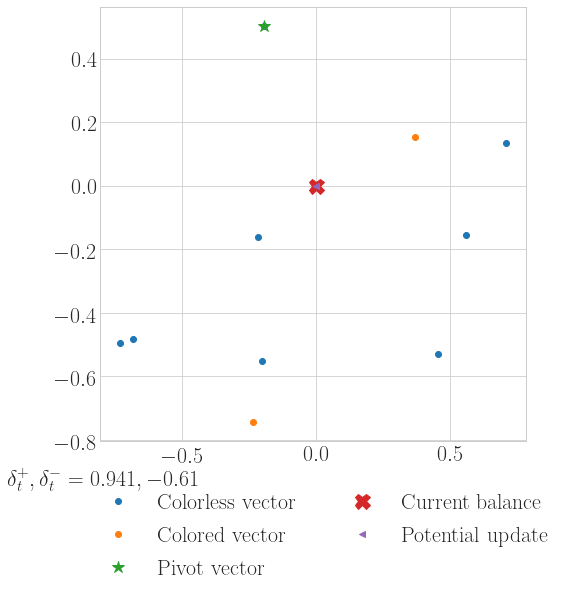

xs: [array([1.000e+00, -1.293e-01, -1.000e+00, -8.542e-02, 9.797e-01,
       1.000e+00, 6.654e-01, -1.073e-02, -1.000e+00, -1.000e+00]), array([1.000e+00, -2.162e-01, -1.000e+00, -2.248e-01, -1.000e+00,
       -4.209e-01, -5.153e-01, -8.167e-02, -1.000e+00, -1.000e+00])]
sum:[array([8.882e-16, -1.110e-16]), array([1.055e-15, 3.331e-16])]


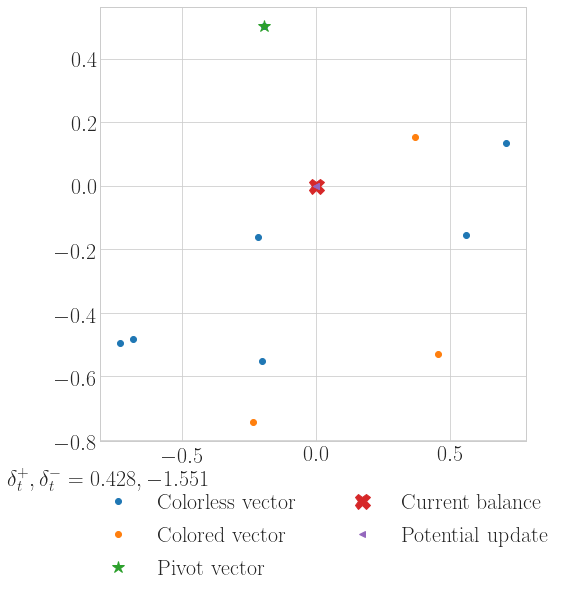

xs: [array([1.000e+00, -1.374e-01, -1.000e+00, -9.134e-02, 1.000e+00,
       1.000e+00, 6.967e-01, -1.182e-02, -1.000e+00, -1.000e+00]), array([1.000e+00, 3.036e-01, -1.000e+00, 2.289e-01, -1.011e-01, 1.000e+00,
       -1.000e+00, 4.722e-02, -1.000e+00, -1.000e+00])]
sum:[array([9.992e-16, -3.331e-16]), array([8.882e-16, -3.331e-16])]


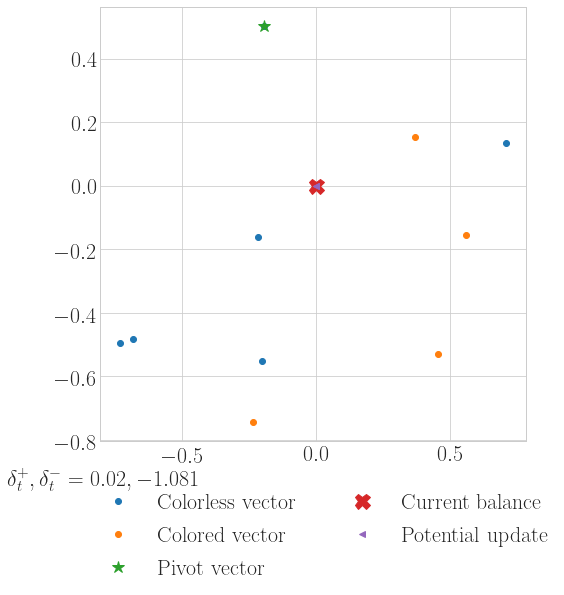

xs: [array([1.000e+00, -1.000e+00, -1.000e+00, 9.228e-01, 1.000e+00, 1.000e+00,
       6.553e-01, -2.588e-01, -1.000e+00, -1.000e+00]), array([1.000e+00, 6.354e-01, -1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00,
       7.338e-01, 2.095e-01, -1.000e+00, -1.000e+00])]
sum:[array([1.443e-15, -3.331e-16]), array([6.106e-16, -4.441e-16])]


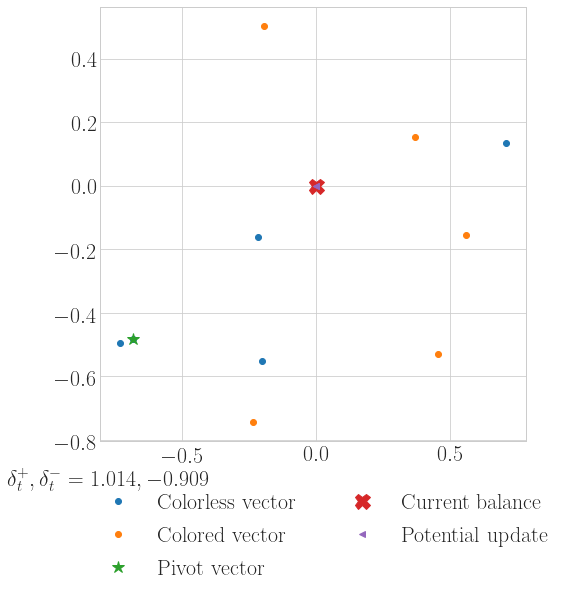

xs: [array([1.000e+00, -1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       6.612e-01, -5.085e-01, -1.000e+00, -1.000e+00]), array([1.000e+00, -1.000e+00, -1.000e+00, 5.335e-01, 1.000e+00, 1.000e+00,
       6.256e-01, 1.000e+00, -1.000e+00, -1.000e+00])]
sum:[array([1.332e-15, -1.110e-16]), array([1.277e-15, -3.331e-16])]


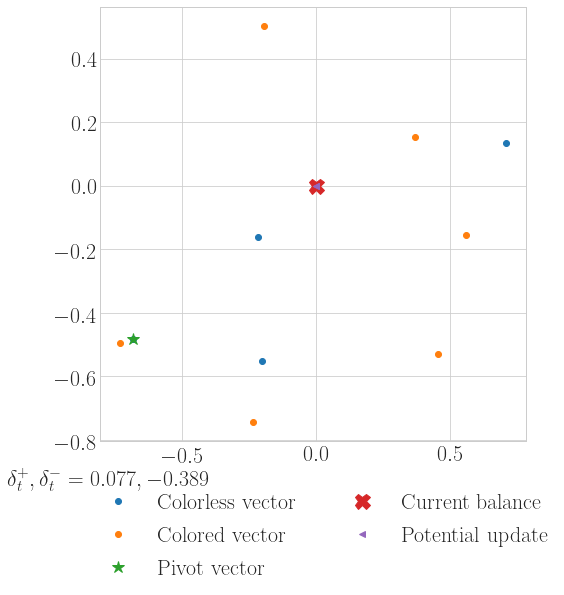

xs: [array([1.000e+00, -1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       9.314e-01, -1.000e+00, -1.000e+00, -1.000e+00]), array([1.000e+00, -1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       -1.682e-01, 1.000e+00, -1.000e+00, -1.000e+00])]
sum:[array([5.201e-02, -6.929e-02]), array([-1.596e-01, 2.127e-01])]


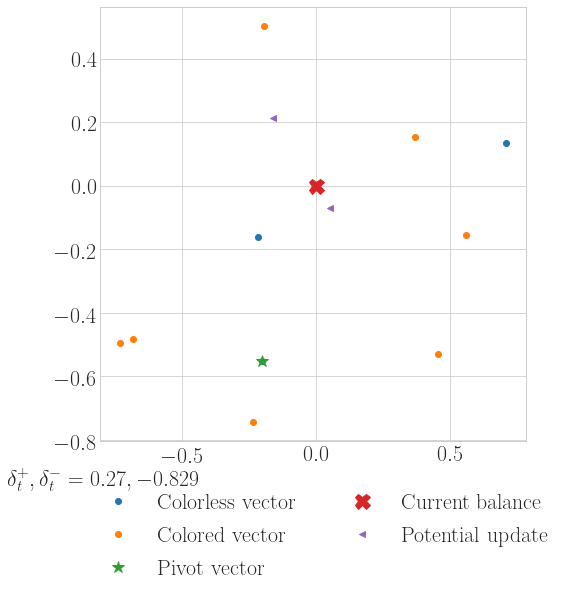

xs: [array([1.000e+00, -1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, -1.000e+00, -1.000e+00, -1.000e+00]), array([1.000e+00, -1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       -1.000e+00, -1.000e+00, -1.000e+00, -1.000e+00])]
sum:[array([3.819e-02, -1.072e-01]), array([4.412e-01, 9.972e-01])]


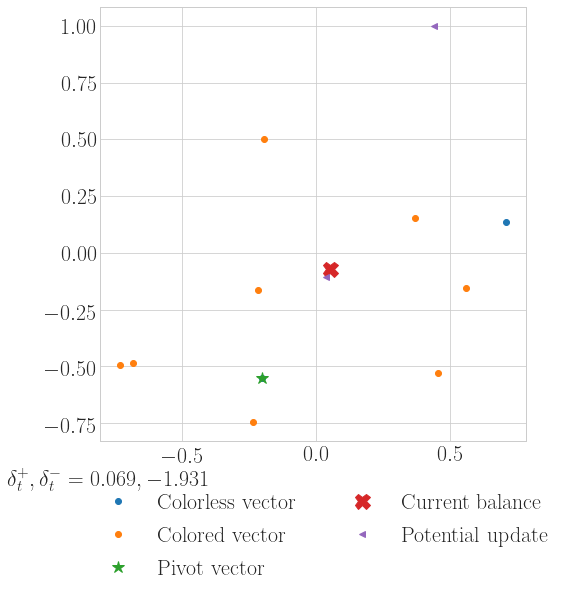

xs: [array([5.348e-02, 1.000e+00, 2.850e-01, -3.480e-01, 3.495e-02, 1.697e-01,
       -1.879e-01, -1.120e-01, -2.398e-01, 1.657e-01]), array([-5.348e-02, -1.000e+00, -2.850e-01, 3.480e-01, -3.495e-02,
       -1.697e-01, 1.879e-01, 1.120e-01, 2.398e-01, -1.657e-01])]
sum:[array([1.735e-16, -9.021e-17]), array([-1.735e-16, 9.021e-17])]


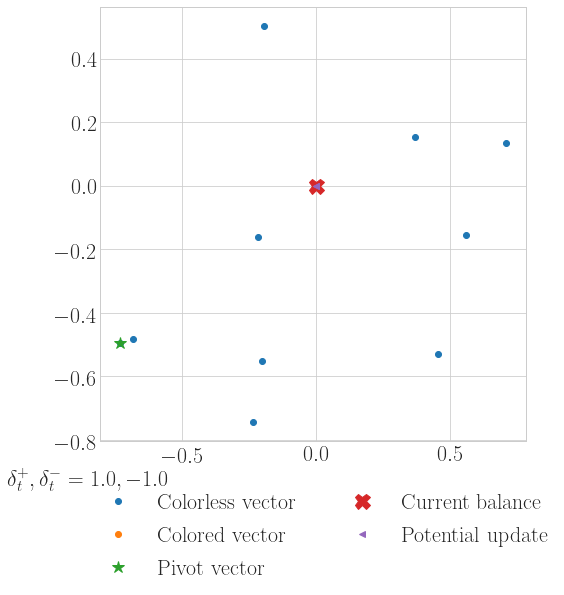

xs: [array([2.856e-01, 1.000e+00, 1.873e-01, -8.601e-02, -1.959e-01, 2.184e-01,
       8.455e-02, -2.460e-02, -1.000e+00, 7.581e-02]), array([-3.251e-01, 1.000e+00, 4.443e-01, -7.752e-01, 4.115e-01, 9.033e-02,
       -6.323e-01, -2.546e-01, 1.000e+00, 3.123e-01])]
sum:[array([3.018e-16, -1.232e-16]), array([2.776e-16, 2.012e-16])]


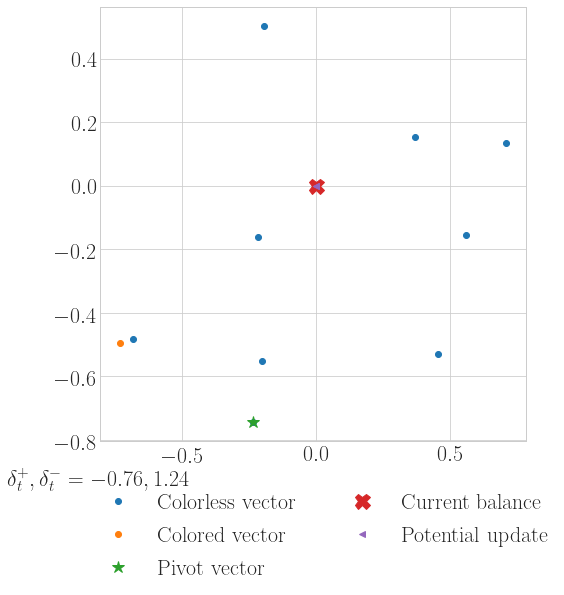

xs: [array([8.030e-01, 1.000e+00, 2.745e-01, 9.296e-02, 1.000e+00, 4.840e-01,
       4.432e-01, 3.919e-02, -1.000e+00, 6.031e-02]), array([-6.225e-02, 1.000e+00, 1.287e-01, -2.063e-01, -1.000e+00,
       3.977e-02, -1.566e-01, -6.750e-02, -1.000e+00, 8.623e-02])]
sum:[array([6.210e-16, -5.326e-16]), array([0.000e+00, -1.180e-16])]


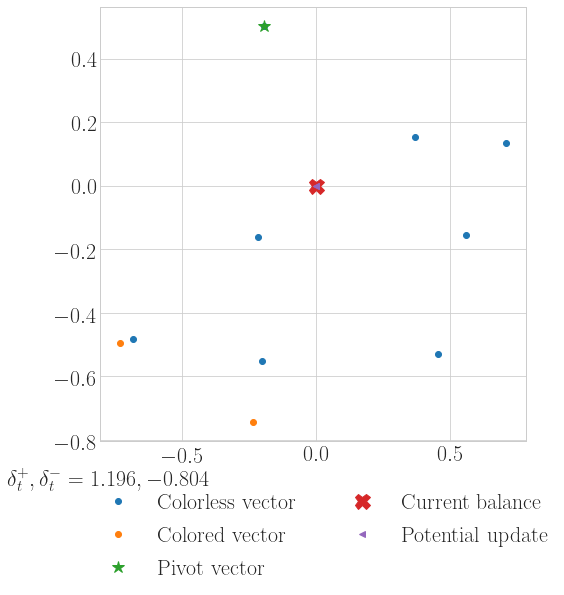

xs: [array([6.816e-01, 1.000e+00, 7.293e-01, 1.000e+00, 1.000e+00, 6.666e-01,
       -2.839e-02, -1.801e-01, -1.000e+00, 3.520e-01]), array([9.464e-01, 1.000e+00, -2.624e-01, -9.778e-01, 1.000e+00, 2.685e-01,
       1.000e+00, 2.980e-01, -1.000e+00, -2.841e-01])]
sum:[array([4.163e-16, -7.425e-16]), array([6.245e-16, -3.400e-16])]


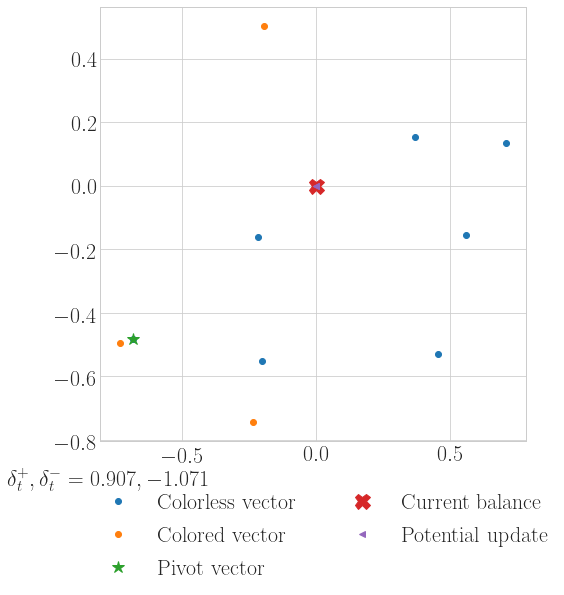

xs: [array([6.135e-01, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 5.288e-01,
       8.721e-02, -1.026e-01, -1.000e+00, 2.330e-01]), array([8.462e-01, 1.000e+00, 7.467e-02, 1.000e+00, 1.000e+00, 1.000e+00,
       -3.079e-01, -3.673e-01, -1.000e+00, 6.398e-01])]
sum:[array([3.886e-16, -6.661e-16]), array([3.331e-16, -5.967e-16])]


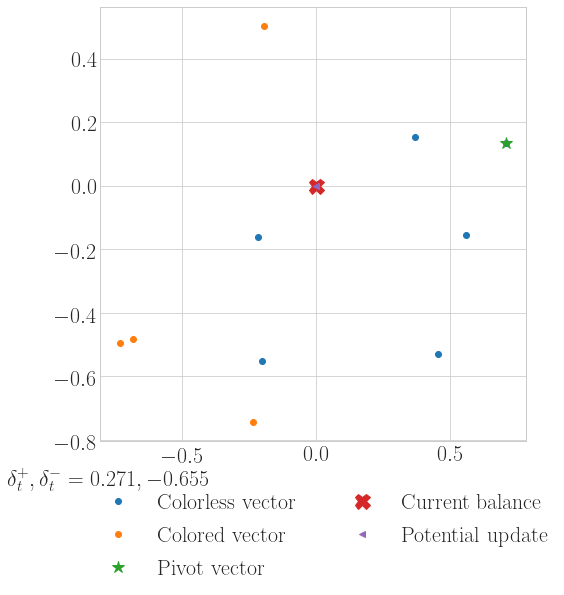

xs: [array([1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, -4.576e-02,
       -8.018e-03, -2.464e-01, -1.000e+00, 4.915e-01]), array([2.965e-01, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.653e-01, 1.534e-02, -1.000e+00, 2.105e-02])]
sum:[array([5.274e-16, -7.910e-16]), array([3.105e-16, -7.277e-16])]


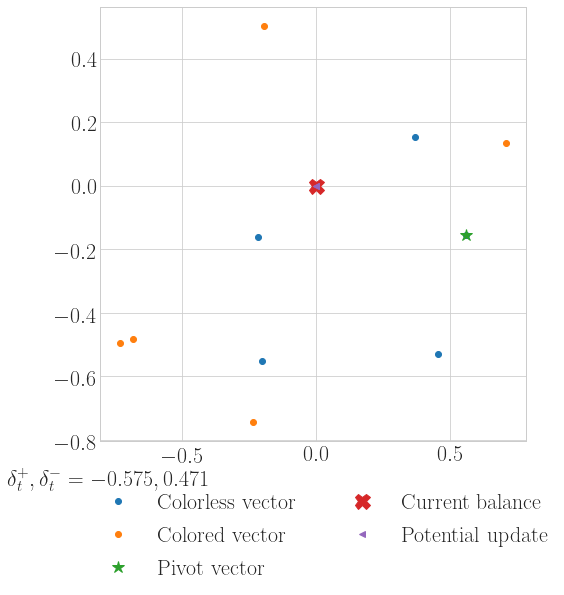

xs: [array([1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, -3.582e-01,
       2.824e-01, -4.547e-01, -1.000e+00, 1.000e+00]), array([1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 8.706e-01,
       -8.598e-01, 3.645e-01, -1.000e+00, -1.000e+00])]
sum:[array([5.551e-16, -7.772e-16]), array([5.551e-16, -8.882e-16])]


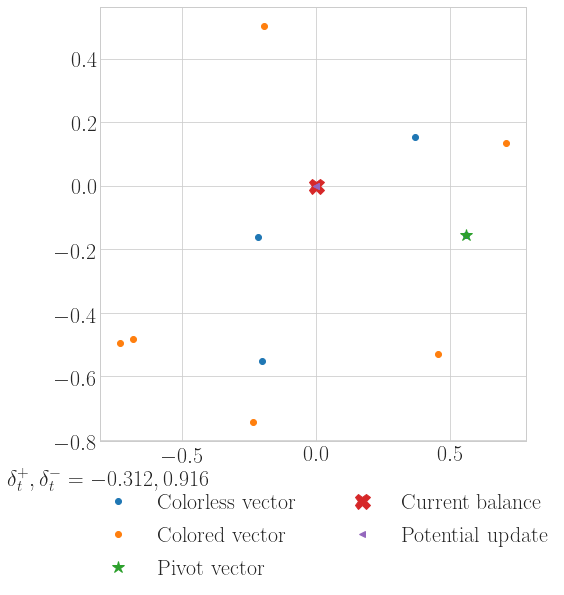

xs: [array([1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, -4.969e-01,
       4.822e-01, -1.000e+00, -1.000e+00, 1.000e+00]), array([1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.203e-02,
       -2.505e-01, 1.000e+00, -1.000e+00, 1.000e+00])]
sum:[array([5.551e-16, -7.772e-16]), array([5.551e-16, -9.992e-16])]


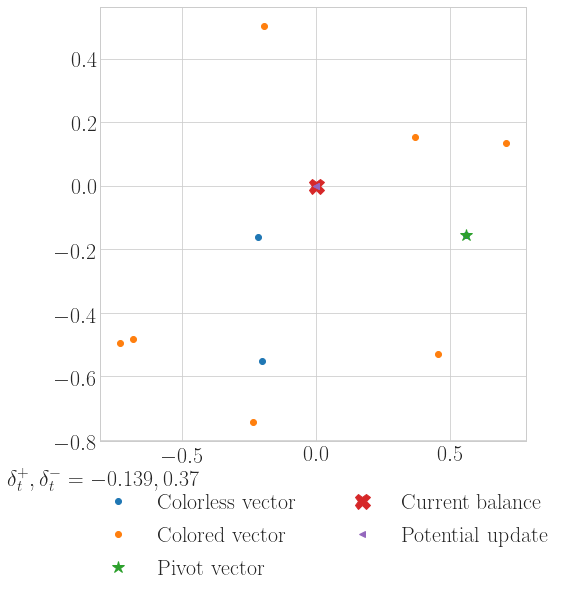

xs: [array([1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00,
       4.429e-01, -1.000e+00, -1.000e+00, 1.000e+00]), array([1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       5.989e-01, -1.000e+00, -1.000e+00, 1.000e+00])]
sum:[array([-2.744e-01, 1.001e-01]), array([8.164e-01, -2.980e-01])]


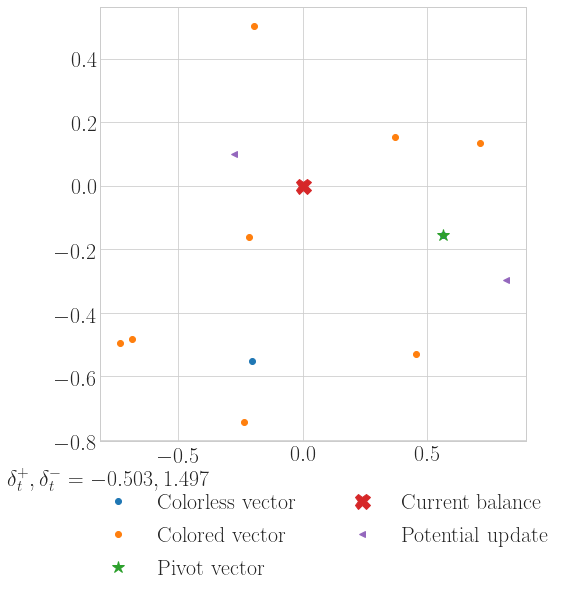

xs: [array([1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00,
       1.000e+00, -1.000e+00, -1.000e+00, 1.000e+00]), array([1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00,
       -1.000e+00, -1.000e+00, -1.000e+00, 1.000e+00])]
sum:[array([-3.866e-01, -2.075e-01]), array([1.642e-02, 8.969e-01])]


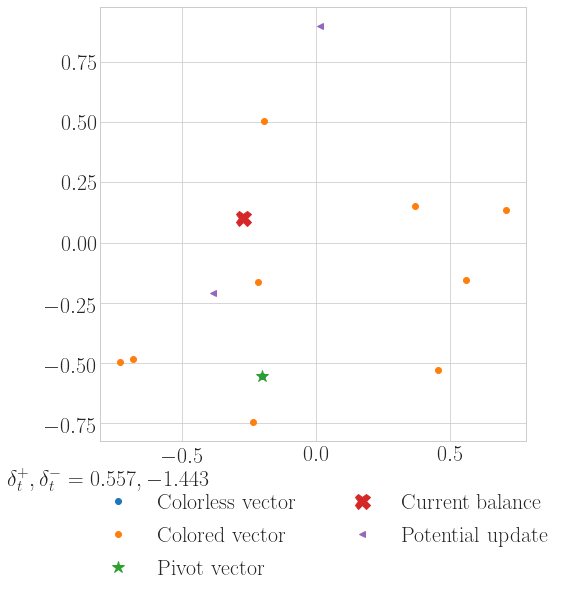

xs: [array([3.005e-01, 2.443e-01, -5.135e-02, 2.394e-01, -2.774e-01, 1.017e-01,
       2.915e-01, 8.090e-02, -1.000e+00, -7.084e-02]), array([-3.005e-01, -2.443e-01, 5.135e-02, -2.394e-01, 2.774e-01,
       -1.017e-01, -2.915e-01, -8.090e-02, 1.000e+00, 7.084e-02])]
sum:[array([-5.898e-17, -1.180e-16]), array([5.898e-17, 1.180e-16])]


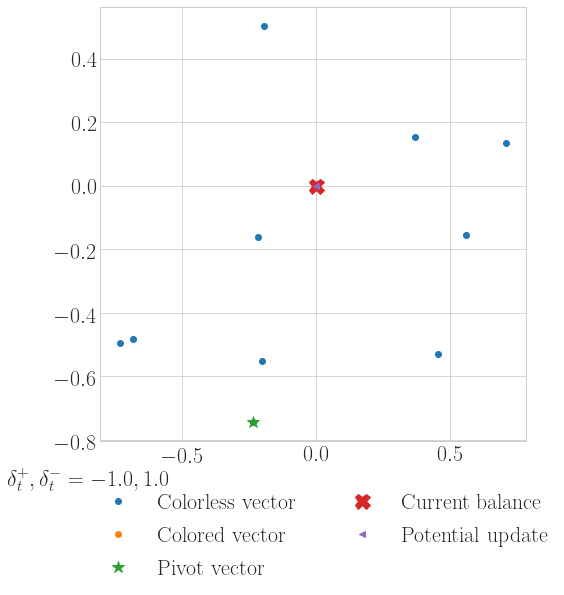

xs: [array([3.428e-01, 1.119e-01, 6.060e-02, 1.148e-01, -2.822e-01, 1.775e-01,
       2.353e-01, 4.104e-02, -1.000e+00, -1.000e+00]), array([2.519e-01, 3.969e-01, -1.804e-01, 3.830e-01, -2.718e-01, 1.449e-02,
       3.563e-01, 1.268e-01, -1.000e+00, 1.000e+00])]
sum:[array([1.110e-16, 0.000e+00]), array([-1.665e-16, -2.498e-16])]


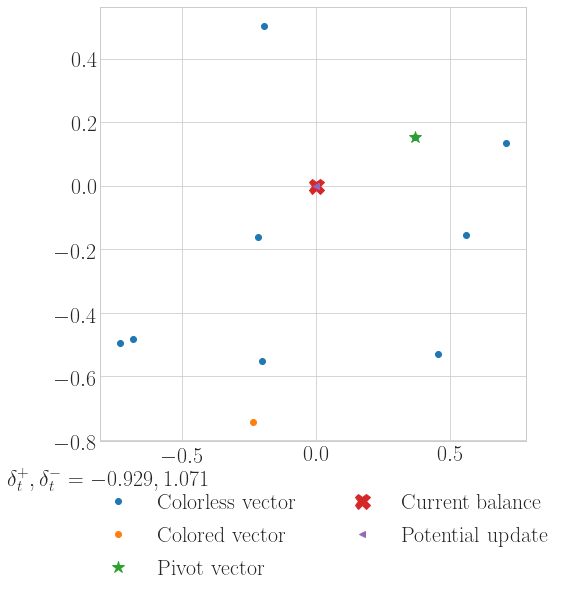

xs: [array([1.389e-01, 3.985e-01, 1.000e+00, 3.817e-01, -1.867e-01, -5.817e-02,
       3.012e-01, 1.251e-01, -1.000e+00, -1.000e+00]), array([5.729e-01, -2.117e-01, -1.000e+00, -1.866e-01, -3.899e-01,
       4.435e-01, 1.609e-01, -5.390e-02, -1.000e+00, -1.000e+00])]
sum:[array([-3.331e-16, -1.110e-16]), array([5.551e-16, 0.000e+00])]


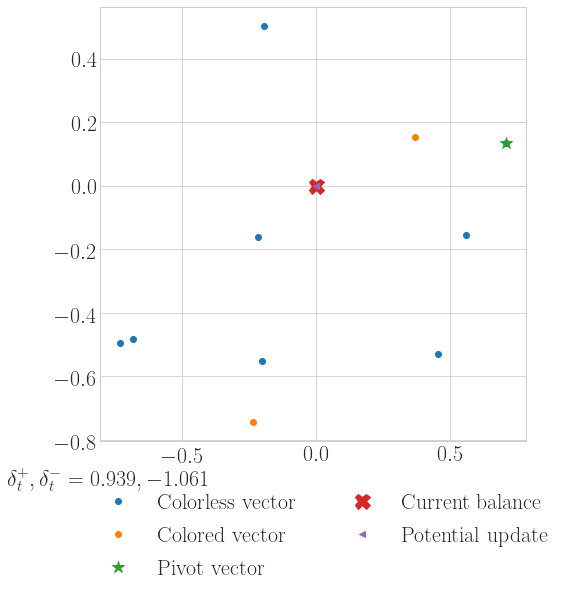

xs: [array([1.676e-01, 3.058e-02, 1.000e+00, 1.000e+00, -1.330e-01, 9.563e-02,
       1.010e-01, 1.265e-02, -1.000e+00, -1.000e+00]), array([9.218e-02, 1.000e+00, 1.000e+00, -6.290e-01, -2.746e-01,
       -3.096e-01, 6.285e-01, 3.090e-01, -1.000e+00, -1.000e+00])]
sum:[array([0.000e+00, -2.220e-16]), array([-7.772e-16, 0.000e+00])]


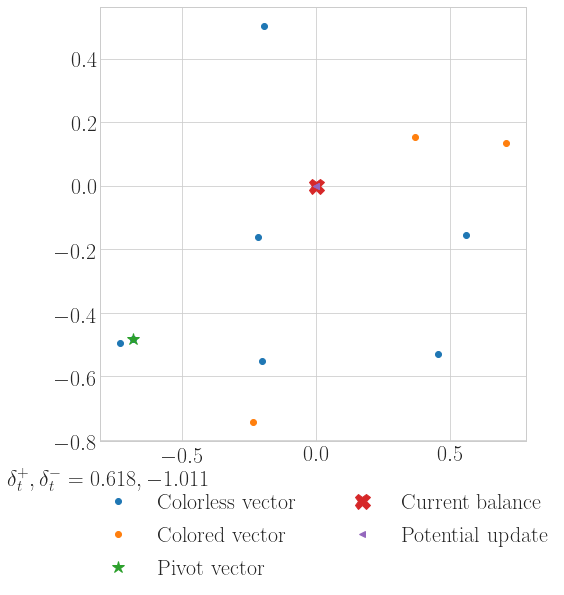

xs: [array([6.565e-01, -3.920e-01, 1.000e+00, 1.000e+00, -4.162e-01,
       -1.000e+00, 9.733e-02, -1.077e-01, -1.000e+00, -1.000e+00]), array([-2.360e-01, 3.794e-01, 1.000e+00, 1.000e+00, 1.008e-01, 1.000e+00,
       1.040e-01, 1.120e-01, -1.000e+00, -1.000e+00])]
sum:[array([2.220e-16, -1.110e-16]), array([-3.331e-16, -1.110e-16])]


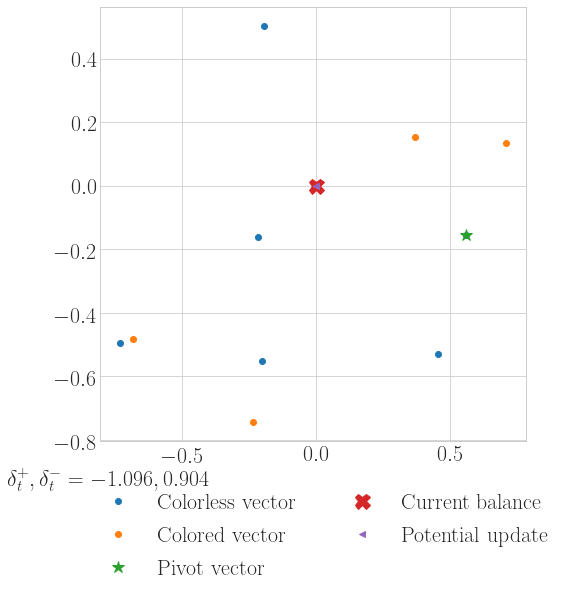

xs: [array([8.321e-02, -6.486e-01, 1.000e+00, 1.000e+00, -1.000e+00,
       -1.000e+00, 3.653e-01, -1.702e-01, -1.000e+00, -1.000e+00]), array([1.000e+00, -2.383e-01, 1.000e+00, 1.000e+00, -6.646e-02,
       -1.000e+00, -6.323e-02, -7.025e-02, -1.000e+00, -1.000e+00])]
sum:[array([0.000e+00, -3.331e-16]), array([2.220e-16, -1.110e-16])]


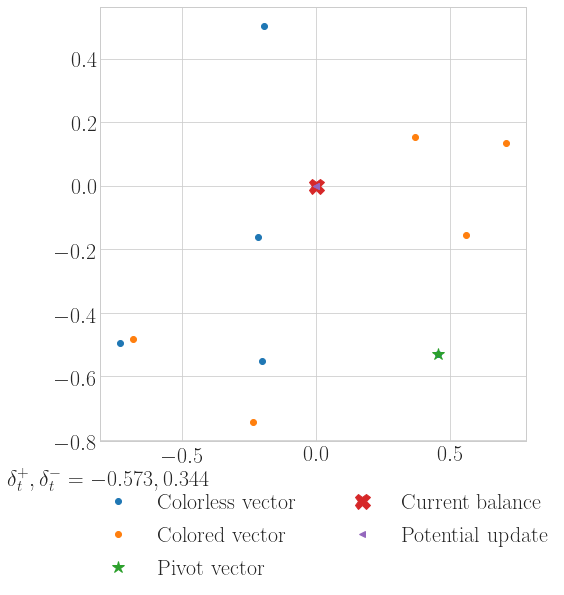

xs: [array([-2.303e-01, -9.957e-01, 1.000e+00, 1.000e+00, -1.000e+00,
       -1.000e+00, 1.000e+00, -2.441e-01, -1.000e+00, -1.000e+00]), array([7.576e-01, 9.822e-02, 1.000e+00, 1.000e+00, -1.000e+00, -1.000e+00,
       -1.000e+00, -1.120e-02, -1.000e+00, -1.000e+00])]
sum:[array([1.110e-16, -3.331e-16]), array([0.000e+00, -5.551e-16])]


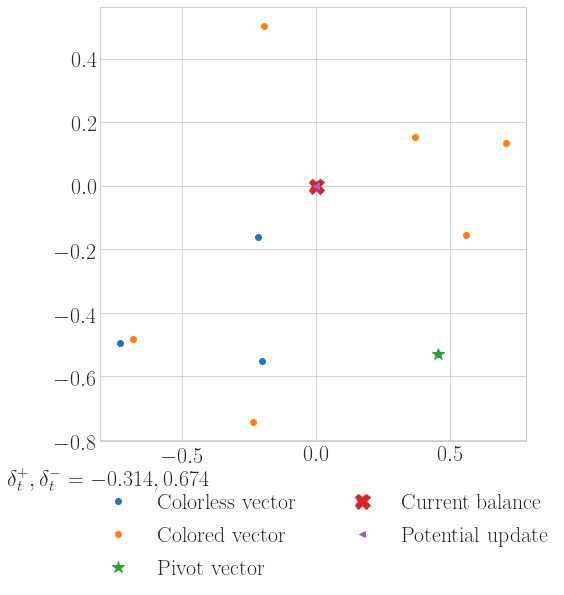

xs: [array([-2.306e-01, -1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00,
       -1.000e+00, 1.000e+00, -2.302e-01, -1.000e+00, -1.000e+00]), array([-2.156e-01, -7.635e-01, 1.000e+00, 1.000e+00, -1.000e+00,
       -1.000e+00, 1.000e+00, -1.000e+00, -1.000e+00, -1.000e+00])]
sum:[array([0.000e+00, -3.331e-16]), array([1.665e-16, -3.331e-16])]


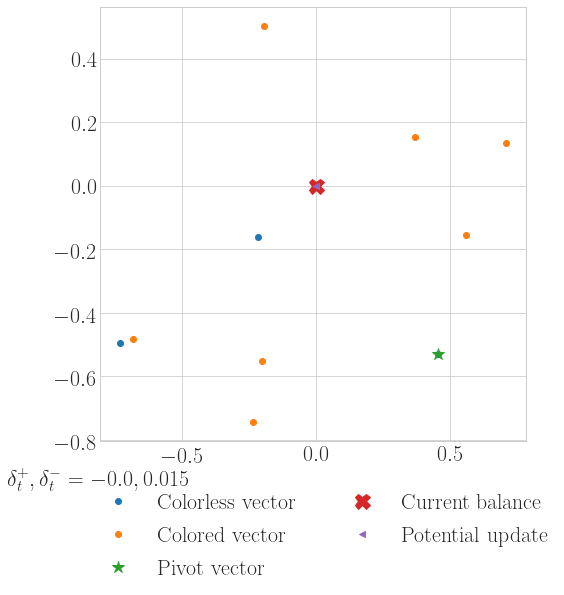

xs: [array([1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00,
       -1.000e+00, 1.000e+00, -2.170e-02, -1.000e+00, -1.000e+00]), array([-1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00,
       -1.000e+00, 1.000e+00, -3.605e-01, -1.000e+00, -1.000e+00])]
sum:[array([5.156e-01, -6.869e-01]), array([-3.224e-01, 4.295e-01])]


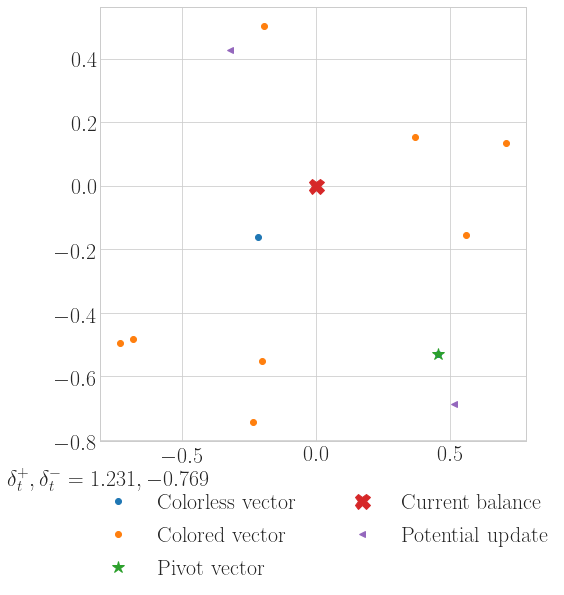

xs: [array([1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00,
       -1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00, -1.000e+00]), array([1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00, -1.000e+00,
       -1.000e+00, 1.000e+00, -1.000e+00, -1.000e+00, -1.000e+00])]
sum:[array([2.943e-01, -8.530e-01]), array([7.275e-01, -5.279e-01])]


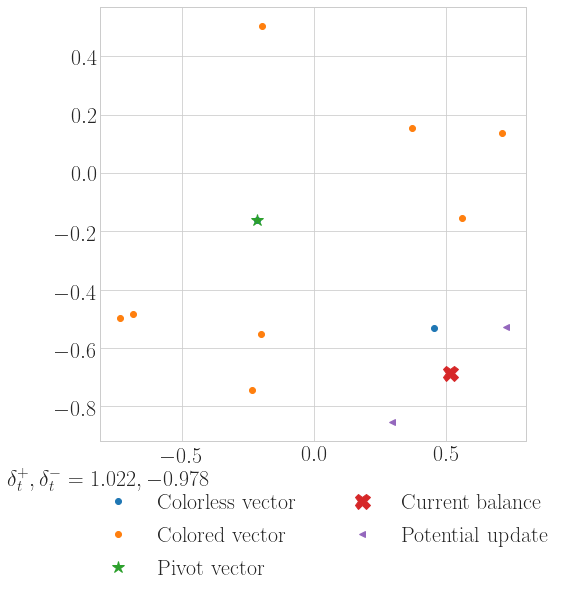

xs: [array([-2.971e-01, 1.546e-01, -2.324e-01, 1.394e-01, 1.931e-01, 1.000e+00,
       -5.733e-02, 4.174e-02, -9.099e-02, -1.016e-01]), array([2.971e-01, -1.546e-01, 2.324e-01, -1.394e-01, -1.931e-01,
       -1.000e+00, 5.733e-02, -4.174e-02, 9.099e-02, 1.016e-01])]
sum:[array([-3.469e-17, 9.194e-17]), array([3.469e-17, -9.194e-17])]


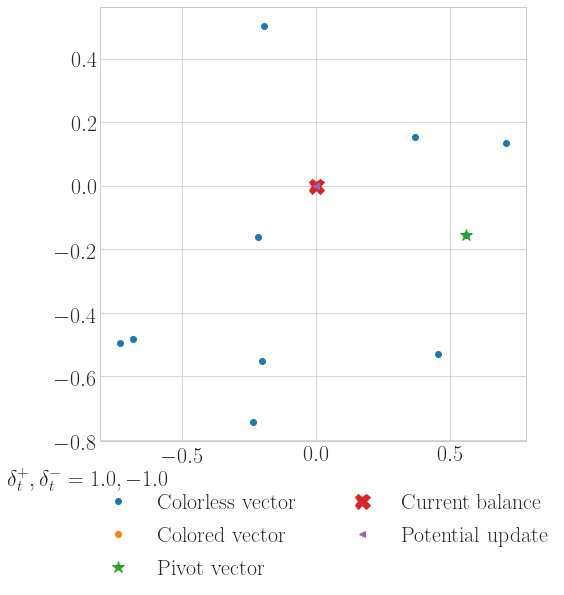

xs: [array([-2.069e-01, 1.000e+00, 4.924e-02, -1.833e-01, 1.950e-01, 1.000e+00,
       -2.120e-01, -6.167e-02, -2.858e-01, 5.719e-02]), array([-4.203e-01, -1.000e+00, -6.171e-01, 5.800e-01, 1.905e-01,
       1.000e+00, 1.540e-01, 1.830e-01, 1.750e-01, -3.186e-01])]
sum:[array([-1.735e-17, 3.868e-16]), array([-5.551e-17, -2.637e-16])]


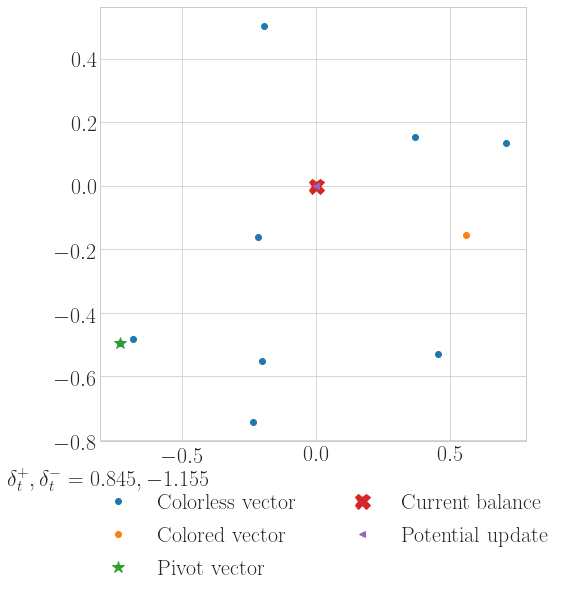

xs: [array([-2.307e-01, 1.000e+00, -4.573e-02, -7.072e-02, 1.885e-01,
       1.000e+00, -1.544e-01, -1.000e+00, -2.126e-01, 2.761e-03]), array([-1.800e-01, 1.000e+00, 1.567e-01, -3.106e-01, 2.022e-01, 1.000e+00,
       -2.773e-01, 1.000e+00, -3.685e-01, 1.188e-01])]
sum:[array([-1.869e-16, 3.684e-16]), array([1.110e-16, 4.233e-16])]


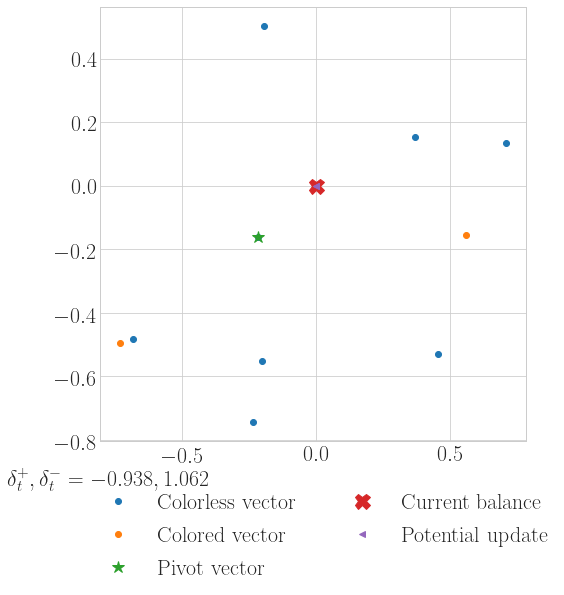

xs: [array([-3.386e-01, 1.000e+00, -2.437e-01, 1.307e-01, 2.260e-01, 1.000e+00,
       -8.256e-02, -1.000e+00, -1.260e-01, 1.000e+00]), array([-1.223e-01, 1.000e+00, 1.533e-01, -2.733e-01, 1.508e-01, 1.000e+00,
       -2.266e-01, -1.000e+00, -2.998e-01, -1.000e+00])]
sum:[array([0.000e+00, 3.886e-16]), array([-1.110e-16, 3.331e-16])]


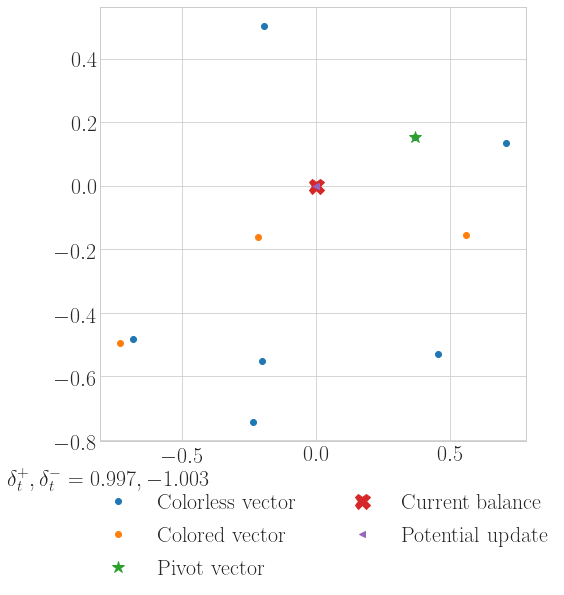

xs: [array([-8.958e-01, 1.000e+00, 1.000e+00, 8.571e-01, 4.877e-01, 1.000e+00,
       9.546e-02, -1.000e+00, 7.237e-02, 1.000e+00]), array([2.677e-04, 1.000e+00, -1.000e+00, -3.110e-01, 6.693e-02, 1.000e+00,
       -1.908e-01, -1.000e+00, -2.466e-01, 1.000e+00])]
sum:[array([2.220e-16, 1.388e-16]), array([-1.110e-16, 4.718e-16])]


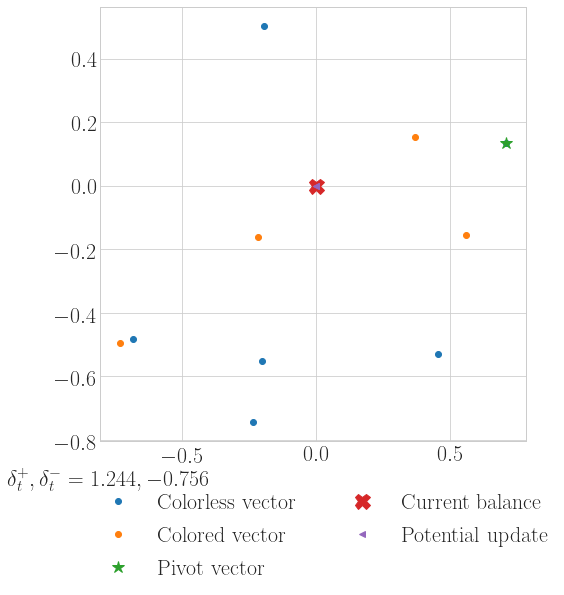

xs: [array([-1.000e+00, 1.000e+00, 1.000e+00, 6.645e-01, 6.075e-01, 1.000e+00,
       -7.294e-02, -1.000e+00, 4.781e-01, 1.000e+00]), array([-8.184e-01, 1.000e+00, 1.000e+00, 1.000e+00, 3.988e-01, 1.000e+00,
       2.204e-01, -1.000e+00, -2.286e-01, 1.000e+00])]
sum:[array([1.110e-16, 8.327e-17]), array([3.331e-16, 1.110e-16])]


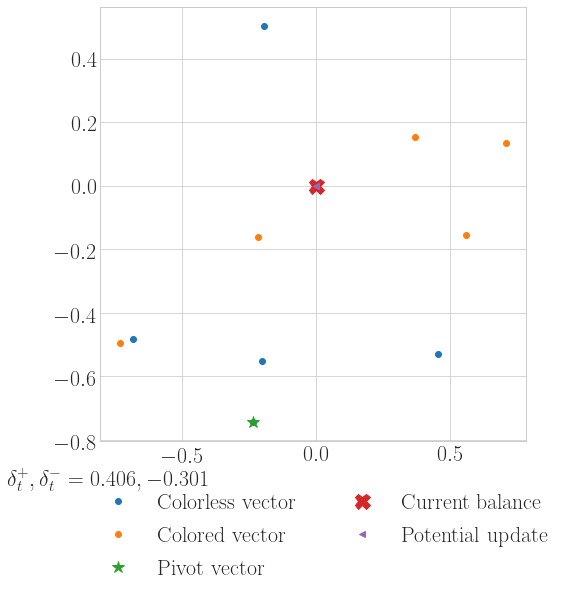

xs: [array([-1.000e+00, 1.000e+00, 1.000e+00, 4.831e-01, 9.027e-01, 1.000e+00,
       -3.482e-01, -1.000e+00, 1.000e+00, 1.000e+00]), array([-1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 6.145e-02, 1.000e+00,
       4.364e-01, -1.000e+00, -4.876e-01, 1.000e+00])]
sum:[array([1.110e-16, 2.220e-16]), array([1.665e-16, -2.220e-16])]


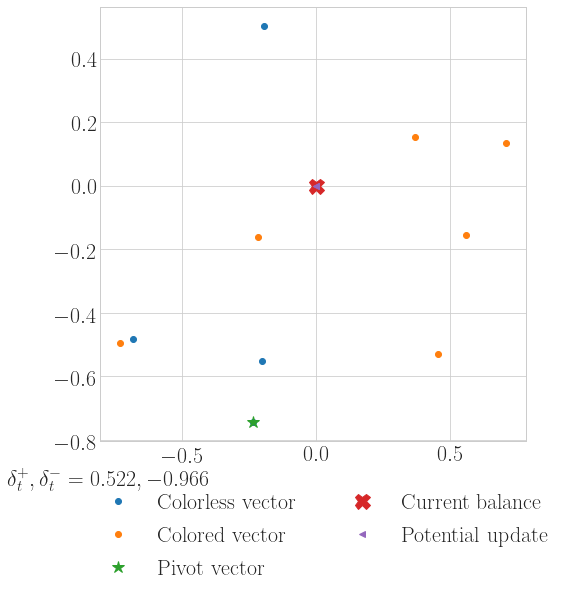

xs: [array([-1.000e+00, 1.000e+00, 1.000e+00, 4.108e-01, 1.000e+00, 1.000e+00,
       -1.962e-01, -1.000e+00, 1.000e+00, 1.000e+00]), array([-1.000e+00, 1.000e+00, 1.000e+00, 7.932e-01, 4.853e-01, 1.000e+00,
       -1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00])]
sum:[array([1.665e-16, 2.220e-16]), array([1.665e-16, 3.331e-16])]


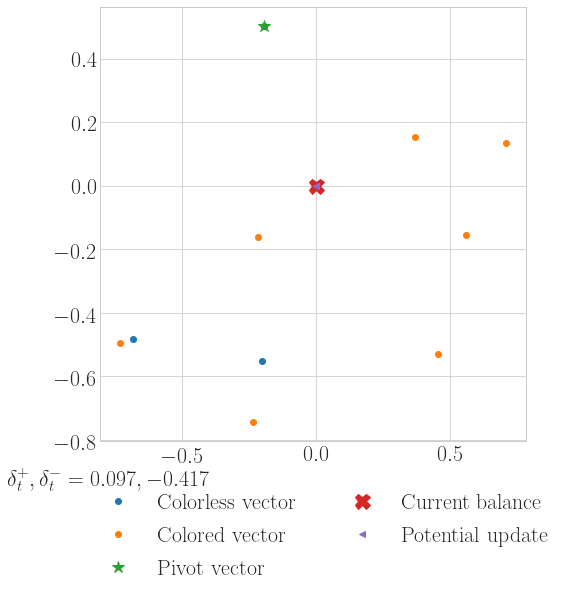

xs: [array([-1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       -8.871e-01, -1.000e+00, 1.000e+00, 1.000e+00]), array([-1.000e+00, 1.000e+00, 1.000e+00, -6.093e-01, 1.000e+00, 1.000e+00,
       1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00])]
sum:[array([-2.644e-01, 9.651e-02]), array([4.579e-01, -1.671e-01])]


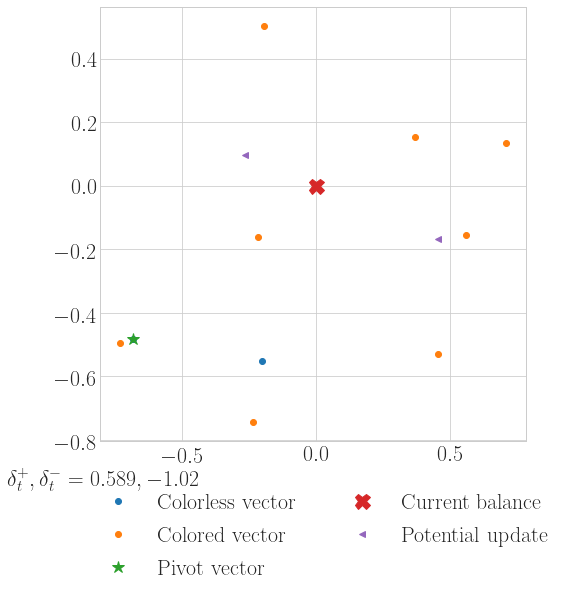

xs: [array([-1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00]), array([-1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       -1.000e+00, -1.000e+00, 1.000e+00, 1.000e+00])]
sum:[array([-6.447e-01, -9.455e-01]), array([-2.417e-01, 1.588e-01])]


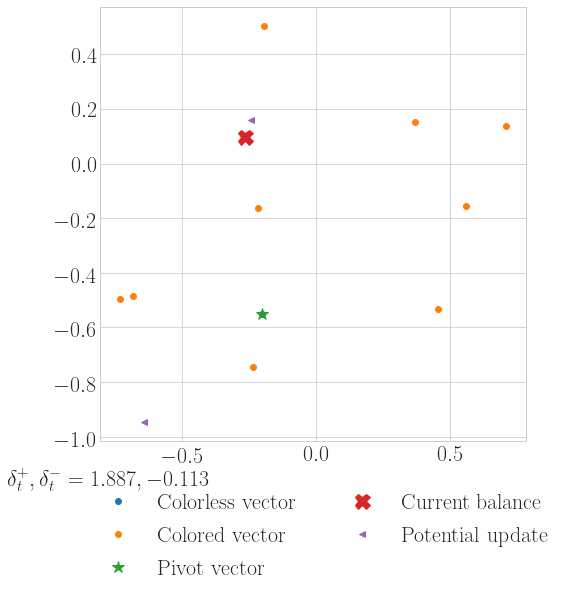

xs: [array([1.792e-01, 1.626e-01, -4.271e-02, 1.588e-01, -1.689e-01, 5.444e-02,
       -1.000e+00, 5.344e-02, 2.476e-01, -4.957e-02]), array([-1.792e-01, -1.626e-01, 4.271e-02, -1.588e-01, 1.689e-01,
       -5.444e-02, 1.000e+00, -5.344e-02, -2.476e-01, 4.957e-02])]
sum:[array([1.006e-16, -1.475e-17]), array([-1.006e-16, 1.475e-17])]


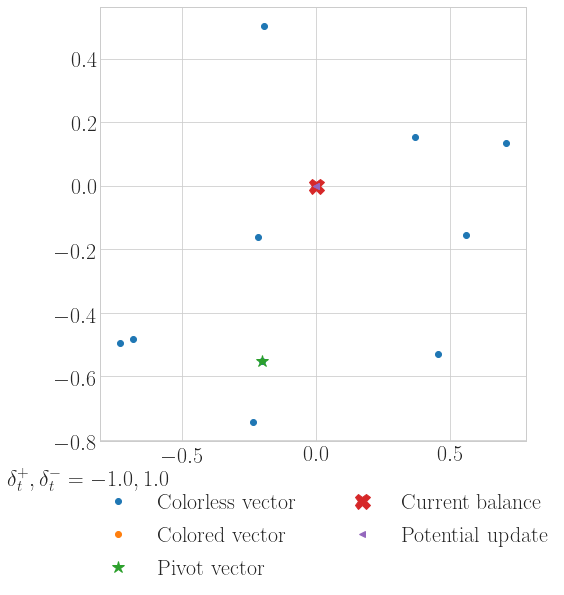

xs: [array([1.841e-01, -1.522e-01, 1.843e-01, 1.000e+00, -1.081e-01, 1.735e-01,
       -1.000e+00, -4.319e-02, 1.391e-02, 8.741e-02]), array([1.725e-01, 5.963e-01, -3.555e-01, -1.000e+00, -2.526e-01,
       -1.096e-01, -1.000e+00, 1.866e-01, 5.695e-01, -2.383e-01])]
sum:[array([1.943e-16, -3.123e-17]), array([6.939e-17, -1.388e-17])]


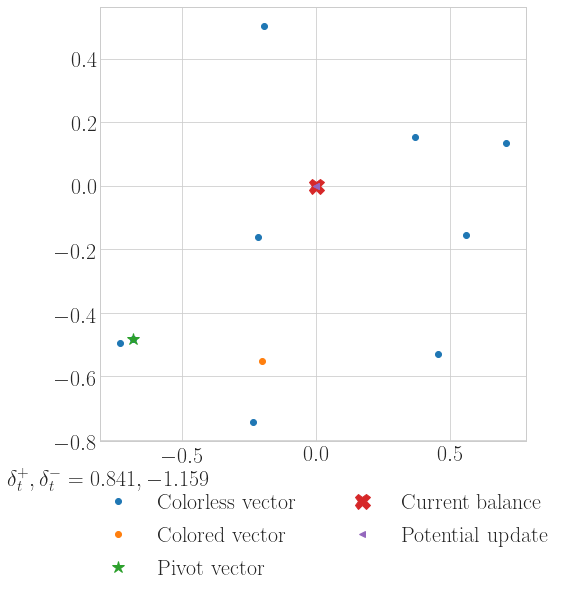

xs: [array([-1.425e-01, -2.316e-01, 1.071e-01, 1.000e+00, -1.000e+00,
       -5.623e-03, -1.000e+00, -7.392e-02, -2.739e-01, 8.374e-02]), array([5.899e-01, -5.360e-02, 2.803e-01, 1.000e+00, 1.000e+00, 3.961e-01,
       -1.000e+00, -5.012e-03, 3.715e-01, 9.198e-02])]
sum:[array([3.816e-17, -1.735e-18]), array([2.290e-16, 2.550e-16])]


KeyboardInterrupt: 

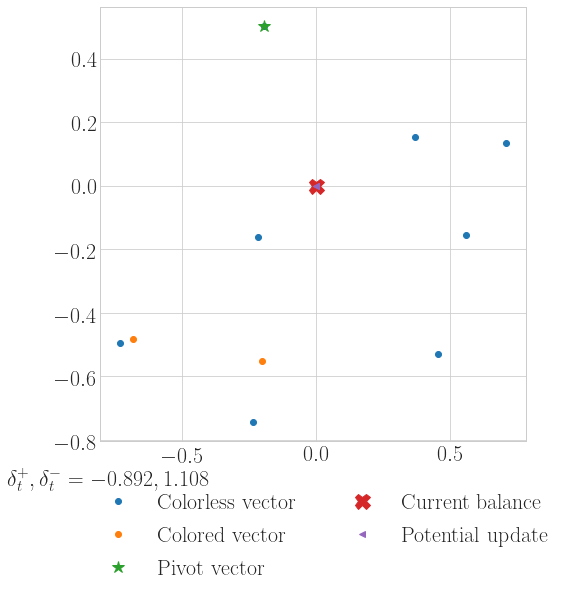

In [24]:
n=10
v=sample_from_sphere(n)
v=sample_from_ball(n,d=2)
#print(f'v:{v}')
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
for i in range(n):
    #print(i)
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),plot=True,debug=False))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW')
plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))
tikzplotlib.save(f"4types_{n}.tex")
counts = [x for x in list(zip(*np.unique(gsw_xs, return_counts = True, axis = 0))) if x[1]>1]
print(counts)

C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:289: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[]


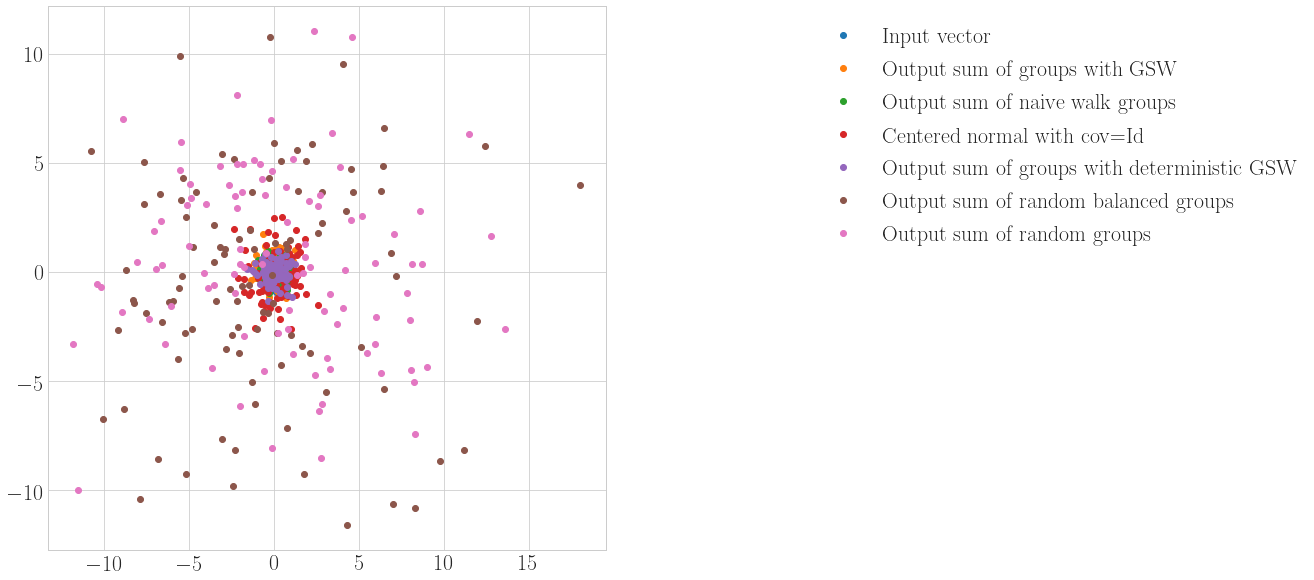

In [34]:
n=100
v=sample_from_sphere(n)
v=sample_from_ball(n)
#print(f'v:{v}')
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
rand_xs=[]
balanced_xs=[]
subteam = [-1] * int(n/2) + [1] * int(n/2)
naive_xs=[]
deterministic_gsw_xs=[]
for i in range(n):
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),debug=False))
    deterministic_gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),debug=False,smallest_delta=True))
    rand_xs.append(2*np.random.randint(2,size=n)-1)
    random.shuffle(subteam)
    balanced_xs.append(subteam.copy())
    naive_xs.append(naive_walk(v))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW')
normals=np.random.multivariate_normal(np.zeros(2), np.diag(np.ones(2)), size=n)
plt.plot([np.matmul(B,x)[0] for x in naive_xs],[np.matmul(B,x)[1] for x in naive_xs],'o',label='Output sum of naive walk groups')
plt.plot(normals[:,0],normals[:,1],'o',label='Centered normal with cov=Id')
plt.plot([np.matmul(B,x)[0] for x in deterministic_gsw_xs],[np.matmul(B,x)[1] for x in deterministic_gsw_xs],'o',label='Output sum of groups with deterministic GSW')

plt.plot([np.matmul(B,x)[0] for x in balanced_xs],[np.matmul(B,x)[1] for x in balanced_xs],'o',label='Output sum of random balanced groups')
plt.plot([np.matmul(B,x)[0] for x in rand_xs],[np.matmul(B,x)[1] for x in rand_xs],'o',label='Output sum of random groups')
plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))
tikzplotlib.save(f"4types_{n}.tex")
counts = [x for x in list(zip(*np.unique(gsw_xs, return_counts = True, axis = 0))) if x[1]>1]
print(counts)

C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[]


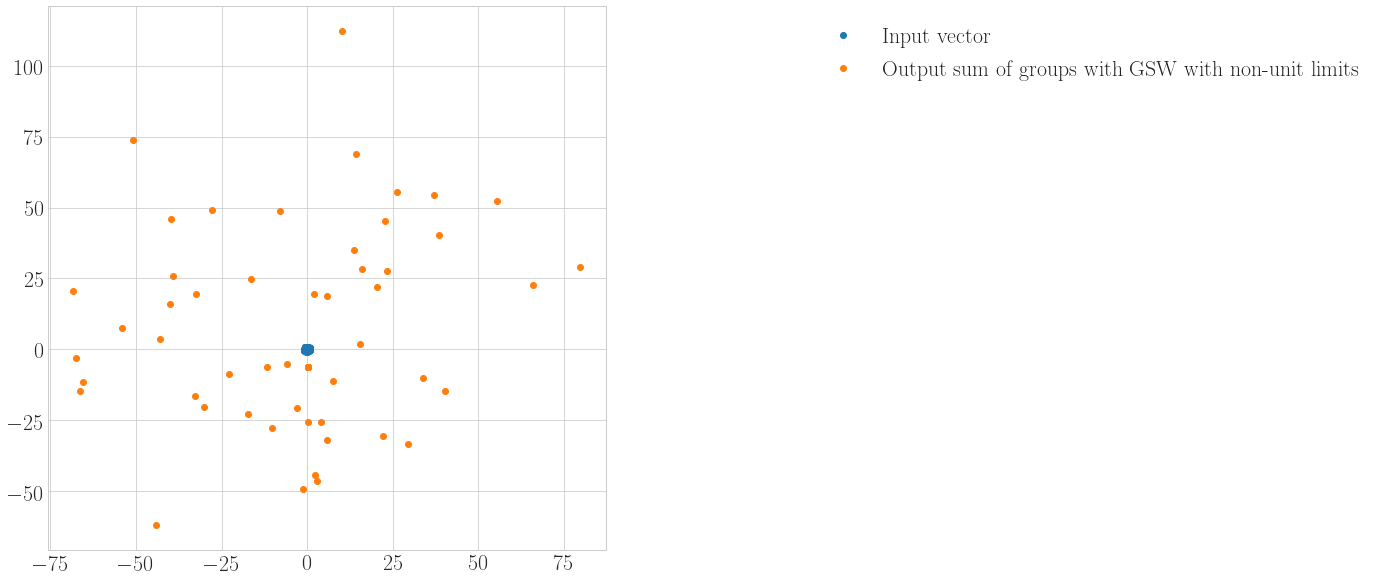

In [148]:
n=100
v=sample_from_sphere(n)
v=sample_from_ball(n)
#print(f'v:{v}')
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
a,b=-np.ones(n),100*np.ones(n)
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
for i in range(n):
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),a,b,False,False))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW with non-unit limits')
plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))
tikzplotlib.save(f"4types_{n}.tex")
counts = [x for x in list(zip(*np.unique(gsw_xs, return_counts = True, axis = 0))) if x[1]>1]
print(counts)

C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:150: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[]


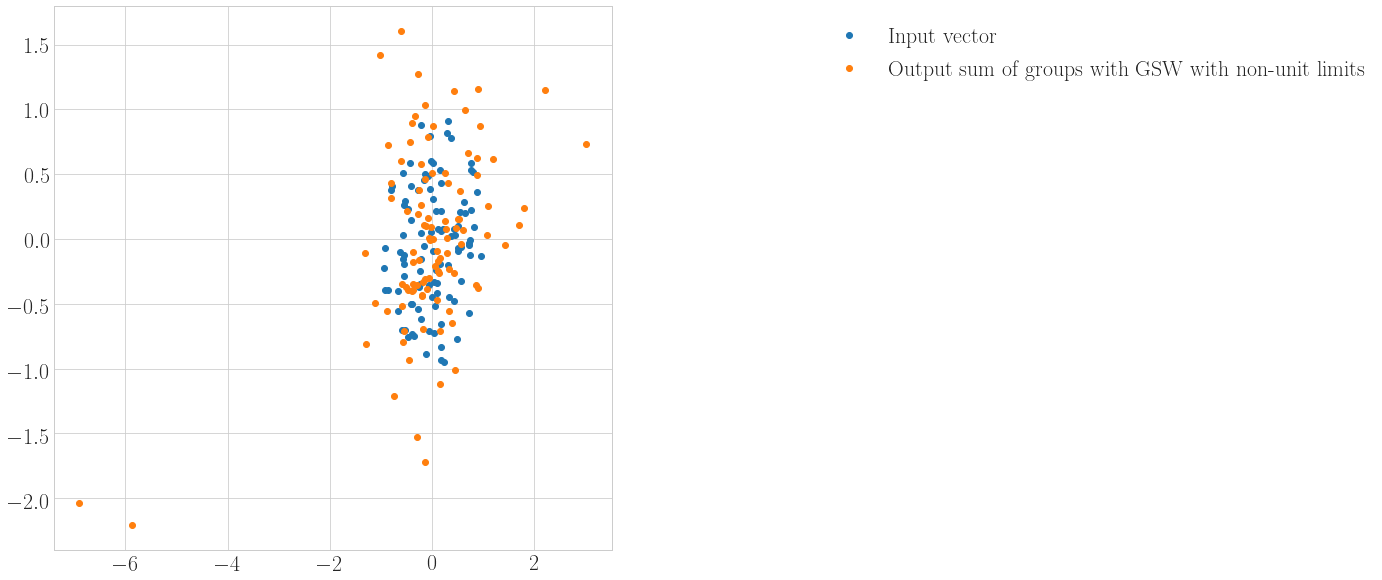

In [223]:
#Trying with a single big coordinate
n=100
v=sample_from_ball(n)
#print(f'v:{v}')
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
a,b=-np.ones(n),np.ones(n)
a[1]=-15
#b[0]=20
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
for i in range(n):
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),a,b,False,False))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW with non-unit limits')
plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))
tikzplotlib.save(f"4types_{n}.tex")
counts = [x for x in list(zip(*np.unique(gsw_xs, return_counts = True, axis = 0))) if x[1]>1]
print(counts)

C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:296: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[]


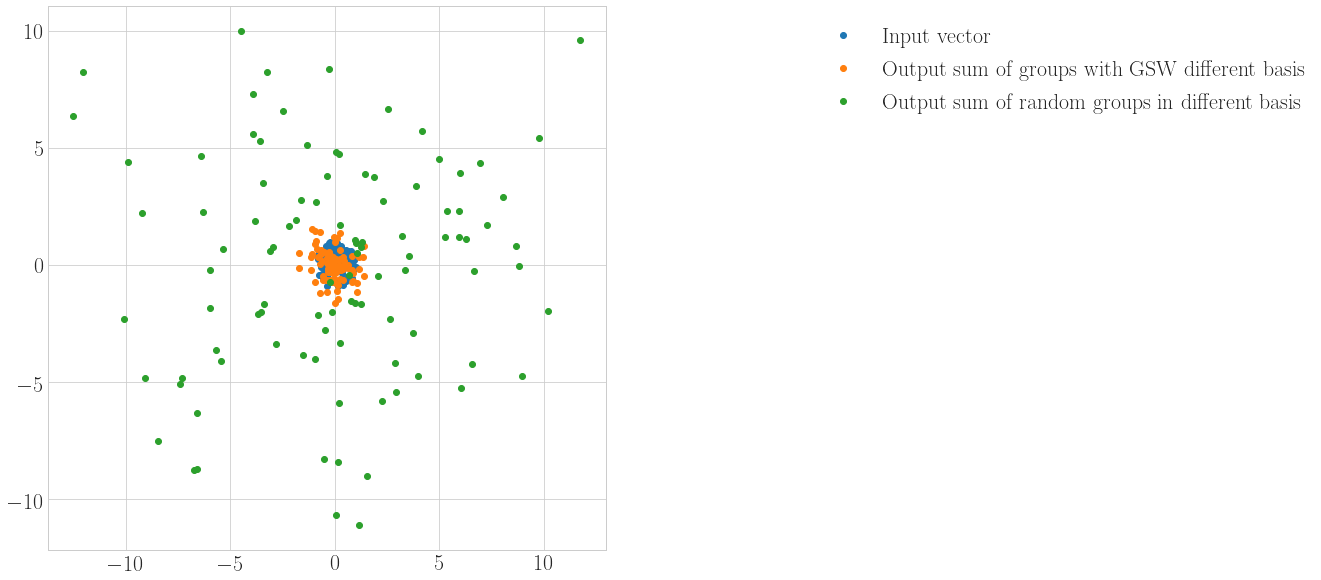

In [44]:
## Trying with a random orthonormal basis (A Gram-Schmidt orthogonalization of a random basis)
n=100
x=np.random.uniform(size=(n,n))
basis=gram_schmidt_columns(x)
v=sample_from_ball(n,d=2)
B=np.transpose(np.vstack(tuple([e for e in v])))
#v=np.transpose(np.matmul(np.transpose(np.vstack(tuple([e for e in basis]))),np.vstack(tuple([e for e in v]))))#is v already a list ? If so we can simplify syntax here
#v=[v[:,i] for i in range(v.shape[1])]
#B=np.transpose(np.vstack(tuple([e for e in v])))

#print(f'v:{v}')
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
a,b=-np.ones(n),np.ones(n)
gsw_xs=[]
rand_xs=[]
for i in range(n):
    rand_xs.append(change_basis(2*np.random.randint(2,size=n)-1,basis,orthonormal_basis(n)))
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),a,b,False,False,False,basis))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW different basis')
plt.plot([np.matmul(B,x)[0] for x in rand_xs],[np.matmul(B,x)[1] for x in rand_xs],'o',label='Output sum of random groups in different basis')

plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))
tikzplotlib.save(f"4types_{n}.tex")
counts = [x for x in list(zip(*np.unique(gsw_xs, return_counts = True, axis = 0))) if x[1]>1]
print(counts)

[[-2.169e-03 7.544e-01 9.126e-01 ... 8.109e-01 -4.433e-01 -6.225e-01]
 [-3.890e-01 -8.723e-01 -6.845e-01 ... -9.069e-01 9.989e-01 -5.756e-01]
 [-8.358e-01 1.516e-01 3.192e-01 ... -2.033e-01 -5.179e-01 5.336e-01]
 ...
 [8.611e-01 5.505e-01 -9.301e-01 ... -2.042e-01 3.844e-01 1.720e-01]
 [-4.402e-01 1.810e-01 -1.688e-01 ... -3.698e-01 -4.016e-01 4.337e-01]
 [-1.601e-01 -6.487e-01 8.529e-01 ... -9.434e-01 3.540e-01 -5.613e-01]]


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:296: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[]


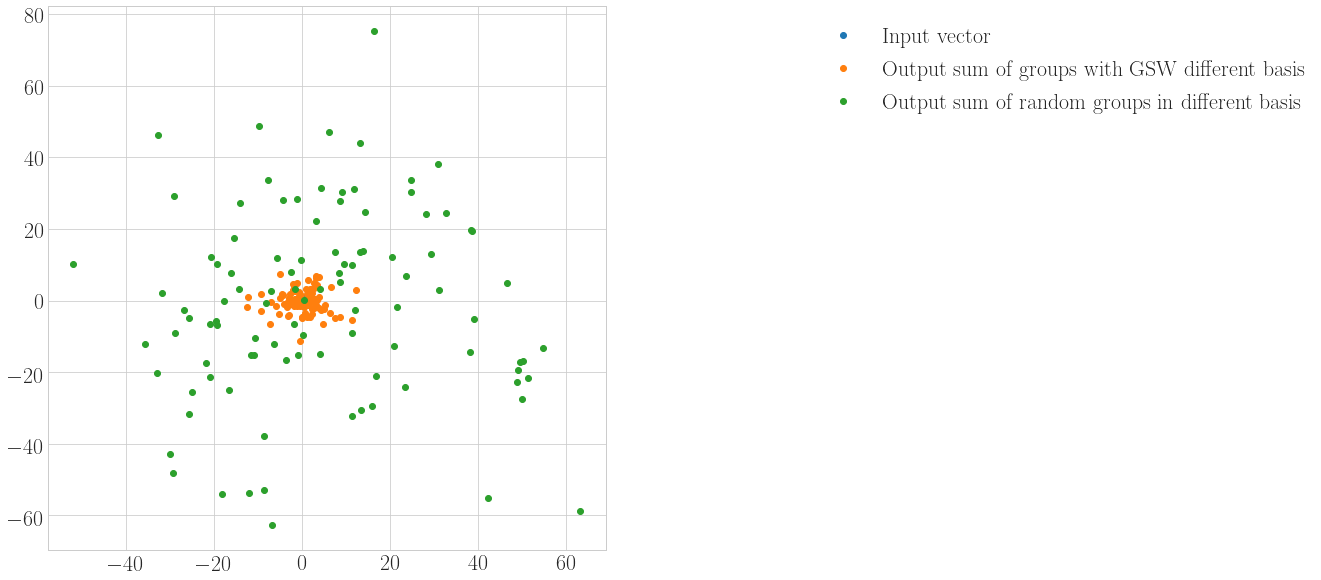

In [53]:
## Trying with a random non-orthonormal basis 
n=100
x=2*np.random.uniform(size=(n,n))-1
print(x)
#basis=gram_schmidt_columns(x)
basis=[x[i,:] for i in range(x.shape[0])]
v=sample_from_ball(n,d=2)
B=np.transpose(np.vstack(tuple([e for e in v])))
#v=np.transpose(np.matmul(np.transpose(np.vstack(tuple([e for e in basis]))),np.vstack(tuple([e for e in v]))))#is v already a list ? If so we can simplify syntax here
#v=[v[:,i] for i in range(v.shape[1])]
#B=np.transpose(np.vstack(tuple([e for e in v])))

#print(f'v:{v}')
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
a,b=-np.ones(n),np.ones(n)
gsw_xs=[]
rand_xs=[]
for i in range(n):
    rand_xs.append(change_basis(2*np.random.randint(2,size=n)-1,basis,orthonormal_basis(n)))
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),a,b,False,False,False,basis))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW different basis')
plt.plot([np.matmul(B,x)[0] for x in rand_xs],[np.matmul(B,x)[1] for x in rand_xs],'o',label='Output sum of random groups in different basis')

plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))
tikzplotlib.save(f"4types_{n}.tex")
counts = [x for x in list(zip(*np.unique(gsw_xs, return_counts = True, axis = 0))) if x[1]>1]
print(counts)

[[-9.937e-01 2.460e-02 -3.861e-01 2.304e-01 -2.678e-01 -5.865e-01
  6.222e-01 -1.072e-01 -6.637e-01 4.633e-01]
 [5.550e-01 4.239e-01 -7.932e-01 8.728e-02 9.598e-01 4.880e-01 9.974e-01
  -1.730e-01 2.158e-01 8.272e-01]
 [-1.061e-01 1.285e-01 -9.872e-01 -6.193e-01 3.278e-01 -2.441e-01
  9.327e-01 8.092e-01 -6.266e-01 6.135e-01]
 [-3.074e-01 -9.362e-01 5.884e-01 7.416e-01 -9.766e-01 8.472e-01
  8.061e-01 -9.097e-01 4.830e-01 7.664e-01]
 [8.153e-01 1.726e-01 -4.128e-03 8.863e-01 -2.150e-01 -9.894e-01
  4.375e-01 7.582e-01 -3.727e-01 9.176e-01]
 [2.852e-02 5.113e-01 7.261e-01 -5.699e-01 9.341e-01 6.964e-01 2.523e-01
  7.281e-01 7.946e-01 -5.294e-01]
 [6.612e-02 2.434e-01 -6.200e-01 -7.700e-01 -9.434e-01 3.185e-01
  8.609e-01 2.148e-01 -9.737e-02 -3.314e-02]
 [-1.708e-01 6.440e-01 -9.970e-02 -3.503e-01 -1.657e-01 7.239e-01
  6.606e-01 -2.568e-01 7.954e-01 -7.042e-01]
 [-3.323e-01 2.004e-01 -8.974e-02 -4.580e-01 6.582e-01 6.655e-01
  5.257e-01 -3.108e-01 -8.302e-01 8.093e-01]
 [5.613e-01 8.47

C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:296: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


v_perp:[-2.126e-01 -4.786e-01]
v_perp-sum u_i*v_i:[-8.882e-16 2.220e-16]
Calculated update direction u:[0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.027e-01 1.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00]
All deltas considered:[-2.383e+00 -1.529e+00 9.355e-01 4.710e-01]
delta_+:0.4710401277062447
delta_-:-1.5289598722937576
delta=delta_+
Incurred discrepancy:0.24667121544660595
Computing the list of elements that are alive with threshold 1e-12
x: [1.642e+00 6.572e-01 3.356e+00 7.527e-02 -3.680e+00 1.328e+00 -6.710e-01
 8.857e-01 3.530e+00 -2.491e+00]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00]
b: [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00]
Choosing pivot through mode random.
x: [1.642e+00 6.572e-01 3.356e+00 7.527e-02 -3.680e+00 1.328e+00 -6.710e-01
 8.857e-01 3.530e+00 -2.491e+00]
Alive: [False False False False  True False False False False False]
in bas

 3.142e+01 -2.688e+00 4.515e+00 -5.088e+01 4.814e+00 3.699e+01 1.000e+00]
delta_+:1.0000000000000004
delta_-:-1.0000000000000004
delta=delta_-
Incurred discrepancy:1.7554167342883506e-16
Computing the list of elements that are alive with threshold 1e-12
x: [-2.941e-01 -1.004e+00 -7.374e-01 8.530e-01 4.124e-01 -5.539e-01 4.998e-01
 -5.214e-01 -4.775e-01 5.373e-01]
a: [-1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00]
b: [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00]
Choosing pivot through mode random.
x: [-2.941e-01 -1.004e+00 -7.374e-01 8.530e-01 4.124e-01 -5.539e-01 4.998e-01
 -5.214e-01 -4.775e-01 5.373e-01]
Alive: [ True  True  True  True  True  True  True  True  True False]
in basis
x:[6.398e-02 -2.815e-02 5.726e-02 -3.182e-02 3.720e-01 -2.215e-01 1.965e-02
 -2.077e-01 -2.703e-02 -1.000e+00]
u:[-6.398e-02 2.815e-02 -5.726e-02 3.182e-02 -3.720e-01 2.215e-01 -1.965e-0

 0.000e+00 0.000e+00 0.000e+00]
Alive: [ True  True  True  True  True  True  True  True  True  True]

 Iteration 1
Alive and not pivot: [ True  True False  True  True  True  True  True  True  True]
v_perp:[0.000e+00 0.000e+00]
v_perp-sum u_i*v_i:[3.608e-16 -3.331e-16]
v_perp:[0.000e+00 0.000e+00]
v_perp-sum u_i*v_i:[3.608e-16 -3.331e-16]
Calculated update direction u:[-4.999e-01 1.569e-01 1.000e+00 -1.900e-01 -1.440e-01 -2.175e-01
 -6.606e-01 -5.652e-02 -8.918e-04 -8.423e-02]
All deltas considered:[2.000e+00 -6.372e+00 -1.000e+00 5.262e+00 6.943e+00 4.597e+00 1.514e+00
 1.769e+01 1.121e+03 1.187e+01 -2.000e+00 6.372e+00 1.000e+00 -5.262e+00
 -6.943e+00 -4.597e+00 -1.514e+00 -1.769e+01 -1.121e+03 -1.187e+01]
delta_+:1.0000000000000009
delta_-:-1.0000000000000009
delta=delta_+
Incurred discrepancy:4.335559509131367e-16
Computing the list of elements that are alive with threshold 1e-12
x: [3.315e-01 -4.425e-02 -8.153e-01 -3.050e-01 1.316e+00 -2.774e-01
 -5.826e-02 5.481e-01 -4.449e-01 4.0

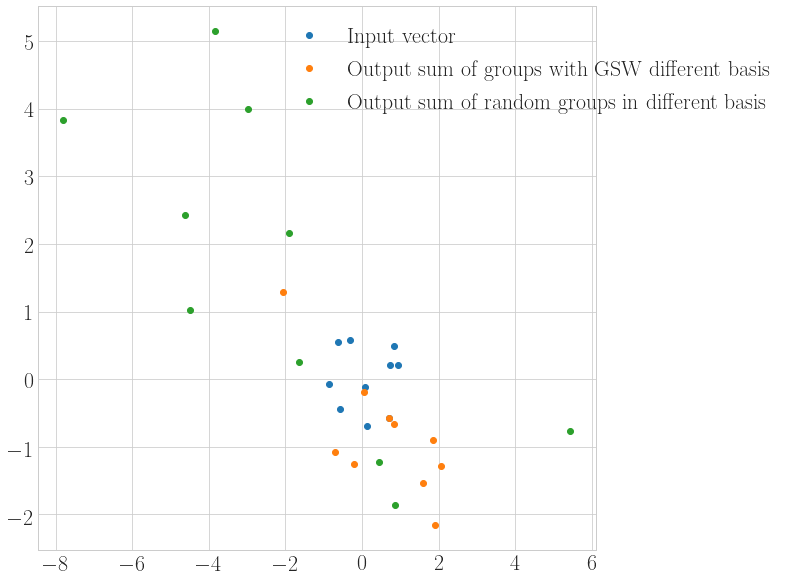

In [55]:
## Trying with a random non-orthonormal basis 
n=10
x=2*np.random.uniform(size=(n,n))-1
print(x)
#basis=gram_schmidt_columns(x)
basis=[x[i,:] for i in range(x.shape[0])]
v=sample_from_ball(n,d=2)
B=np.transpose(np.vstack(tuple([e for e in v])))
#v=np.transpose(np.matmul(np.transpose(np.vstack(tuple([e for e in basis]))),np.vstack(tuple([e for e in v]))))#is v already a list ? If so we can simplify syntax here
#v=[v[:,i] for i in range(v.shape[1])]
#B=np.transpose(np.vstack(tuple([e for e in v])))

#print(f'v:{v}')
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
a,b=-np.ones(n),np.ones(n)
gsw_xs=[]
rand_xs=[]
for i in range(n):
    rand_xs.append(change_basis(2*np.random.randint(2,size=n)-1,basis,orthonormal_basis(n)))
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),a,b,False,True,False,basis))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW different basis')
plt.plot([np.matmul(B,x)[0] for x in rand_xs],[np.matmul(B,x)[1] for x in rand_xs],'o',label='Output sum of random groups in different basis')

plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))
tikzplotlib.save(f"4types_{n}.tex")
counts = [x for x in list(zip(*np.unique(gsw_xs, return_counts = True, axis = 0))) if x[1]>1]
print(counts)

C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:296: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[]


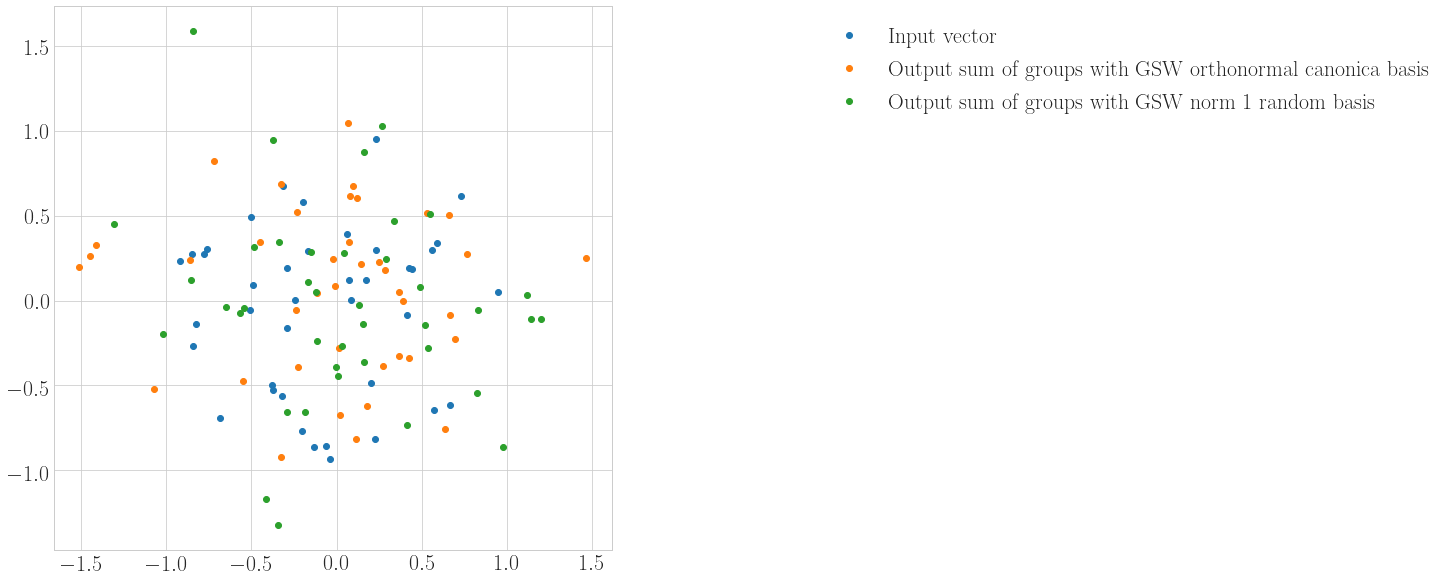

In [59]:
## Trying with a random non-orthonormal basis with norm 1
n=40
x=2*np.random.uniform(size=(n,n))-1
#basis=gram_schmidt_columns(x)
basis=[normalize(x[i,:]) for i in range(x.shape[0])]
v=sample_from_ball(n,d=2)
B=np.transpose(np.vstack(tuple([e for e in v])))
#v=np.transpose(np.matmul(np.transpose(np.vstack(tuple([e for e in basis]))),np.vstack(tuple([e for e in v]))))#is v already a list ? If so we can simplify syntax here
#v=[v[:,i] for i in range(v.shape[1])]
#B=np.transpose(np.vstack(tuple([e for e in v])))

#print(f'v:{v}')
plt.plot([e[0] for e in v],[e[1] for e in v],'o',label='Input vector')
a,b=-np.ones(n),np.ones(n)
gsw_xs=[]
gsw_xs_non_orth=[]
rand_xs=[]
for i in range(n):
    #rand_xs.append(change_basis(2*np.random.randint(2,size=n)-1,basis,orthonormal_basis(n)))
    gsw_xs_non_orth.append(gram_schmidt_walk(v,np.zeros(n),a,b,False,False,False,basis))
    gsw_xs.append(gram_schmidt_walk(v,np.zeros(n),a,b))
plt.plot([np.matmul(B,x)[0] for x in gsw_xs],[np.matmul(B,x)[1] for x in gsw_xs],'o',label='Output sum of groups with GSW orthonormal canonica basis')
plt.plot([np.matmul(B,x)[0] for x in gsw_xs_non_orth],[np.matmul(B,x)[1] for x in gsw_xs_non_orth],'o',label='Output sum of groups with GSW norm 1 random basis')

#plt.plot([np.matmul(B,x)[0] for x in rand_xs],[np.matmul(B,x)[1] for x in rand_xs],'o',label='Output sum of random groups in different basis')

plt.legend()
plt.legend(bbox_to_anchor=(1.35, 1))
tikzplotlib.save(f"4types_{n}.tex")
counts = [x for x in list(zip(*np.unique(gsw_xs, return_counts = True, axis = 0))) if x[1]>1]
print(counts)

In [54]:
print(gsw_xs)

[array([6.612e+00, -6.194e+00, 1.011e+01, -1.030e+00, 4.797e+00, 3.214e+00,
       4.625e-02, -6.310e+00, 1.579e+00, -5.495e+00, 1.737e+01, 8.428e-01,
       -5.824e+00, 3.015e+00, -4.962e+00, -1.629e+00, 2.619e-01,
       4.349e+00, -2.529e+00, -4.195e-01, -1.076e+00, -2.460e+01,
       4.317e+00, -2.540e+00, 7.881e+00, -2.759e+00, -1.600e+00,
       4.139e+00, -1.045e+01, 8.965e-01, -1.001e+01, -6.899e+00,
       4.704e+00, 1.032e-01, 3.913e+00, -7.707e-01, 4.902e+00, 5.797e+00,
       4.714e+00, -1.938e+00, 5.449e+00, -2.696e+00, 7.567e+00, 8.451e+00,
       3.102e+00, -9.481e-01, 4.740e+00, -5.731e+00, -3.479e+00,
       3.486e+00, 4.871e+00, 9.274e+00, 6.108e+00, 9.772e+00, 5.652e+00,
       -3.582e+00, 4.226e+00, 7.043e+00, 1.051e-02, 5.296e+00, -8.022e-01,
       -9.929e+00, 3.853e+00, -3.461e-01, 1.375e+00, -8.152e+00,
       8.805e-01, 2.386e+00, -6.487e+00, -1.109e+01, 3.111e+00, 1.519e+01,
       -4.846e+00, 3.201e-01, 4.247e+00, -4.194e+00, -3.270e-01,
       2.977e+00, -2.

In [22]:
#Trying with half structured in dimension 100, where structured are such that they have four 1's in the first m (m=n here) coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=100
v=sample_from_ball(int(n/2),d=n)
subteam = [0] * int(n-4) + [1/2] * 4
for i in range(int(n/2)):
    random.shuffle(subteam)
    v.append(subteam.copy())
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(n):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n/2])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[int(n/2):]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:int(n/2)]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:194: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 5.632696869526155
Average time step of coloring of structured elements: 42.38
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #1
Output norm: 5.3448482858229225
Average time step of coloring of structured elements: 48.68
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #2
Output norm: 4.909550732249168
Average time step of coloring of structured elements: 50.88
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:4.0

 Try #3
Output norm: 4.9829038071077285
Average time step of coloring of structured elements: 45.92
Coloring discrepancy among structured points:6.0
Coloring discrepancy among non-structured points:0.0

 Try #4
Output norm: 5.0564546231419945
Average time step of coloring of structured elements: 46.82
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:

Output norm: 5.200401710835154
Average time step of coloring of structured elements: 47.1
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:2.0

 Try #42
Output norm: 5.137826043989671
Average time step of coloring of structured elements: 45.86
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:0.0

 Try #43
Output norm: 5.195520810818796
Average time step of coloring of structured elements: 44.1
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:2.0

 Try #44
Output norm: 4.848828486652301
Average time step of coloring of structured elements: 50.52
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:4.0

 Try #45
Output norm: 5.051221761144401
Average time step of coloring of structured elements: 51.16
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0

Output norm: 5.379230101419362
Average time step of coloring of structured elements: 43.06
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:6.0

 Try #83
Output norm: 5.779698557382555
Average time step of coloring of structured elements: 47.04
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:8.0

 Try #84
Output norm: 4.890240313246613
Average time step of coloring of structured elements: 46.68
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:4.0

 Try #85
Output norm: 5.960054623691782
Average time step of coloring of structured elements: 53.54
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:10.0

 Try #86
Output norm: 5.4959875157610965
Average time step of coloring of structured elements: 41.88
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured poin

In [ ]:
#Try the same with deterministic, with different definittions of structured and n's

In [23]:
#Trying with half structured in dimension 100, where structured are such that they have four 1's in the first m (m=sqrt(n) here) coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=100
v=sample_from_ball(int(n/2),d=n)
subteam = [0] * int(np.sqrt(n)-4) + [1/2] * 4
for i in range(int(n/2)):
    random.shuffle(subteam)
    v.append(np.array(subteam.copy()+[0]*(n-int(np.sqrt(n)))))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(n):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n/2])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[int(n/2):]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:int(n/2)]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:194: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 4.873146026211153
Average time step of coloring of structured elements: 45.64
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:2.0

 Try #1
Output norm: 4.443118719494569
Average time step of coloring of structured elements: 48.72
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:4.0

 Try #2
Output norm: 4.655167943514522
Average time step of coloring of structured elements: 54.94
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:4.0

 Try #3
Output norm: 4.376316105036608
Average time step of coloring of structured elements: 46.2
Coloring discrepancy among structured points:1.1102230246251565e-16
Coloring discrepancy among non-structured points:4.0

 Try #4
Output norm: 5.214539021448999
Average time step of coloring of structured elements: 42.38
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-str

Output norm: 4.785649129078561
Average time step of coloring of structured elements: 49.3
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:4.0

 Try #41
Output norm: 5.014611505336998
Average time step of coloring of structured elements: 48.5
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:2.0

 Try #42
Output norm: 4.904999908444628
Average time step of coloring of structured elements: 53.92
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0.0

 Try #43
Output norm: 4.67219915924073
Average time step of coloring of structured elements: 41.22
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:6.0

 Try #44
Output norm: 5.407199848227176
Average time step of coloring of structured elements: 45.58
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:8.

Output norm: 5.343720495507724
Average time step of coloring of structured elements: 47.78
Coloring discrepancy among structured points:2.0000000000000004
Coloring discrepancy among non-structured points:0.0

 Try #81
Output norm: 4.561819801445875
Average time step of coloring of structured elements: 48.7
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #82
Output norm: 4.699205824705529
Average time step of coloring of structured elements: 52.26
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:4.0

 Try #83
Output norm: 4.975307674239176
Average time step of coloring of structured elements: 53.98
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #84
Output norm: 4.613767266171442
Average time step of coloring of structured elements: 55.54
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-str

In [27]:
#Now with deterministic GSW
#Trying with half structured in dimension 100, where structured are such that they have four 1's in the first m (m=sqrt(n) here) coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=200
v=sample_from_ball(int(n/2),d=n)
subteam = [0] * int(np.sqrt(n)-4) + [1/2] * 4
for i in range(int(n/2)):
    random.shuffle(subteam)
    v.append(np.array(subteam.copy()+[0]*(n-int(np.sqrt(n)))))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(n):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n/2])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[int(n/2):]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:int(n/2)]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:194: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 6.149347349553507
Average time step of coloring of structured elements: 97.69
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:14.0

 Try #1
Output norm: 6.386243920442948
Average time step of coloring of structured elements: 103.76
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:22.0

 Try #2
Output norm: 6.1620640807079345
Average time step of coloring of structured elements: 94.62
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:34.0

 Try #3
Output norm: 6.2819039633525415
Average time step of coloring of structured elements: 97.93
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:32.0

 Try #4
Output norm: 6.587224805638467
Average time step of coloring of structured elements: 105.59
Coloring discrepancy among structured points:2.220446049250313e-16
Coloring discrepancy among

Output norm: 6.324172220296954
Average time step of coloring of structured elements: 99.98
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:40.0

 Try #41
Output norm: 6.474675960162823
Average time step of coloring of structured elements: 107.57
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:34.0

 Try #42
Output norm: 6.875853079954677
Average time step of coloring of structured elements: 96.13
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:26.0

 Try #43
Output norm: 6.356649597628991
Average time step of coloring of structured elements: 103.17
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:36.0

 Try #44
Output norm: 6.72394093063865
Average time step of coloring of structured elements: 98.5
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured po

Output norm: 6.931828129612244
Average time step of coloring of structured elements: 98.91
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:22.0

 Try #82
Output norm: 6.392665144013921
Average time step of coloring of structured elements: 105.56
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:44.0

 Try #83
Output norm: 6.533454383449715
Average time step of coloring of structured elements: 104.32
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:16.0

 Try #84
Output norm: 6.846959180803074
Average time step of coloring of structured elements: 97.91
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:30.0

 Try #85
Output norm: 6.798829581012907
Average time step of coloring of structured elements: 94.24
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured 

Output norm: 6.726801096499067
Average time step of coloring of structured elements: 102.53
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:24.0

 Try #122
Output norm: 6.585466346849297
Average time step of coloring of structured elements: 108.05
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:32.0

 Try #123
Output norm: 6.1164187868017885
Average time step of coloring of structured elements: 101.18
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:26.0

 Try #124
Output norm: 5.984503604461025
Average time step of coloring of structured elements: 104.34
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:22.0

 Try #125
Output norm: 6.326905492846523
Average time step of coloring of structured elements: 100.15
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-str

Output norm: 6.4791776743475795
Average time step of coloring of structured elements: 98.15
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:20.0

 Try #162
Output norm: 6.426449728406285
Average time step of coloring of structured elements: 102.46
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:14.0

 Try #163
Output norm: 6.456926004723252
Average time step of coloring of structured elements: 108.26
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:22.0

 Try #164
Output norm: 6.538438219148269
Average time step of coloring of structured elements: 89.34
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:28.0

 Try #165
Output norm: 6.413120604780446
Average time step of coloring of structured elements: 96.67
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-struct

In [28]:
#Now with deterministic GSW and with much smaller structured group
#Trying with half structured in dimension 100, where structured are such that they have four 1's in the first m (m=sqrt(n) here) coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=200
structured=int(np.sqrt(n))
v=sample_from_ball(n-structured,d=n)
subteam = [0] * int(structured-4) + [1/2] * 4
for i in range(structured):
    random.shuffle(subteam)
    v.append(np.array(subteam.copy()+[0]*(n-structured)))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(n):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n-structured])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[n-structured:]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:n-structured]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:194: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 6.326830484088131
Average time step of coloring of structured elements: 48.857142857142854
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:34.0

 Try #1
Output norm: 6.54172525914891
Average time step of coloring of structured elements: 67.57142857142857
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:36.0

 Try #2
Output norm: 6.728668097903917
Average time step of coloring of structured elements: 23.071428571428573
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:30.0

 Try #3
Output norm: 7.402567490976052
Average time step of coloring of structured elements: 49.714285714285715
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:24.0

 Try #4
Output norm: 6.943208868178591
Average time step of coloring of structured elements: 50.57142857142857
Coloring discrepancy among structur

Output norm: 6.980112832515811
Average time step of coloring of structured elements: 53.5
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:32.0

 Try #40
Output norm: 6.638431042316581
Average time step of coloring of structured elements: 36.142857142857146
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:10.0

 Try #41
Output norm: 6.720196260340057
Average time step of coloring of structured elements: 47.57142857142857
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:28.0

 Try #42
Output norm: 6.693462691135282
Average time step of coloring of structured elements: 67.28571428571429
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:40.0

 Try #43
Output norm: 6.540645359589465
Average time step of coloring of structured elements: 46.357142857142854
Coloring discrepancy among structured points

Output norm: 6.890579948482908
Average time step of coloring of structured elements: 37.357142857142854
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:50.0

 Try #79
Output norm: 6.707638292635915
Average time step of coloring of structured elements: 66.78571428571429
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:22.0

 Try #80
Output norm: 6.918770726904829
Average time step of coloring of structured elements: 58.214285714285715
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:48.0

 Try #81
Output norm: 6.7405712410100795
Average time step of coloring of structured elements: 39.142857142857146
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:46.0

 Try #82
Output norm: 6.583682906372139
Average time step of coloring of structured elements: 67.35714285714286
Coloring discrepancy among st

Output norm: 6.72213599511748
Average time step of coloring of structured elements: 44.785714285714285
Coloring discrepancy among structured points:1.1102230246251565e-16
Coloring discrepancy among non-structured points:40.0

 Try #117
Output norm: 6.808129374189569
Average time step of coloring of structured elements: 66.07142857142857
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:46.0

 Try #118
Output norm: 6.831246560518086
Average time step of coloring of structured elements: 27.785714285714285
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:18.0

 Try #119
Output norm: 6.956002168156931
Average time step of coloring of structured elements: 69.71428571428571
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:34.0

 Try #120
Output norm: 7.166291707951131
Average time step of coloring of structured elements: 53.57142857142857
Coloring 

Output norm: 6.771172157276082
Average time step of coloring of structured elements: 52.285714285714285
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:16.0

 Try #155
Output norm: 7.028261574852213
Average time step of coloring of structured elements: 47.857142857142854
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:66.0

 Try #156
Output norm: 6.4904994075056885
Average time step of coloring of structured elements: 26.428571428571427
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:22.0

 Try #157
Output norm: 6.2655570713453725
Average time step of coloring of structured elements: 29.857142857142858
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:38.0

 Try #158
Output norm: 7.123439344883662
Average time step of coloring of structured elements: 47.357142857142854
Coloring discrepancy a

Output norm: 6.584836496838216
Average time step of coloring of structured elements: 55.57142857142857
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:34.0

 Try #194
Output norm: 6.748349715739631
Average time step of coloring of structured elements: 41.92857142857143
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:28.0

 Try #195
Output norm: 7.082003070173378
Average time step of coloring of structured elements: 42.42857142857143
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:40.0

 Try #196
Output norm: 6.847695058477413
Average time step of coloring of structured elements: 42.285714285714285
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:24.0

 Try #197
Output norm: 6.336305782027889
Average time step of coloring of structured elements: 66.92857142857143
Coloring discrepancy among s

In [29]:
#Now with deterministic GSW and with much smaller structured group and n=1000
#Trying with half structured in dimension 100, where structured are such that they have four 1's in the first m (m=sqrt(n) here) coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=1000
structured=int(np.sqrt(n))
v=sample_from_ball(n-structured,d=n)
subteam = [0] * int(structured-4) + [1/2] * 4
for i in range(structured):
    random.shuffle(subteam)
    v.append(np.array(subteam.copy()+[0]*(n-structured)))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(10):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n-structured])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[n-structured:]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:n-structured]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:194: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 15.395904525463505
Average time step of coloring of structured elements: 194.38709677419354
Coloring discrepancy among structured points:3.0
Coloring discrepancy among non-structured points:165.0

 Try #1
Output norm: 15.129006437864984
Average time step of coloring of structured elements: 264.1290322580645
Coloring discrepancy among structured points:1.0
Coloring discrepancy among non-structured points:219.0

 Try #2
Output norm: 15.360975474665619
Average time step of coloring of structured elements: 293.5483870967742
Coloring discrepancy among structured points:5.0
Coloring discrepancy among non-structured points:181.0

 Try #3
Output norm: 16.000697905107604
Average time step of coloring of structured elements: 263.03225806451616
Coloring discrepancy among structured points:3.0
Coloring discrepancy among non-structured points:209.0

 Try #4
Output norm: 15.750435134411715
Average time step of coloring of structured elements: 277.5483870967742
Coloring discrepancy among

LinAlgError: SVD did not converge in Linear Least Squares

In [ ]:
#The structured points seem to be colored early as well.

In [36]:
#Now with deterministic GSW and with much smaller structured group but with noise in ustructured part
#Trying with half structured in dimension 100, where structured are such that they have four 1's in the first m (m=sqrt(n) here) coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=200
structured=int(np.sqrt(n))
v=sample_from_ball(n-structured,d=n)
subteam = [0] * int(structured-4) + [1/2] * 4
for i in range(structured):
    random.shuffle(subteam)
    noise=sample_from_ball(1,d=n-structured)
    v.append(normalize(np.concatenate((np.array(subteam.copy()),np.squeeze(np.array(noise))*10/structured),axis=0)))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(100):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n-structured])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[n-structured:]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:n-structured]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:194: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 6.965955443157044
Average time step of coloring of structured elements: 65.21428571428571
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:42.0

 Try #1
Output norm: 7.119353817212681
Average time step of coloring of structured elements: 100.5
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:36.0

 Try #2
Output norm: 6.992110646375976
Average time step of coloring of structured elements: 79.14285714285714
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:22.0

 Try #3
Output norm: 6.794905086496964
Average time step of coloring of structured elements: 113.85714285714286
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:28.0

 Try #4
Output norm: 7.108132678938077
Average time step of coloring of structured elements: 94.14285714285714
Coloring discrepancy among structured points:0.0

Output norm: 6.501142877600162
Average time step of coloring of structured elements: 107.28571428571429
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:40.0

 Try #40
Output norm: 6.532222793859662
Average time step of coloring of structured elements: 64.78571428571429
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:32.0

 Try #41
Output norm: 7.230440094869698
Average time step of coloring of structured elements: 96.64285714285714
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:42.0

 Try #42
Output norm: 6.46328813008919
Average time step of coloring of structured elements: 82.71428571428571
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:20.0

 Try #43
Output norm: 6.850840572496975
Average time step of coloring of structured elements: 83.35714285714286
Coloring discrepancy among struct

Output norm: 6.8208029073192105
Average time step of coloring of structured elements: 94.92857142857143
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:36.0

 Try #79
Output norm: 6.651281725981329
Average time step of coloring of structured elements: 72.5
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:26.0

 Try #80
Output norm: 6.41665365382986
Average time step of coloring of structured elements: 95.07142857142857
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:26.0

 Try #81
Output norm: 7.15334598075034
Average time step of coloring of structured elements: 66.14285714285714
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:30.0

 Try #82
Output norm: 6.482354011737262
Average time step of coloring of structured elements: 98.14285714285714
Coloring discrepancy among structured points:0.

In [37]:
#Now with deterministic GSW and with much smaller structured group but with noise in ustructured part that is bigger than before
#Trying with half structured in dimension 100, where structured are such that they have four 1's in the first m (m=sqrt(n) here) coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=200
structured=int(np.sqrt(n))
v=sample_from_ball(n-structured,d=n)
subteam = [0] * int(structured-4) + [1/2] * 4
for i in range(structured):
    random.shuffle(subteam)
    noise=sample_from_ball(1,d=n-structured)
    v.append(normalize(np.concatenate((np.array(subteam.copy()),np.squeeze(np.array(noise))*100/structured),axis=0)))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(100):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n-structured])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[n-structured:]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:n-structured]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:194: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 6.7999931093924175
Average time step of coloring of structured elements: 91.71428571428571
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:44.0

 Try #1
Output norm: 6.645006279734558
Average time step of coloring of structured elements: 84.78571428571429
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:22.0

 Try #2
Output norm: 6.598119724553039
Average time step of coloring of structured elements: 95.85714285714286
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:50.0

 Try #3
Output norm: 6.568192809680166
Average time step of coloring of structured elements: 86.21428571428571
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:42.0

 Try #4
Output norm: 6.535399540347885
Average time step of coloring of structured elements: 78.14285714285714
Coloring discrepancy among structure

Output norm: 7.19515652620214
Average time step of coloring of structured elements: 104.5
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:26.0

 Try #40
Output norm: 6.640108440889928
Average time step of coloring of structured elements: 103.42857142857143
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:38.0

 Try #41
Output norm: 7.019268516694043
Average time step of coloring of structured elements: 79.78571428571429
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:52.0

 Try #42
Output norm: 6.908072594839158
Average time step of coloring of structured elements: 104.71428571428571
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:64.0

 Try #43
Output norm: 7.085584408035535
Average time step of coloring of structured elements: 124.42857142857143
Coloring discrepancy among structured point

Output norm: 6.598916143894153
Average time step of coloring of structured elements: 100.64285714285714
Coloring discrepancy among structured points:6.0
Coloring discrepancy among non-structured points:16.0

 Try #79
Output norm: 7.047223336863335
Average time step of coloring of structured elements: 102.28571428571429
Coloring discrepancy among structured points:6.0
Coloring discrepancy among non-structured points:34.0

 Try #80
Output norm: 6.906673641203654
Average time step of coloring of structured elements: 114.14285714285714
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:42.0

 Try #81
Output norm: 6.879022812388563
Average time step of coloring of structured elements: 89.0
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:52.0

 Try #82
Output norm: 6.29725948083593
Average time step of coloring of structured elements: 81.5
Coloring discrepancy among structured points:6.0
Coloring

In [38]:
#Now with deterministic GSW and with much smaller structured group but with noise in ustructured part that is even bigger than before
#Trying with half structured in dimension 100, where structured are such that they have four 1's in the first m (m=sqrt(n) here) coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=200
structured=int(np.sqrt(n))
v=sample_from_ball(n-structured,d=n)
subteam = [0] * int(structured-4) + [1/2] * 4
for i in range(structured):
    random.shuffle(subteam)
    noise=sample_from_ball(1,d=n-structured)
    v.append(normalize(np.concatenate((np.array(subteam.copy()),np.squeeze(np.array(noise))*1000/structured),axis=0)))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(100):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n-structured])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[n-structured:]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:n-structured]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:194: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 6.61000599893671
Average time step of coloring of structured elements: 104.14285714285714
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:50.0

 Try #1
Output norm: 7.277883098727375
Average time step of coloring of structured elements: 93.78571428571429
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:34.0

 Try #2
Output norm: 6.9269403932255225
Average time step of coloring of structured elements: 81.35714285714286
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:20.0

 Try #3
Output norm: 6.209474504800323
Average time step of coloring of structured elements: 91.07142857142857
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:48.0

 Try #4
Output norm: 6.670245532702724
Average time step of coloring of structured elements: 110.57142857142857
Coloring discrepancy among structur

Output norm: 6.4963787859709
Average time step of coloring of structured elements: 85.35714285714286
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:46.0

 Try #40
Output norm: 6.563026122077279
Average time step of coloring of structured elements: 94.57142857142857
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:44.0

 Try #41
Output norm: 6.755620699753388
Average time step of coloring of structured elements: 110.5
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:36.0

 Try #42
Output norm: 7.115623423509565
Average time step of coloring of structured elements: 101.07142857142857
Coloring discrepancy among structured points:8.0
Coloring discrepancy among non-structured points:30.0

 Try #43
Output norm: 6.96103635142451
Average time step of coloring of structured elements: 106.5
Coloring discrepancy among structured points:4.0
Coloring d

Output norm: 6.668480746800915
Average time step of coloring of structured elements: 94.14285714285714
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:34.0

 Try #79
Output norm: 6.982386931451039
Average time step of coloring of structured elements: 97.78571428571429
Coloring discrepancy among structured points:8.0
Coloring discrepancy among non-structured points:60.0

 Try #80
Output norm: 6.817823727282866
Average time step of coloring of structured elements: 105.07142857142857
Coloring discrepancy among structured points:8.0
Coloring discrepancy among non-structured points:40.0

 Try #81
Output norm: 6.960051389649485
Average time step of coloring of structured elements: 109.0
Coloring discrepancy among structured points:6.0
Coloring discrepancy among non-structured points:66.0

 Try #82
Output norm: 6.4749090269977305
Average time step of coloring of structured elements: 69.42857142857143
Coloring discrepancy among structured point

In [63]:
#Now with deterministic GSW and with much smaller structured group but with 0-1 vectors
#Trying with half structured in dimension 100, where structured are such that they have four 1's in the first m (m=sqrt(n) here) coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=200
structured=int(np.sqrt(n))
v=sample_binary(n-structured,d=n)
subteam = [0] * int(structured-4) + [1] * 4
for i in range(structured):
    random.shuffle(subteam)
    noise=sample_binary(1,d=n-structured)
    v.append(np.concatenate((np.array(subteam.copy()),np.squeeze(np.array(noise))),axis=0))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(100):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n-structured])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[n-structured:]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:n-structured]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:204: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 50.950956811427986
Average time step of coloring of structured elements: 75.92857142857143
Coloring discrepancy among structured points:6.0
Coloring discrepancy among non-structured points:6.0

 Try #1
Output norm: 53.47896782848375
Average time step of coloring of structured elements: 110.28571428571429
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:6.0

 Try #2
Output norm: 49.79959839195493
Average time step of coloring of structured elements: 93.57142857142857
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #3
Output norm: 52.64978632435273
Average time step of coloring of structured elements: 84.35714285714286
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:2.0

 Try #4
Output norm: 50.872389367907616
Average time step of coloring of structured elements: 82.57142857142857
Coloring discrepancy among structured 

Output norm: 55.09990925582364
Average time step of coloring of structured elements: 93.14285714285714
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:1.1102230246251565e-16

 Try #40
Output norm: 50.950956811427986
Average time step of coloring of structured elements: 84.35714285714286
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:4.0

 Try #41
Output norm: 49.91993589739474
Average time step of coloring of structured elements: 72.57142857142857
Coloring discrepancy among structured points:10.0
Coloring discrepancy among non-structured points:8.0

 Try #42
Output norm: 47.32863826479693
Average time step of coloring of structured elements: 74.07142857142857
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:4.0

 Try #43
Output norm: 51.65268628057983
Average time step of coloring of structured elements: 97.85714285714286
Coloring discrep

Output norm: 50.75431016179808
Average time step of coloring of structured elements: 91.71428571428571
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0.0

 Try #79
Output norm: 51.146847410177685
Average time step of coloring of structured elements: 98.07142857142857
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:2.0

 Try #80
Output norm: 50.35871324805669
Average time step of coloring of structured elements: 70.57142857142857
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:4.0

 Try #81
Output norm: 54.4426303552648
Average time step of coloring of structured elements: 86.14285714285714
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:2.0

 Try #82
Output norm: 51.10772935672255
Average time step of coloring of structured elements: 89.64285714285714
Coloring discrepancy among structured

In [64]:
#Now with deterministic GSW and with n/2 structured group but with 0-1 vectors
#Trying with half structured in dimension 100, where structured are such that they have four 1's in the first m (m=sqrt(n) here) coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=200
structured=int(n/2)
v=sample_binary(n-structured,d=n)
subteam = [0] * int(structured-4) + [1] * 4
for i in range(structured):
    random.shuffle(subteam)
    noise=sample_binary(1,d=n-structured)
    v.append(np.concatenate((np.array(subteam.copy()),np.squeeze(np.array(noise))),axis=0))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(100):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n-structured])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[n-structured:]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:n-structured]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:204: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 46.87216658103186
Average time step of coloring of structured elements: 73.5
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0.0

 Try #1
Output norm: 42.906875905849866
Average time step of coloring of structured elements: 78.83
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #2
Output norm: 47.54997371187496
Average time step of coloring of structured elements: 82.1
Coloring discrepancy among structured points:6.0
Coloring discrepancy among non-structured points:0.0

 Try #3
Output norm: 50.882216932834204
Average time step of coloring of structured elements: 73.92
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0.0

 Try #4
Output norm: 45.35416188179427
Average time step of coloring of structured elements: 79.58
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:2.0

Output norm: 45.880278987817846
Average time step of coloring of structured elements: 82.86
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:2.0

 Try #42
Output norm: 49.84977432245807
Average time step of coloring of structured elements: 76.32
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:2.0

 Try #43
Output norm: 44.82186966202994
Average time step of coloring of structured elements: 80.87
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #44
Output norm: 43.60045871318328
Average time step of coloring of structured elements: 82.22
Coloring discrepancy among structured points:1.1102230246251565e-16
Coloring discrepancy among non-structured points:0.0

 Try #45
Output norm: 47.042533945356304
Average time step of coloring of structured elements: 80.31
Coloring discrepancy among structured points:4.0
Coloring discrepancy among 

Output norm: 46.52956049652737
Average time step of coloring of structured elements: 78.08
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:0.0

 Try #83
Output norm: 45.13313638558703
Average time step of coloring of structured elements: 85.43
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:0.0

 Try #84
Output norm: 46.184412955021955
Average time step of coloring of structured elements: 78.62
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0.0

 Try #85
Output norm: 47.25462940284264
Average time step of coloring of structured elements: 75.46
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:2.0

 Try #86
Output norm: 42.485291572496
Average time step of coloring of structured elements: 76.51
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:

In [65]:
#Now with deterministic GSW and with much smaller structured group but with 0-1 vectors that are normalized
#Trying with half structured in dimension 100, where structured are such that they have four 1's in the first m (m=sqrt(n) here) coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=200
structured=int(np.sqrt(n))
v=sample_binary(n-structured,d=n)
for i in range(len(v)):
    v[i]=normalize(v[i])
subteam = [0] * int(structured-4) + [1] * 4
for i in range(structured):
    random.shuffle(subteam)
    noise=sample_binary(1,d=n-structured)
    v.append(normalize(np.concatenate((np.array(subteam.copy()),np.squeeze(np.array(noise))),axis=0)))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(100):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n-structured])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[n-structured:]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:n-structured]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:204: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 5.259577841388541
Average time step of coloring of structured elements: 86.0
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:2.0

 Try #1
Output norm: 5.119221396352396
Average time step of coloring of structured elements: 83.21428571428571
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0.0

 Try #2
Output norm: 5.050642883576685
Average time step of coloring of structured elements: 103.57142857142857
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #3
Output norm: 5.138960538726464
Average time step of coloring of structured elements: 99.28571428571429
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:4.0

 Try #4
Output norm: 4.897005150293429
Average time step of coloring of structured elements: 89.71428571428571
Coloring discrepancy among structured points:2.0
Colo

Output norm: 5.218453804165391
Average time step of coloring of structured elements: 76.92857142857143
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:2.0

 Try #40
Output norm: 5.072317245824143
Average time step of coloring of structured elements: 104.64285714285714
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:2.0

 Try #41
Output norm: 5.243979671782766
Average time step of coloring of structured elements: 77.21428571428571
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0.0

 Try #42
Output norm: 4.908294606125224
Average time step of coloring of structured elements: 108.64285714285714
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:6.0

 Try #43
Output norm: 5.1434188627392885
Average time step of coloring of structured elements: 83.14285714285714
Coloring discrepancy among structu

Output norm: 4.712807675859024
Average time step of coloring of structured elements: 75.28571428571429
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #79
Output norm: 4.8342802994400484
Average time step of coloring of structured elements: 99.92857142857143
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:6.0

 Try #80
Output norm: 5.0832150237150495
Average time step of coloring of structured elements: 96.35714285714286
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #81
Output norm: 4.825756554093671
Average time step of coloring of structured elements: 104.21428571428571
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:2.0

 Try #82
Output norm: 5.258256841904287
Average time step of coloring of structured elements: 94.85714285714286
Coloring discrepancy among structu

In [66]:
#Now with deterministic GSW and with much n/2 structured group but with 0-1 vectors that are normalized
#Trying with half structured in dimension 200, where structured are such that they have four 1's in the first m (m=n/2 here) coordinates and all 0's everywhere else in the first part and even spread in the second part.
#When are structured points colored and what is the coloring distribution among structured ?
n=200
structured=int(n/2)
v=sample_binary(n-structured,d=n)
for i in range(len(v)):
    v[i]=normalize(v[i])
subteam = [0] * int(structured-4) + [1] * 4
for i in range(structured):
    random.shuffle(subteam)
    noise=sample_binary(1,d=n-structured)
    v.append(normalize(np.concatenate((np.array(subteam.copy()),np.squeeze(np.array(noise))),axis=0)))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(100):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n-structured])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[n-structured:]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:n-structured]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:204: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 5.405906873638027
Average time step of coloring of structured elements: 101.37
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:4.0

 Try #1
Output norm: 4.79875515553884
Average time step of coloring of structured elements: 101.3
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #2
Output norm: 4.812712466621918
Average time step of coloring of structured elements: 91.71
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0.0

 Try #3
Output norm: 5.087872834601378
Average time step of coloring of structured elements: 93.97
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:2.0

 Try #4
Output norm: 5.2061945653432495
Average time step of coloring of structured elements: 97.41
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0.

Output norm: 5.256488086766064
Average time step of coloring of structured elements: 97.45
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #42
Output norm: 5.374313421219345
Average time step of coloring of structured elements: 87.93
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0.0

 Try #43
Output norm: 5.1867257841464
Average time step of coloring of structured elements: 97.07
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0.0

 Try #44
Output norm: 5.200574965248875
Average time step of coloring of structured elements: 94.38
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0.0

 Try #45
Output norm: 4.835438086596511
Average time step of coloring of structured elements: 84.18
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0

Output norm: 4.97545542216702
Average time step of coloring of structured elements: 90.1
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:2.0

 Try #83
Output norm: 5.238800727541338
Average time step of coloring of structured elements: 89.87
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:2.0

 Try #84
Output norm: 4.722296370257203
Average time step of coloring of structured elements: 86.82
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #85
Output norm: 5.032429359525367
Average time step of coloring of structured elements: 83.91
Coloring discrepancy among structured points:4.0
Coloring discrepancy among non-structured points:2.0

 Try #86
Output norm: 5.247019352099304
Average time step of coloring of structured elements: 84.44
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:2

In [33]:
#Now with deterministic GSW and with much n/2 structured group but with 0-1 vectors that are normalized
#Trying with half structured in dimension 200, where structured are such that they have four 1's in the first 4  coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=200
structured=int(n/10)
v=sample_binary(n-structured,d=n,p=4/structured)
for i in range(len(v)):
    v[i]=normalize(v[i])
subteam = [0] * int(structured-4) + [1] * 4
for i in range(structured):
    random.shuffle(subteam)
    noise=sample_binary(1,d=n-structured,p=4/structured)
    v.append(normalize(np.concatenate((np.array(subteam.copy()),np.squeeze(np.array(noise))),axis=0)))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(10):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n-structured])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[n-structured:]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:n-structured]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:296: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 6.448909376507512
Average time step of coloring of structured elements: 97.9
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:4.0

 Try #1
Output norm: 6.373972858337186
Average time step of coloring of structured elements: 99.5
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:6.0

 Try #2
Output norm: 6.38346607856142
Average time step of coloring of structured elements: 98.75
Coloring discrepancy among structured points:8.0
Coloring discrepancy among non-structured points:10.0

 Try #3
Output norm: 6.296310228522195
Average time step of coloring of structured elements: 115.4
Coloring discrepancy among structured points:6.0
Coloring discrepancy among non-structured points:6.0

 Try #4
Output norm: 6.4913137905824225
Average time step of coloring of structured elements: 92.2
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:8.0



In [35]:
#Now with deterministic GSW and with much n/20 structured group but with 0-1 vectors that are normalized
#Trying with half structured in dimension 200, where structured are such that they have four 1's in the first 10 coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=200
structured=int(n/20)
v=sample_binary(n-structured,d=n,p=4/structured)
for i in range(len(v)):
    v[i]=normalize(v[i])
subteam = [0] * int(structured-4) + [1] * 4
for i in range(structured):
    random.shuffle(subteam)
    noise=sample_binary(1,d=n-structured,p=0)
    v.append(normalize(np.concatenate((np.array(subteam.copy()),np.squeeze(np.array(noise))),axis=0)))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(10):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n-structured])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[n-structured:]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:n-structured]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:296: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


v_perp:[2.578e-17 -1.388e-17 -1.388e-17 2.587e-17 2.776e-17 2.776e-17 2.546e-03
 5.551e-17 5.551e-17 9.714e-17 3.086e-04 -4.495e-03 -9.648e-04 4.380e-03
 1.606e-03 -9.756e-04 2.103e-03 4.209e-03 1.584e-03 9.072e-04 1.073e-03
 1.884e-03 1.184e-03 7.064e-05 -2.458e-03 -3.553e-04 4.128e-04 5.059e-03
 1.192e-03 1.959e-03 -3.547e-03 -4.767e-04 1.557e-03 1.189e-03 4.282e-03
 3.299e-03 -4.304e-03 -2.422e-03 2.219e-03 -1.211e-03 2.886e-03 -1.426e-03
 -2.120e-03 8.583e-04 3.396e-03 -1.140e-03 2.355e-04 1.983e-03 3.257e-03
 -2.302e-03 -3.773e-03 1.314e-03 -4.557e-03 -1.423e-03 1.308e-03
 -2.946e-03 1.777e-03 3.117e-03 1.045e-03 -3.748e-03 4.521e-04 2.607e-03
 1.388e-03 -3.724e-03 1.612e-03 2.303e-03 5.522e-03 4.242e-03 2.145e-03
 6.135e-03 4.221e-03 -4.034e-04 -1.697e-03 -3.173e-03 1.402e-04 -3.356e-03
 -2.046e-04 -5.494e-03 1.018e-03 -3.123e-03 -6.419e-03 1.673e-03
 -8.629e-04 6.755e-04 -9.782e-04 -2.618e-03 -3.258e-03 2.323e-03
 -1.051e-03 -3.565e-03 2.125e-03 -4.494e-03 -6.243e-04 -3.746e-03


Output norm: 5.492936276280949
Average time step of coloring of structured elements: 42.9
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:2.0

 Try #1
v_perp:[-4.157e-17 -5.551e-17 -1.388e-17 7.229e-17 2.776e-17 5.619e-17 -1.590e-03
 5.967e-17 0.000e+00 4.163e-17 3.381e-03 3.219e-03 -1.222e-05 -6.680e-04
 6.951e-04 2.087e-03 -7.553e-04 -1.617e-03 -2.631e-03 2.499e-03 9.053e-04
 -2.317e-03 -4.001e-03 -1.870e-03 3.855e-03 3.054e-03 -6.541e-03
 -4.248e-03 -2.962e-03 5.949e-04 5.527e-03 2.397e-03 2.105e-04 7.585e-04
 -6.271e-03 -1.064e-03 5.520e-04 2.961e-03 -3.398e-03 8.952e-04 9.003e-04
 2.132e-03 -9.592e-04 2.751e-04 -2.246e-03 -1.948e-03 -3.348e-03
 -4.816e-03 -1.851e-03 2.020e-03 1.849e-04 -2.534e-03 4.425e-03 -1.537e-03
 4.359e-04 4.030e-03 -2.842e-04 1.566e-03 7.107e-04 2.435e-03 -1.125e-03
 -3.052e-03 -1.071e-03 3.214e-03 -1.595e-03 -4.177e-03 -4.715e-03
 1.058e-03 -1.088e-03 -2.135e-03 -3.320e-03 2.129e-03 1.002e-03 2.747e-03
 -7.6

Output norm: 5.62818957758287
Average time step of coloring of structured elements: 51.9
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0

 Try #2
v_perp:[-7.406e-18 -2.777e-17 -5.551e-17 5.551e-17 5.360e-17 -2.776e-17
 -4.343e-03 8.327e-17 5.551e-17 0.000e+00 -3.845e-03 6.069e-04 6.003e-04
 -5.419e-03 -3.415e-03 2.180e-03 -3.322e-03 -5.771e-03 1.634e-03
 -4.221e-03 -1.281e-03 -7.818e-04 7.292e-05 6.440e-04 1.072e-03 -2.955e-04
 5.541e-03 -5.796e-03 9.761e-04 -3.627e-03 1.746e-03 4.490e-04 -4.397e-04
 -3.288e-03 2.022e-03 -6.120e-04 3.499e-03 -1.002e-04 -2.506e-03 2.328e-03
 -4.845e-03 -5.407e-04 7.296e-04 -1.862e-03 -2.147e-03 4.339e-03 1.756e-04
 8.576e-04 -2.557e-03 5.174e-03 3.433e-03 -1.599e-03 3.469e-03 -6.407e-04
 2.477e-04 -4.342e-05 -1.744e-03 -9.232e-03 -3.266e-03 1.710e-03 5.719e-04
 -1.783e-03 1.378e-03 4.495e-04 -8.842e-04 1.035e-04 -2.119e-03 -5.287e-03
 1.029e-03 -5.535e-03 -3.223e-03 -2.952e-03 2.769e-03 9.240e-04 -1.

v_perp:[2.302e-04 4.408e-05 4.408e-05 -8.668e-04 -3.183e-04 2.302e-04 -6.280e-03
 5.926e-04 1.141e-03 -3.183e-04 -9.838e-03 -7.747e-04 -5.745e-03
 -1.774e-03 -8.699e-03 6.933e-03 4.182e-04 -7.061e-03 6.288e-03 -5.013e-03
 -2.576e-05 -4.072e-03 5.021e-03 4.781e-03 4.290e-03 1.403e-03 7.373e-03
 -7.604e-03 3.009e-03 -3.687e-03 7.564e-04 3.237e-03 -3.263e-03 -8.594e-03
 5.278e-03 4.866e-03 2.762e-03 2.243e-03 -3.773e-03 4.643e-03 -4.358e-03
 -5.356e-03 -1.596e-03 -2.240e-03 2.156e-03 7.402e-03 -5.457e-05 3.029e-03
 9.138e-04 1.013e-02 8.180e-03 -5.127e-03 9.657e-03 -4.059e-03 2.776e-03
 -1.942e-04 3.290e-03 -1.588e-02 -1.079e-02 1.454e-03 -2.827e-03
 -5.009e-03 1.169e-03 1.203e-03 1.652e-03 -8.522e-04 -9.021e-04 -4.427e-03
 8.206e-03 -2.870e-03 -9.154e-04 -5.571e-03 1.900e-03 3.887e-04 -1.463e-03
 -7.299e-03 6.291e-03 -3.731e-04 1.432e-03 5.883e-03 4.533e-03 -4.716e-03
 4.266e-03 5.879e-03 3.006e-03 -4.405e-04 -3.384e-03 -6.988e-03 -4.141e-03
 -4.101e-04 -4.835e-03 3.857e-03 -1.100e-04 -4

 3.980e-03 -9.214e-03 -3.944e-03 8.049e-03 3.731e-03 5.735e-03 9.628e-03]
v_perp-sum u_i*v_i:[-5.832e-05 5.832e-05 5.832e-05 -5.832e-05 -5.832e-05 -5.832e-05 1.587e-03
 5.832e-05 5.832e-05 -5.832e-05 5.531e-03 1.687e-03 -5.614e-04 2.942e-03
 4.963e-04 -6.515e-04 5.722e-03 3.665e-03 -2.070e-03 3.322e-03 8.742e-04
 -8.708e-04 8.736e-04 -3.716e-03 5.648e-03 3.978e-04 -1.153e-02 1.223e-03
 -4.754e-03 5.187e-03 1.634e-03 1.254e-03 -2.878e-03 3.228e-03 -7.311e-03
 -2.023e-03 -5.619e-04 4.210e-03 2.932e-03 -1.902e-03 6.143e-03 3.321e-03
 1.842e-03 3.306e-03 -3.872e-03 -5.842e-03 9.389e-04 -2.766e-03 2.816e-03
 -4.085e-03 1.906e-03 -1.811e-03 3.881e-03 1.827e-03 2.513e-03 2.318e-03
 1.286e-03 1.342e-02 6.515e-04 3.583e-03 -2.893e-03 -1.494e-03 -2.856e-03
 4.404e-03 -1.407e-04 -4.731e-03 -3.546e-03 3.907e-03 -3.714e-03 4.517e-03
 5.659e-04 8.208e-03 -4.276e-03 5.243e-03 6.018e-03 7.372e-03 -6.532e-03
 5.825e-03 -1.785e-03 -5.256e-03 -5.302e-04 9.299e-04 -4.401e-03 1.631e-03
 3.652e-03 -3.816e-0

Output norm: 4.955305083915779
Average time step of coloring of structured elements: 24.5
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:2.0

 Try #5
v_perp:[-1.730e-17 -7.106e-17 -3.365e-17 2.879e-17 2.776e-17 -1.388e-17
 -4.051e-03 2.776e-17 1.856e-17 0.000e+00 -2.426e-03 3.060e-03 1.497e-03
 -7.977e-03 -1.871e-03 2.117e-03 -3.499e-03 -7.000e-03 -1.063e-03
 -2.831e-03 -1.702e-03 -1.090e-03 -2.597e-03 -1.107e-04 1.459e-03
 -7.416e-04 4.191e-03 -7.286e-03 -6.563e-04 -5.217e-03 4.023e-03
 -1.824e-05 -1.378e-04 5.665e-04 -5.115e-04 -1.709e-03 4.039e-03 3.069e-04
 -2.948e-03 1.075e-03 -3.679e-03 2.776e-03 2.120e-03 -1.506e-03 -3.291e-03
 6.193e-04 -3.787e-04 -2.699e-03 -6.128e-03 5.073e-03 3.207e-03 -1.312e-03
 3.398e-03 -7.254e-04 -2.463e-03 3.184e-03 -2.529e-03 -9.375e-03
 -8.310e-04 1.941e-03 2.449e-03 -4.479e-04 -1.299e-03 1.529e-03 -2.370e-03
 -8.652e-05 -2.160e-03 -5.574e-03 -2.882e-03 -8.125e-03 -6.911e-03
 -1.724e-03 3.443e-03 1.1

v_perp:[1.575e-03 -2.753e-04 -2.753e-04 -3.623e-03 -1.024e-03 1.575e-03
 -4.879e-04 2.324e-03 4.923e-03 -1.024e-03 -1.437e-02 4.919e-03 -1.612e-02
 -4.724e-03 -5.389e-03 1.344e-02 1.224e-02 -1.031e-02 -3.610e-03 4.682e-03
 1.230e-03 -1.067e-02 1.353e-03 1.276e-02 6.228e-03 -2.752e-03 6.101e-03
 -9.751e-03 1.458e-04 -1.131e-02 4.735e-03 1.443e-03 -5.147e-03 1.186e-02
 2.884e-03 1.416e-02 -2.808e-03 5.442e-03 -4.014e-03 -4.250e-03 1.321e-02
 7.465e-03 3.500e-03 2.028e-03 1.326e-02 -2.043e-02 -1.786e-03 -1.660e-02
 -1.347e-02 1.497e-02 8.238e-03 -2.682e-03 6.460e-03 -1.331e-02 -1.088e-02
 1.628e-02 1.249e-02 -2.794e-02 -6.382e-03 -7.263e-03 6.894e-03 9.343e-03
 -2.021e-02 1.866e-03 -1.023e-03 4.413e-03 1.692e-02 2.010e-03 -2.803e-03
 -8.274e-03 -1.459e-02 -4.456e-03 2.666e-03 -6.333e-03 -1.844e-02
 1.408e-02 -2.063e-03 -5.902e-04 -4.181e-03 1.649e-02 -3.324e-03 1.857e-02
 1.172e-02 -6.343e-03 5.278e-03 2.474e-03 6.169e-03 9.287e-03 7.683e-03
 6.946e-03 1.299e-02 4.780e-03 -8.737e-03 1.848

Output norm: 5.339308464882878
Average time step of coloring of structured elements: 49.5
Coloring discrepancy among structured points:2.000000000000001
Coloring discrepancy among non-structured points:2.0

 Try #7
v_perp:[-1.110e-16 -1.527e-16 -5.959e-18 7.643e-17 5.686e-18 1.388e-17 -2.505e-03
 3.977e-17 4.163e-17 -3.958e-18 -2.427e-03 -1.856e-03 2.228e-03 -6.595e-03
 -1.866e-04 -1.110e-03 -3.853e-03 -4.538e-03 3.514e-04 -3.698e-03
 -2.086e-03 9.445e-04 -5.708e-04 4.828e-04 -1.587e-03 -9.561e-04 5.616e-03
 -3.719e-03 -1.122e-04 -3.893e-03 1.207e-03 -7.864e-04 2.205e-03 1.296e-04
 4.386e-03 4.936e-04 2.127e-03 -2.678e-03 -1.037e-03 1.027e-03 -4.028e-03
 7.118e-04 8.925e-04 -1.172e-03 -7.398e-04 3.575e-03 2.311e-04 -1.259e-04
 -3.129e-03 3.343e-03 -6.322e-04 5.511e-04 -1.998e-03 -6.221e-04
 -6.081e-04 -1.081e-03 -2.289e-03 -9.394e-03 8.585e-04 -2.534e-04
 2.676e-03 1.382e-03 1.131e-03 -2.708e-03 -1.265e-03 2.599e-03 3.129e-03
 -3.285e-03 3.619e-04 -4.972e-03 -2.993e-03 -4.503e-03 3.524

Output norm: 5.6300017443007055
Average time step of coloring of structured elements: 8.6
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:4.0

 Try #8
v_perp:[4.888e-17 -4.163e-17 0.000e+00 5.697e-17 2.498e-17 5.278e-17 -3.480e-06
 5.551e-17 -1.825e-17 5.016e-17 5.192e-07 3.893e-06 2.526e-06 -6.595e-06
 -9.620e-07 1.085e-06 -3.811e-06 -5.218e-06 -1.390e-06 -1.733e-06
 -1.660e-06 -1.364e-06 -2.319e-06 -1.242e-06 2.325e-06 2.383e-07 6.187e-07
 -6.839e-06 -1.614e-06 -3.348e-06 5.330e-06 1.008e-06 -3.451e-07
 -8.376e-07 -3.738e-06 -3.703e-06 4.674e-06 1.470e-06 -3.163e-06 1.767e-06
 -4.678e-06 2.705e-06 1.590e-06 -1.396e-06 -4.989e-06 2.072e-06 -8.091e-07
 -2.367e-06 -4.500e-06 2.858e-06 3.770e-06 -2.489e-06 5.075e-06 1.339e-06
 -1.192e-06 3.162e-06 -3.246e-06 -4.226e-06 -1.583e-07 3.700e-06 8.651e-07
 -3.013e-06 -8.288e-07 2.715e-06 -2.718e-06 -2.399e-06 -6.195e-06
 -5.000e-06 -2.385e-06 -7.444e-06 -5.841e-06 -5.003e-07 2.511e-06
 2.587e-0

Output norm: 5.354582754316091
Average time step of coloring of structured elements: 50.7
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:2.0

 Try #9
v_perp:[-1.388e-17 0.000e+00 -5.551e-17 1.388e-17 3.210e-17 3.540e-17 5.433e-03
 5.551e-17 4.196e-17 3.252e-17 6.242e-03 2.931e-03 -1.413e-03 9.172e-03
 1.164e-03 -1.921e-03 4.599e-03 7.726e-03 -3.335e-03 3.631e-03 1.106e-03
 -2.180e-03 -1.281e-04 2.098e-03 -2.930e-03 -4.055e-04 -7.556e-03
 7.203e-03 2.943e-03 6.659e-03 -4.584e-04 -1.478e-03 -3.186e-03 2.079e-03
 -8.016e-03 -4.454e-03 -2.469e-03 4.367e-03 7.314e-04 -6.901e-04 5.590e-03
 1.631e-03 9.397e-05 2.848e-03 3.057e-04 -3.909e-03 -1.229e-03 -2.596e-03
 4.428e-03 -6.685e-03 -2.067e-03 -1.280e-03 -1.595e-03 2.799e-03 3.000e-03
 2.210e-03 -5.694e-04 1.325e-02 2.126e-03 1.629e-03 -9.020e-04 1.502e-03
 -3.221e-03 -1.084e-03 -9.163e-04 -2.158e-03 -4.702e-03 3.488e-03
 -1.026e-03 2.834e-03 3.853e-03 6.183e-03 -4.565e-03 -8.407e-05 1.533e-

Output norm: 5.254031294998964
Average time step of coloring of structured elements: 57.4
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:2.0

 Final breakdown
Average output norm: 5.486395076864745
Average of Average time step of coloring of structured elements: 37.459999999999994
Average coloring discrepancy among structured points:0.8
Average coloring discrepancy among non-structured points:1.8


In [39]:
#Now with deterministic GSW and with much n/20 structured group but with 0-1 vectors that are normalized
#Trying with half structured in dimension 200, where structured are such that they have four 1's in the first 10 coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=200
structured=int(n/20)
v=sample_binary(n-structured,d=n,p=4/structured)
for i in range(len(v)):
    v[i]=normalize(v[i])
subteam = [0] * int(structured-4) + [1] * 4
for i in range(structured):
    random.shuffle(subteam)
    noise=sample_binary(1,d=n-structured,p=4/structured)
    v.append(normalize(np.concatenate((np.array(subteam.copy()),np.squeeze(np.array(noise))),axis=0)))
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(10):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n-structured])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[n-structured:]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:n-structured]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:296: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Output norm: 5.444595777498934
Average time step of coloring of structured elements: 102.4
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:4.0

 Try #1
Output norm: 5.574568474716206
Average time step of coloring of structured elements: 112.0
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:0.0

 Try #2
Output norm: 5.520727102856221
Average time step of coloring of structured elements: 99.3
Coloring discrepancy among structured points:6.0
Coloring discrepancy among non-structured points:8.0

 Try #3
Output norm: 5.362572973617373
Average time step of coloring of structured elements: 108.0
Coloring discrepancy among structured points:2.0
Coloring discrepancy among non-structured points:4.0

 Try #4
Output norm: 5.515651346280263
Average time step of coloring of structured elements: 107.4
Coloring discrepancy among structured points:0.0
Coloring discrepancy among non-structured points:0.0


In [ ]:
#Try with 0 and 1's only vector normalized or not, try to put random stuff on the 0 part of the non-structured vectors
# Try with noise over everythng, or just the structured or unstructured part.
#Try to choose pivot based on which pivot increases disc the least

v:[array([1.015e-01, -5.445e-01]), array([8.514e-02, 5.259e-01]), array([-1.143e-01, 4.897e-01])]
xs: [array([1.000e+00, 1.232e-01, 9.796e-01]), array([-1.000e+00, -1.232e-01, -9.796e-01])]
sum:[array([1.804e-16, 3.331e-16]), array([-1.804e-16, -3.331e-16])]


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


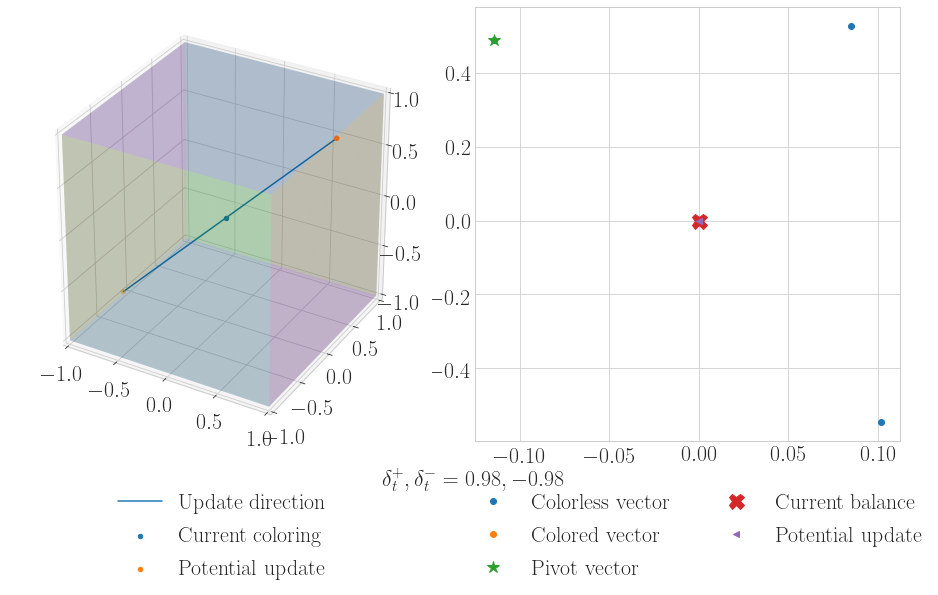

xs: [array([1.000e+00, 1.054e-01, 1.000e+00]), array([1.000e+00, 1.000e+00, -2.457e-02])]
sum:[array([-3.849e-03, 6.231e-04]), array([1.894e-01, -3.067e-02])]


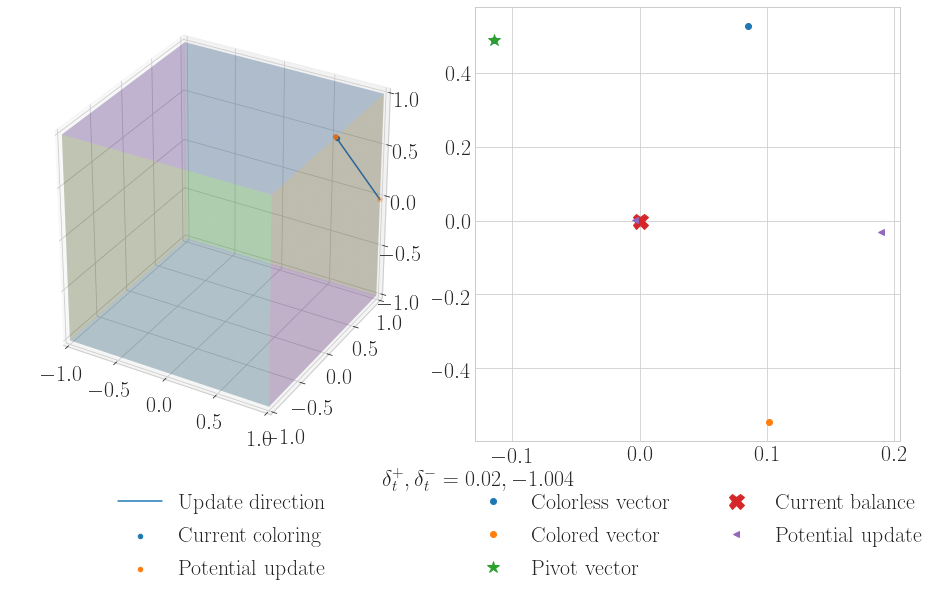

xs: [array([1.000e+00, -1.000e+00, 1.000e+00]), array([1.000e+00, 1.000e+00, 1.000e+00])]
sum:[array([-9.796e-02, -5.807e-01]), array([7.232e-02, 4.711e-01])]


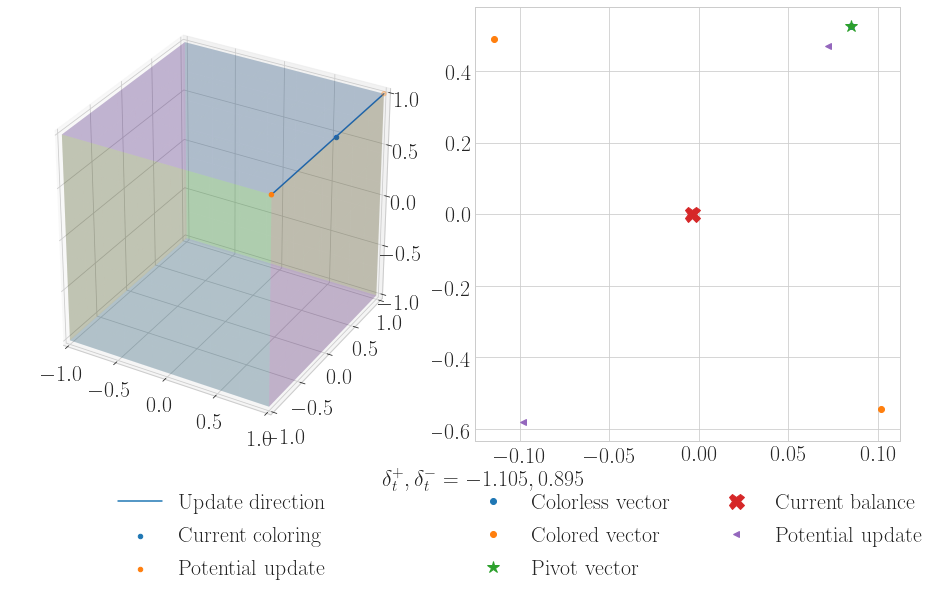

In [34]:
n=3
v=sample_from_sphere(n)
v=sample_from_ball(n)
print(f'v:{v}')
xs=[]
x=gram_schmidt_walk(v,np.zeros(n),plot=True)

n=10
2


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


8
32
128
512


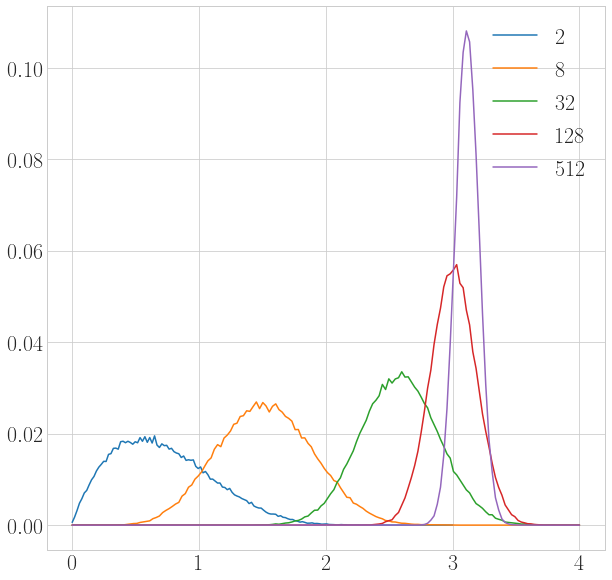

n=20
2
8
32
128
512


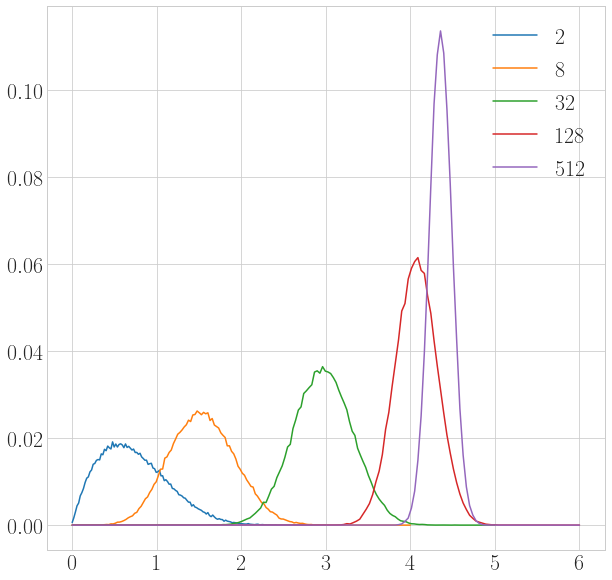

n=40
2
8
32
128
512


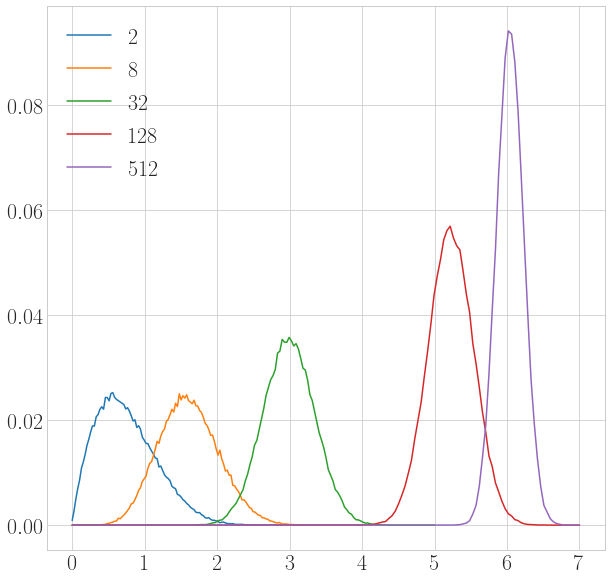

In [6]:
#maybe multiplot with different n ?
l=[2,8,32,128,512]
n_list=[10,20,40]
repeat=10**5
norms={}
for n in n_list:
    print(f'n={n}')
    norms[n]={}
    for d in l:
        print(d)
        norms[n][d]=[]
        for i in range(repeat):
            v=sample_from_ball(n,d=d)
            x=gram_schmidt_walk(v,np.zeros(n))
            B=np.transpose(np.vstack(tuple([e for e in v])))
            norms[n][d].append(np.sqrt(sum([x_**2 for x_ in np.matmul(B,x)])))
        h=int(np.ceil(max(norms[n][d])))
        split=int(np.sqrt(repeat)/2)
        r=np.linspace(0,h,split)
        num=[sum(map(lambda x:int((norm<=x) and (x<(norm+h/split))),norms[n][d]))/repeat for norm in r]
        plt.plot(r,num,label=str(d))
    plt.legend()
    plt.savefig(f'norms{n}.pdf')
    tikzplotlib.save(f"norms_n{n}.tex")
    plt.show()

n=5
2
4
8
16
32
64
128
256
512
1024
2048
4096
8192
16384
32768
65536


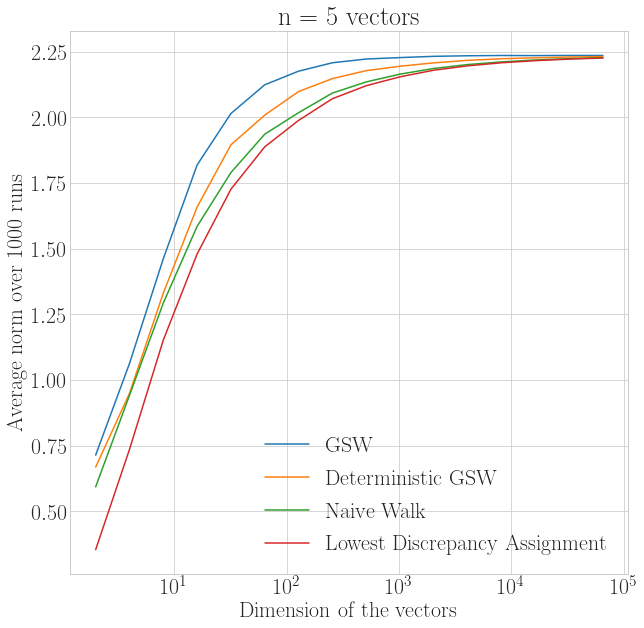

n=10
2
4
8
16
32
64
128
256
512
1024
2048
4096
8192
16384
32768
65536


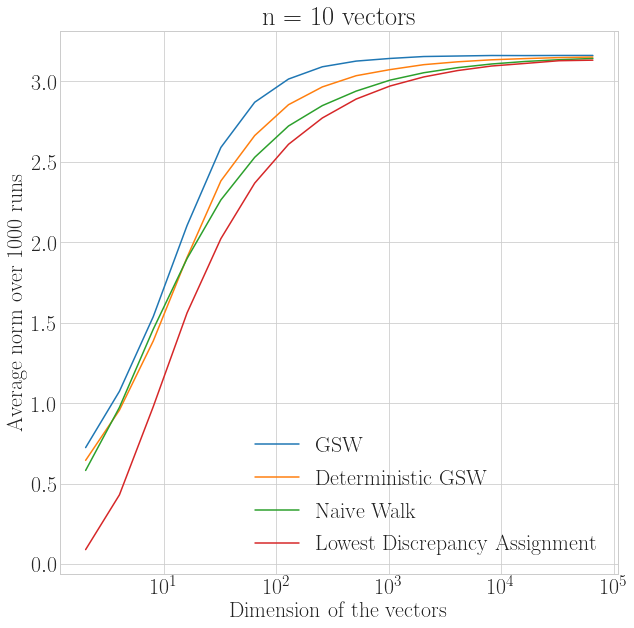

n=15
2
4
8
16
32
64
128
256
512
1024
2048
4096
8192
16384
32768


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:186: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


65536


KeyboardInterrupt: 

In [20]:
max_power=16.0
l=np.logspace(1.0, max_power, num=int(max_power), base=2.0)
n_list=[5,10,15,20,40]
#n_list=[5,10]
repeat=10**3
#repeat=10**1

#load dics
norms_gsw=open_dic_file('norms_gsw.pkl')
norms_gsw_det=open_dic_file('norms_gsw_det.pkl')
norms_naive=open_dic_file('norms_naive.pkl')
norms_best=open_dic_file('norms_best.pkl')

for n in n_list:
    print(f'n={n}')
    if norms_gsw.get(n) is None:
        norms_gsw[n]={}
    if norms_gsw_det.get(n) is None:
        norms_gsw_det[n]={}
    if norms_naive.get(n) is None:
        norms_naive[n]={}
    if norms_best.get(n) is None:
        norms_best[n]={}
    for d_ in l:
        d=int(d_)
        print(d)
        if norms_gsw[n].get(d) is None:
            norms_gsw[n][d]=[]
        if norms_gsw_det[n].get(d) is None:
            norms_gsw_det[n][d]=[]
        if norms_naive[n].get(d) is None:
            norms_naive[n][d]=[]
        if norms_best[n].get(d) is None:
            norms_best[n][d]=[]
        while len(norms_gsw[n][d])<repeat:
            v=sample_from_ball(n,d=d)
            x=gram_schmidt_walk(v,np.zeros(n))
            B=np.transpose(np.vstack(tuple([e for e in v])))
            norms_gsw[n][d].append(np.sqrt(sum([x_**2 for x_ in np.matmul(B,x)])))
            x_det=gram_schmidt_walk(v,np.zeros(n),smallest_delta=True)
            norms_gsw_det[n][d].append(np.sqrt(sum([x_**2 for x_ in np.matmul(B,x_det)])))
            x_naive=naive_walk(v)
            norms_naive[n][d].append(np.sqrt(sum([x_**2 for x_ in np.matmul(B,x_naive)])))
            if n<=10:
                disc,x_best=best_coloring(v)
                norms_best[n][d].append(disc)
    plt.plot(l,[sum(norms_gsw[n][d])/repeat for d in l],label=f'GSW')
    plt.plot(l,[sum(norms_gsw_det[n][d])/repeat for d in l],label=f'Deterministic GSW')
    plt.plot(l,[sum(norms_naive[n][d])/repeat for d in l],label=f'Naive Walk')
    plt.plot(l,[sum(norms_best[n][d])/repeat for d in l],label=f'Lowest Discrepancy Assignment')
    plt.title(f'n = {n} vectors')
    plt.xlabel('Dimension of the vectors')
    plt.ylabel(f'Average norm over {repeat} runs')
    plt.legend()
    plt.xscale('log')
    plt.savefig(f'comparative_norms_n={n}_repeat={repeat}_max_dim={2**max_power}.pdf')
    tikzplotlib.save(f"comparative_norms_n={n}_repeat={repeat}_max_dim={2**max_power}.tex")
    plt.show()

In [21]:
#save dics
save_dic_to_file(norms_gsw,'norms_gsw.pkl')
save_dic_to_file(norms_gsw_det,'norms_gsw_det.pkl')
save_dic_to_file(norms_naive,'norms_naive.pkl')
save_dic_to_file(norms_best,'norms_best.pkl')

In [259]:
X=np.array([[0,0,1],[0,1,0],[2,1,1]])
print(X)
print(gram_schmidt_columns(X))

[[0 0 1]
 [0 1 0]
 [2 1 1]]
[[0.000e+00 0.000e+00 -1.000e+00]
 [-0.000e+00 1.000e+00 0.000e+00]
 [-1.000e+00 -0.000e+00 0.000e+00]]


In [320]:
n=10
x=np.random.uniform(size=(n,n))
basis=gram_schmidt_columns(x)
v=sample_from_ball(n)
print(v)
v=np.transpose(np.matmul(np.transpose(np.vstack(tuple([e for e in basis]))),np.vstack(tuple([e for e in v]))))#is v already a list ? If so we can simplify syntax here
v=[v[:,i] for i in range(v.shape[1])]
print(v)

[array([-2.574e-01, 7.914e-01]), array([7.866e-01, 4.301e-01]), array([-3.746e-01, -6.659e-01]), array([6.826e-01, 4.059e-01]), array([5.890e-02, -3.040e-01]), array([6.808e-01, 1.020e-02]), array([7.960e-01, 1.972e-02]), array([7.478e-01, -3.739e-01]), array([-8.899e-01, 8.589e-02]), array([4.134e-01, 4.869e-01])]
[array([-8.283e-01, 3.123e-03]), array([-3.716e-01, 3.267e-01]), array([2.925e-01, 4.570e-01]), array([3.139e-01, 7.879e-01]), array([8.818e-01, 6.184e-01]), array([2.303e-01, 3.884e-02]), array([2.398e-01, 4.689e-01]), array([-1.207e+00, 4.780e-01]), array([7.476e-01, 2.336e-01]), array([3.783e-02, -2.712e-01])]


In [9]:
l=[1,2,3]
print(l[0:2])

[1, 2]


In [30]:
print(inv(np.array([[2,3,1],[1,1,0],[1,4,-1]])))
print(inv(np.array([[2,0,3,1],[1,0,1,0],[0,0,0,0],[1,0,4,-1]])))

[[-2.500e-01 1.750e+00 -2.500e-01]
 [2.500e-01 -7.500e-01 2.500e-01]
 [7.500e-01 -1.250e+00 -2.500e-01]]
[[-2.500e-01 1.750e+00 0.000e+00 -2.500e-01]
 [-3.331e-16 4.441e-16 0.000e+00 8.327e-17]
 [2.500e-01 -7.500e-01 0.000e+00 2.500e-01]
 [7.500e-01 -1.250e+00 0.000e+00 -2.500e-01]]


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:214: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [57]:
l=np.array([1,2,3])
new=np.append(l,4)
print(new)

[1 2 3 4]


In [185]:
b1=[np.array([1,2]),np.array([0,1])]
b2=orthonormal_basis(2)
print(change_basis(np.array([1,1]),b1,b2))

[1.000e+00 3.000e+00]


In [90]:
v=[np.array([1.0,0.,1.]),np.array([2.,0.,1.]),np.array([0.,0.,1.]),np.array([3.,0.,4.])]
q,r=np.linalg.qr(np.transpose(np.vstack(tuple([e for e in v]))))
v_p=np.array([1,2,1])
rs=np.array([(r[i,:]==np.zeros(r.shape[1])).all() for i in range(r.shape[0])])
print(rs)
q=q[:,~rs]
v_perp=v_p-q.dot(np.linalg.inv(q.T.dot(q))).dot(q.T).dot(v_p)
print(q)
print(r)
print(v_perp)

[False False  True]
[[-7.071e-01 -7.071e-01]
 [-0.000e+00 0.000e+00]
 [-7.071e-01 7.071e-01]]
[[-1.414e+00 -2.121e+00 -7.071e-01 -4.950e+00]
 [0.000e+00 -7.071e-01 7.071e-01 7.071e-01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00]]
[0.000e+00 2.000e+00 0.000e+00]


In [68]:
print(np.transpose(np.vstack(tuple([e for e in v]))))

[[1 2 0 3]
 [0 0 0 0]
 [1 1 1 4]]


In [74]:
#q=np.transpose(np.vstack(tuple([e for e in v])))
q.dot(np.linalg.inv(q.T.dot(q))).dot(q.T)

array([[1.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00]])

In [71]:
print(r)

[[-1.414e+00 -2.121e+00 -7.071e-01 -4.950e+00]
 [0.000e+00 -7.071e-01 7.071e-01 7.071e-01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00]]


In [73]:
!pip install numpy --upgrade

  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.1
    Uninstalling numpy-1.20.1:
      Successfully uninstalled numpy-1.20.1


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Accès refusé: 'C:\\Users\\GABO~1\\AppData\\Local\\Temp\\pip-uninstall-1__xnp5g\\core\\_multiarray_tests.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [78]:
q.dot(r)

array([[1.000e+00, 2.000e+00, -1.110e-16, 3.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 1.000e+00, 1.000e+00, 4.000e+00]])

In [9]:
v=[np.array([1,1,1]),np.array([1,0,0]),np.array([0,1,0]),np.array([2,1,0])]
basis=[np.array([1,0,0,0]),np.array([0,0,1,0]),np.array([0,1,0,0]),np.array([0,0,4,1])]
B=np.matmul(np.transpose(np.vstack(tuple([e for e in v]))),np.vstack(tuple([e for e in basis])).T)
print(B)

[[1 0 1 2]
 [1 1 0 5]
 [1 0 0 0]]


In [5]:
#Now with deterministic GSW
#Trying with half structured in dimension 100, where structured are such that they have four 1's in the first m (m=sqrt(n) here) coordinates and all 0's everywhere else.
#When are structured points colored and what is the coloring distribution among structured ?
n=200
v=sample_from_ball(int(n/2),d=n)
subteam = [0] * int(np.sqrt(n)-4) + [1/2] * 4
for i in range(int(n/2)):
    random.shuffle(subteam)
    v.append(np.array(subteam.copy()+[0]*(n-int(np.sqrt(n)))))
for i in range(len(v)):
    v[i]=normalize(v[i])
B=np.transpose(np.vstack(tuple([e for e in v])))
gsw_xs=[]
gsw_output_norm=[]
coloring_discrepancy_among_structured=[]
coloring_discrepancy_among_non_structured=[]
coloring_order=[]
avg_time_step_of_coloring_for_structured=[]
for i in range(n):
    print(f'\n Try #{i}')
    res,order=gram_schmidt_walk(v,np.zeros(n),order=True,smallest_delta=True)
    gsw_xs.append(res)
    gsw_output_norm.append(norm(np.matmul(B,res)))
    print(f'Output norm: {gsw_output_norm[-1]}')
    coloring_order.append(order)
    avg_step_struct=average([j for j in range(len(order)) if order[j]>=n/2])
    print(f'Average time step of coloring of structured elements: {avg_step_struct}')
    avg_time_step_of_coloring_for_structured.append(avg_step_struct)
    disc_struct=abs(sum(res[int(n/2):]))
    coloring_discrepancy_among_structured.append(disc_struct)
    print(f'Coloring discrepancy among structured points:{disc_struct}')
    disc_non_struct=abs(sum(res[:int(n/2)]))
    coloring_discrepancy_among_non_structured.append(disc_non_struct)
    print(f'Coloring discrepancy among non-structured points:{disc_non_struct}')
    
print(f'\n Final breakdown')
print(f'Average output norm: {average(gsw_output_norm)}')
print(f'Average of Average time step of coloring of structured elements: {average(avg_time_step_of_coloring_for_structured)}')
print(f'Average coloring discrepancy among structured points:{average(coloring_discrepancy_among_structured)}')
print(f'Average coloring discrepancy among non-structured points:{average(coloring_discrepancy_among_non_structured)}')


 Try #0


C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:296: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Ga Bo\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


v_perp:[3.123e-17 2.776e-17 8.240e-18 -6.072e-18 1.214e-17 5.551e-17 -4.163e-17
 -4.575e-17 1.388e-17 1.735e-17 1.110e-16 7.286e-17 0.000e+00 -4.163e-17
 -6.960e-04 -1.877e-04 1.472e-04 -2.709e-04 -2.783e-04 -5.961e-05
 -1.382e-04 -1.770e-04 2.350e-04 1.497e-04 1.308e-04 1.017e-04 -1.315e-03
 1.228e-03 -2.221e-04 4.176e-04 -5.345e-04 3.622e-04 -6.725e-04 6.351e-04
 -8.001e-06 1.650e-05 1.074e-03 -7.439e-04 -6.244e-04 -4.979e-04
 -3.798e-04 -9.000e-05 1.515e-04 -8.193e-05 2.915e-05 -9.194e-05
 -4.710e-04 1.101e-03 -6.777e-04 1.001e-04 2.773e-04 -3.040e-04 -9.791e-04
 -3.824e-04 1.223e-03 -3.542e-04 1.951e-04 3.155e-04 -6.759e-06 3.165e-04
 -1.676e-04 -6.993e-04 1.782e-04 6.233e-05 -2.140e-05 6.480e-04 -3.936e-04
 -2.529e-04 3.502e-04 6.013e-04 -8.314e-04 4.324e-04 -3.354e-04 3.863e-04
 -6.086e-04 -3.137e-05 1.525e-04 3.732e-05 1.753e-04 -2.264e-05 1.083e-04
 7.278e-04 -4.617e-05 -1.023e-04 -1.221e-04 2.620e-04 -6.736e-04 4.672e-04
 1.744e-04 2.817e-04 -1.674e-04 -6.953e-04 2.065e-04 -8.

v_perp:[1.735e-18 0.000e+00 2.927e-17 6.505e-18 -2.082e-17 6.245e-17 -1.388e-17
 -8.183e-17 0.000e+00 3.469e-17 1.110e-16 1.041e-17 4.163e-17 -4.857e-17
 4.341e-03 3.566e-03 6.465e-03 7.996e-03 1.002e-03 5.358e-03 -3.134e-03
 1.698e-03 -6.376e-04 1.115e-02 -5.794e-03 -4.111e-03 1.074e-02 7.940e-03
 -7.111e-03 -3.623e-03 -3.725e-03 3.357e-03 2.982e-03 5.205e-03 -3.344e-03
 6.479e-03 2.025e-04 7.349e-03 4.254e-04 5.155e-04 5.938e-03 5.844e-03
 1.018e-04 5.932e-03 -2.318e-03 -4.894e-06 3.564e-03 -7.005e-03 -5.037e-03
 2.158e-03 -7.804e-03 -2.539e-03 -3.701e-03 -8.382e-03 5.677e-04 7.490e-04
 -1.535e-04 8.599e-03 4.286e-03 -6.268e-03 4.142e-05 2.149e-03 -5.044e-03
 -3.378e-03 3.834e-03 1.013e-03 1.772e-03 1.272e-03 -6.222e-03 2.227e-03
 1.481e-04 -3.910e-03 2.778e-03 -3.693e-04 5.357e-03 7.488e-04 4.831e-03
 -2.162e-03 1.826e-04 -8.085e-03 5.652e-03 -3.432e-03 1.501e-03 1.003e-03
 -3.289e-03 -2.808e-03 1.334e-02 1.908e-03 -2.676e-03 4.094e-03 -5.156e-03
 7.883e-03 -7.545e-04 4.353e-04 -6.7

v_perp:[8.674e-18 -5.551e-17 3.665e-17 -5.573e-17 5.204e-18 6.939e-18 -4.163e-17
 -2.369e-17 0.000e+00 -1.214e-17 2.776e-17 -3.469e-18 1.735e-17 0.000e+00
 1.537e-02 4.861e-03 2.060e-03 -6.558e-03 6.442e-03 -1.458e-03 1.172e-02
 1.085e-02 -1.202e-02 6.340e-03 -4.723e-03 -1.733e-03 1.204e-02 -5.346e-03
 -8.435e-03 -6.093e-03 4.037e-03 -2.573e-03 3.237e-03 -7.273e-03 1.068e-03
 -1.562e-03 -9.167e-03 6.999e-03 1.725e-02 7.169e-03 9.813e-03 -1.086e-02
 -6.545e-03 1.399e-02 -1.187e-04 1.119e-02 1.765e-03 7.365e-04 -5.679e-03
 -7.746e-03 -1.130e-02 8.598e-03 1.658e-04 -3.087e-03 3.948e-03 6.607e-03
 -1.206e-03 -1.547e-03 -8.729e-03 -1.062e-02 -8.164e-03 5.327e-03
 1.186e-02 -7.152e-03 2.669e-03 2.558e-03 1.139e-02 1.696e-02 -2.571e-02
 5.316e-03 9.720e-03 -1.062e-03 -1.505e-04 -5.286e-03 -4.819e-04 8.121e-03
 9.692e-03 -1.024e-02 8.590e-03 -1.172e-03 8.492e-03 -2.563e-03 2.045e-03
 1.935e-03 -4.728e-03 -1.036e-02 1.126e-03 -5.410e-03 -6.536e-03 8.593e-03
 -4.635e-03 -1.996e-04 -8.398e-04 1.5

v_perp:[5.378e-17 -8.327e-17 4.098e-17 -6.353e-17 -2.082e-17 4.163e-17 -4.163e-17
 -4.022e-17 1.388e-17 -8.674e-18 1.249e-16 -1.735e-17 -5.204e-17 1.388e-17
 -1.684e-02 2.373e-02 8.013e-03 1.200e-02 1.911e-02 -3.205e-03 -3.082e-02
 3.254e-05 -7.635e-03 5.640e-03 2.326e-03 -2.902e-03 2.343e-02 -1.798e-02
 -4.607e-02 -6.764e-03 3.207e-03 -1.516e-02 -1.879e-03 8.418e-04
 -1.481e-02 -1.552e-02 -6.015e-03 -1.030e-02 -1.294e-02 -2.714e-03
 -1.137e-02 -2.065e-02 -3.005e-02 -2.704e-03 -2.503e-03 4.504e-02
 -3.686e-03 -1.887e-03 -1.399e-02 7.396e-04 -2.284e-02 -6.504e-03
 -1.428e-02 6.125e-03 6.981e-04 -4.224e-03 -9.493e-03 1.617e-02 -2.803e-02
 9.469e-03 -2.507e-02 -1.942e-02 2.166e-02 -2.485e-03 9.805e-03 3.189e-02
 1.596e-02 -2.359e-02 1.706e-02 -7.178e-03 -2.182e-02 2.387e-02 -1.897e-02
 5.329e-03 -5.566e-03 2.430e-03 -1.883e-03 -7.969e-04 8.643e-04 5.976e-03
 -5.614e-03 -1.381e-02 -3.982e-03 1.899e-03 -5.508e-03 -1.056e-03
 4.980e-03 1.035e-02 -8.468e-03 7.132e-03 1.587e-02 -7.637e-03 -4.4

v_perp:[6.765e-17 -2.776e-17 2.299e-17 -1.756e-17 -5.204e-18 4.857e-17 2.776e-17
 2.410e-17 2.776e-17 1.561e-17 1.388e-17 -4.510e-17 1.735e-17 -6.939e-18
 -3.910e-04 7.923e-03 -3.357e-03 2.499e-02 7.222e-03 1.685e-02 -4.415e-02
 2.284e-02 -2.256e-02 -1.167e-02 -3.088e-02 -3.810e-02 -1.320e-02
 7.299e-03 -7.342e-04 5.499e-03 -7.105e-03 1.451e-02 1.539e-03 -3.520e-03
 -1.602e-03 -1.483e-03 -9.748e-03 -3.559e-03 -1.622e-03 2.578e-03
 1.232e-02 -2.588e-02 -1.045e-02 6.896e-03 -2.388e-02 -4.439e-03
 -2.064e-03 -1.651e-03 -5.799e-03 -2.105e-03 -3.089e-02 6.250e-03
 1.499e-02 1.319e-02 1.439e-02 -5.434e-03 -1.174e-02 1.304e-03 1.429e-02
 -1.010e-02 -2.384e-02 2.106e-02 6.651e-03 8.769e-03 5.277e-03 1.247e-02
 -1.858e-02 -1.110e-02 1.133e-02 2.690e-03 -2.195e-02 1.110e-02 7.514e-03
 -5.341e-03 -2.826e-02 -1.485e-02 2.025e-02 1.917e-02 -4.275e-03
 -2.842e-03 -3.101e-03 -6.598e-03 -7.649e-03 2.227e-02 -3.584e-02
 1.120e-02 -2.316e-02 -9.179e-03 -2.320e-03 2.509e-02 1.169e-02 9.003e-03
 -1.022e-0

v_perp:[1.735e-17 -5.551e-17 1.063e-17 -5.920e-17 2.776e-17 1.388e-17 2.776e-17
 -1.025e-17 3.469e-17 -3.296e-17 9.714e-17 -6.592e-17 1.735e-17 0.000e+00
 -2.472e-02 1.079e-02 1.708e-02 1.221e-02 1.071e-02 1.150e-02 -1.070e-02
 1.328e-02 -1.486e-02 3.380e-02 -5.015e-03 -2.051e-02 6.013e-03 -2.530e-02
 -2.183e-03 9.022e-03 2.553e-03 -1.955e-03 1.158e-02 1.112e-03 -6.389e-03
 -1.048e-02 -2.040e-02 1.738e-03 -4.315e-03 7.283e-03 3.369e-03 2.058e-03
 2.021e-02 -2.188e-03 -4.628e-03 3.698e-03 -2.043e-03 -5.139e-03
 -1.138e-03 8.152e-03 -1.461e-02 -1.492e-02 2.297e-02 1.086e-02 -9.699e-03
 -9.976e-04 1.283e-02 2.451e-03 9.603e-04 -2.609e-03 -3.028e-02 -1.080e-02
 2.451e-02 7.143e-03 -7.757e-03 -2.144e-02 -1.468e-02 -1.840e-03 1.617e-02
 1.271e-02 9.421e-04 8.834e-03 1.076e-02 3.324e-02 4.462e-03 5.272e-03
 1.293e-02 3.163e-03 -5.646e-03 1.463e-02 -2.283e-02 -1.341e-02 -3.035e-02
 7.407e-04 -1.230e-02 2.046e-02 3.077e-03 3.883e-04 -9.214e-03 -4.044e-03
 8.080e-03 6.425e-03 -2.514e-02 -4.819e-

v_perp:[6.592e-17 -2.776e-17 -2.711e-17 -4.185e-17 6.939e-18 1.388e-17 0.000e+00
 -2.046e-17 0.000e+00 -3.123e-17 4.163e-17 -3.469e-18 -6.939e-18 4.163e-17
 1.826e-03 3.800e-02 2.660e-02 3.692e-02 4.477e-02 1.066e-02 2.034e-03
 1.954e-02 6.324e-03 2.994e-02 -1.214e-02 -4.038e-02 3.395e-04 -1.824e-02
 -1.824e-02 -1.451e-02 -8.376e-03 1.303e-02 -4.416e-03 6.064e-03
 -2.939e-02 -1.651e-02 3.652e-02 1.679e-02 -1.815e-02 -1.080e-02
 -2.278e-02 3.869e-02 -2.377e-02 -1.120e-04 1.203e-02 2.220e-03 2.542e-02
 2.325e-03 -1.708e-02 -9.565e-03 -2.043e-02 -1.626e-02 3.381e-02 6.912e-03
 -3.539e-02 2.010e-02 -3.383e-02 -7.527e-04 2.632e-02 -2.917e-02
 -4.662e-02 -2.543e-03 -2.910e-02 -1.304e-02 1.200e-02 -1.548e-03
 -3.081e-03 2.213e-02 -2.356e-02 -3.821e-02 -2.106e-02 4.847e-03
 -1.369e-02 1.674e-02 -6.557e-03 -4.933e-02 7.049e-03 1.531e-03 -5.860e-03
 4.525e-04 -1.729e-02 -2.356e-02 2.742e-02 -1.011e-03 -3.637e-02 6.609e-02
 1.219e-02 -1.035e-04 2.746e-03 9.385e-03 -7.957e-03 -2.420e-02 -1.188e-02

v_perp:[3.296e-17 -4.163e-17 5.963e-17 -8.001e-17 -3.990e-17 1.388e-17 4.163e-17
 3.740e-17 3.469e-17 -4.510e-17 8.327e-17 -4.163e-17 6.939e-18 -1.388e-17
 8.956e-03 -3.731e-02 8.241e-03 2.195e-02 2.593e-02 -3.143e-03 6.807e-03
 1.522e-02 1.349e-02 -4.802e-04 5.248e-03 -1.894e-02 -2.554e-05 -1.684e-03
 -1.173e-02 -6.887e-03 1.201e-02 9.072e-03 -1.570e-02 1.970e-03 4.743e-03
 -2.959e-02 3.559e-03 2.720e-02 2.539e-03 3.585e-03 1.016e-02 -2.910e-02
 4.639e-03 -1.930e-02 1.194e-04 2.865e-03 8.208e-03 6.007e-03 -1.099e-02
 3.041e-04 6.373e-03 -2.487e-02 9.436e-03 2.676e-02 -2.835e-02 3.695e-02
 -3.427e-03 9.125e-04 3.218e-02 -4.849e-03 -2.554e-02 4.037e-03 -3.421e-03
 -1.492e-03 5.682e-05 -2.442e-02 -8.479e-03 1.940e-02 -2.564e-02
 -5.776e-04 -6.884e-03 -3.933e-02 3.026e-02 -1.779e-02 -2.734e-02
 -2.797e-02 4.909e-03 -1.016e-02 6.284e-03 -1.253e-05 -2.157e-03
 -4.642e-03 2.647e-02 -1.999e-02 -1.846e-02 1.313e-03 -1.370e-02
 -6.425e-03 -1.172e-02 -8.411e-04 -3.364e-02 -1.593e-02 -1.081e-03
 

v_perp:[5.551e-17 -8.327e-17 4.033e-17 5.009e-17 -2.776e-17 2.776e-17 -1.388e-17
 7.454e-18 -2.082e-17 4.857e-17 9.714e-17 -1.041e-17 0.000e+00 6.245e-17
 -1.343e-02 1.043e-02 1.815e-02 -1.194e-02 2.361e-02 -3.981e-02 1.997e-02
 3.080e-02 1.720e-02 2.376e-02 -3.497e-02 9.754e-03 -1.391e-02 -7.474e-03
 -2.967e-02 1.988e-02 1.745e-02 6.131e-03 2.045e-02 -2.236e-02 -3.376e-03
 -1.889e-02 -1.791e-02 -2.020e-02 -3.240e-02 3.724e-02 -1.152e-02
 2.867e-05 -6.194e-03 -1.067e-02 -1.360e-03 1.727e-02 1.845e-02 3.651e-03
 -3.379e-02 -1.950e-02 3.033e-03 -1.787e-02 -1.260e-02 5.881e-03 5.628e-03
 2.448e-02 -2.082e-02 1.506e-02 2.035e-02 -2.090e-02 -5.813e-02 6.843e-03
 -1.084e-02 1.920e-03 -3.052e-04 -1.425e-02 1.970e-03 1.091e-02 2.848e-03
 1.740e-02 -7.072e-03 -1.647e-03 1.173e-02 -7.461e-03 1.935e-03 -1.144e-02
 8.686e-03 6.816e-03 -2.970e-03 6.237e-03 -3.874e-02 1.752e-02 -1.091e-02
 -1.633e-02 -4.910e-02 4.702e-02 -1.811e-02 2.221e-03 -3.047e-02 3.651e-02
 -5.929e-03 -2.395e-03 -1.487e-02 8.2

KeyboardInterrupt: 